# **Mystery ETF Allocation Analysis (Python Optimization for Finance)**


The goal of this project is to identify and reconstruct the composition of unknown (Mystery) ETFs by analyzing their returns.

Using statistical and machine learning models, we infer:
- their underlying asset and ETF exposures
- whether their allocation is fixed or dynamically rebalanced,
- and the frequency of rebalancing.

Resources:
- Returns of Mystery ETFs
- Returns of 105 base ETFs
- Returns of main asset classes (equities, bonds, commodities)



# Table of Contents

## I. Classification of ETFs on Various Risks, Relationships, and Performance
- [Compute Metrics](#compute-metrics)
- [Pairwise Relationships Between ETF Metrics](#pairwise-relationships-between-etf-metrics)
- [Clustered Correlation Matrix of Returns](#clustered-correlation-matrix-of-returns)
- [PCA Projection of ETFs on 2D and 3D](#pca-projection-of-etfs-on-2d-and-3d)
- [Agglomerative Hierarchical Clustering of ETFs](#agglomerative-hierarchical-clustering-of-etfs)
- [KMeans Clustering of ETFs](#kmeans-clustering-of-etfs)

## II. Relationships Between ETFs and Main Asset Classes
- [Align ETFs and Main Assets](#align-etfs-and-main-assets)
- [Correlation for Each Pair ETF–Asset](#correlation-for-each-pair-etf–asset)
- [Asset-Class-Based Regression of ETF Returns](#asset-class-based-regression-of-etf-returns)
- [Plot ETF vs Assets](#plot-etf-vs-assets)
- [Plot Importance Results](#plot-importance-results)
- [Comparing Cumulative Returns from Models](#comparing-cumulative-returns-from-models)
- [Frequency of Asset Classes in ETF Decomposition](#frequency-of-asset-classes-in-etf-decomposition)

## III. Ranges of Risks Among ETFs
- [Comparing Risk Metrics from True ETF and Reconstructed ETF](#comparing-risk-metrics-from-true-etf-and-reconstructed-etf)

## IV. Mystery Allocation
- [Fixed Allocation (Constant Weights Over Time)](#fixed-allocation-constant-weights-over-time)
- [Plot Mystery ETF Correlation](#plot-mystery-etf-correlation)
- [Plot Asset Decomposition of Mystery ETF](#plot-asset-decomposition-of-mystery-etf)

In [5]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [6]:
!ls

'Anonymized ETFs.csv'	  'Mystery Allocation 1.csv'   sample_data
'Main Asset Classes.csv'  'Mystery Allocation 2.csv'


In [7]:
# Frequency for annualization (daily trading days)
TRADING_DAYS = 252

In [8]:
etf_prices = pd.read_csv("Anonymized ETFs.csv", index_col=0)
etf_prices = etf_prices.iloc[1:, :]
etf_prices.index = pd.to_datetime(etf_prices.index, dayfirst=True, errors='coerce')
etf_prices.columns = etf_prices.columns.str.strip()

# Compute returns
etf_rets = etf_prices.pct_change().dropna()

# Compute cumulative returns
etf_cum_rets = (1 + etf_rets).cumprod()

print(etf_prices.shape)
print(etf_rets.shape)
etf_rets.head()

(1405, 105)
(1404, 105)


ETF 1     ETF 2     ETF 3     ETF 4     ETF 5     ETF 6  \
2019-01-02  0.001272 -0.001473 -0.010113 -0.002512  0.000908 -0.004294   
2019-01-03 -0.024575 -0.014755 -0.006302 -0.013454 -0.006079 -0.023584   
2019-01-04  0.034334  0.027523  0.015593  0.025611  0.021628  0.036050   
2019-01-07  0.007011  0.008181  0.013232  0.008941 -0.003880  0.007600   
2019-01-08  0.009711  0.008362 -0.002487  0.006906  0.007446  0.010532   

               ETF 7     ETF 8     ETF 9    ETF 10  ...    ETF 96   ETF 97  \
2019-01-02  0.002041  0.003049  0.008061  0.000977  ... -0.013949  0.00000   
2019-01-03 -0.000915  0.005885 -0.027786  0.004214  ... -0.001572  0.00000   
2019-01-04 -0.003119 -0.008175  0.032749  0.005772  ...  0.024868 -0.01591   
2019-01-07 -0.001253  0.009610  0.002443  0.005750  ...  0.009099  0.02878   
2019-01-08 -0.001096 -0.004450  0.011476 -0.001113  ... -0.003509  0.00419   

              ETF 98    ETF 99   ETF 100   ETF 101   ETF 102   ETF 103  \
2019-01-02 -0.005079  0.001167  0.000000 -0.000927 -0.018285  0.000848   
2019-01-03 -0.000024 -0.010991  0.004356 -0.024426 -0.011830  0.004006   
2019-01-04  0.018864  0.016697  0.016838  0.035507  0.013476  0.005700   
2019-01-07  0.002588  0.005141 -0.008435  0.006167  0.016201  0.005758   
2019-01-08  0.013411  0.006910  0.010957  0.012529 -0.003293 -0.001262   

             ETF 104   ETF 105  
2019-01-02 -0.002284 -0.001937  
2019-01-03 -0.012024 -0.018674  
2019-01-04  0.029339  0.030659  
2019-01-07  0.000153  0.004298  
2019-01-08  0.008239  0.008269  

[5 rows x 105 columns]

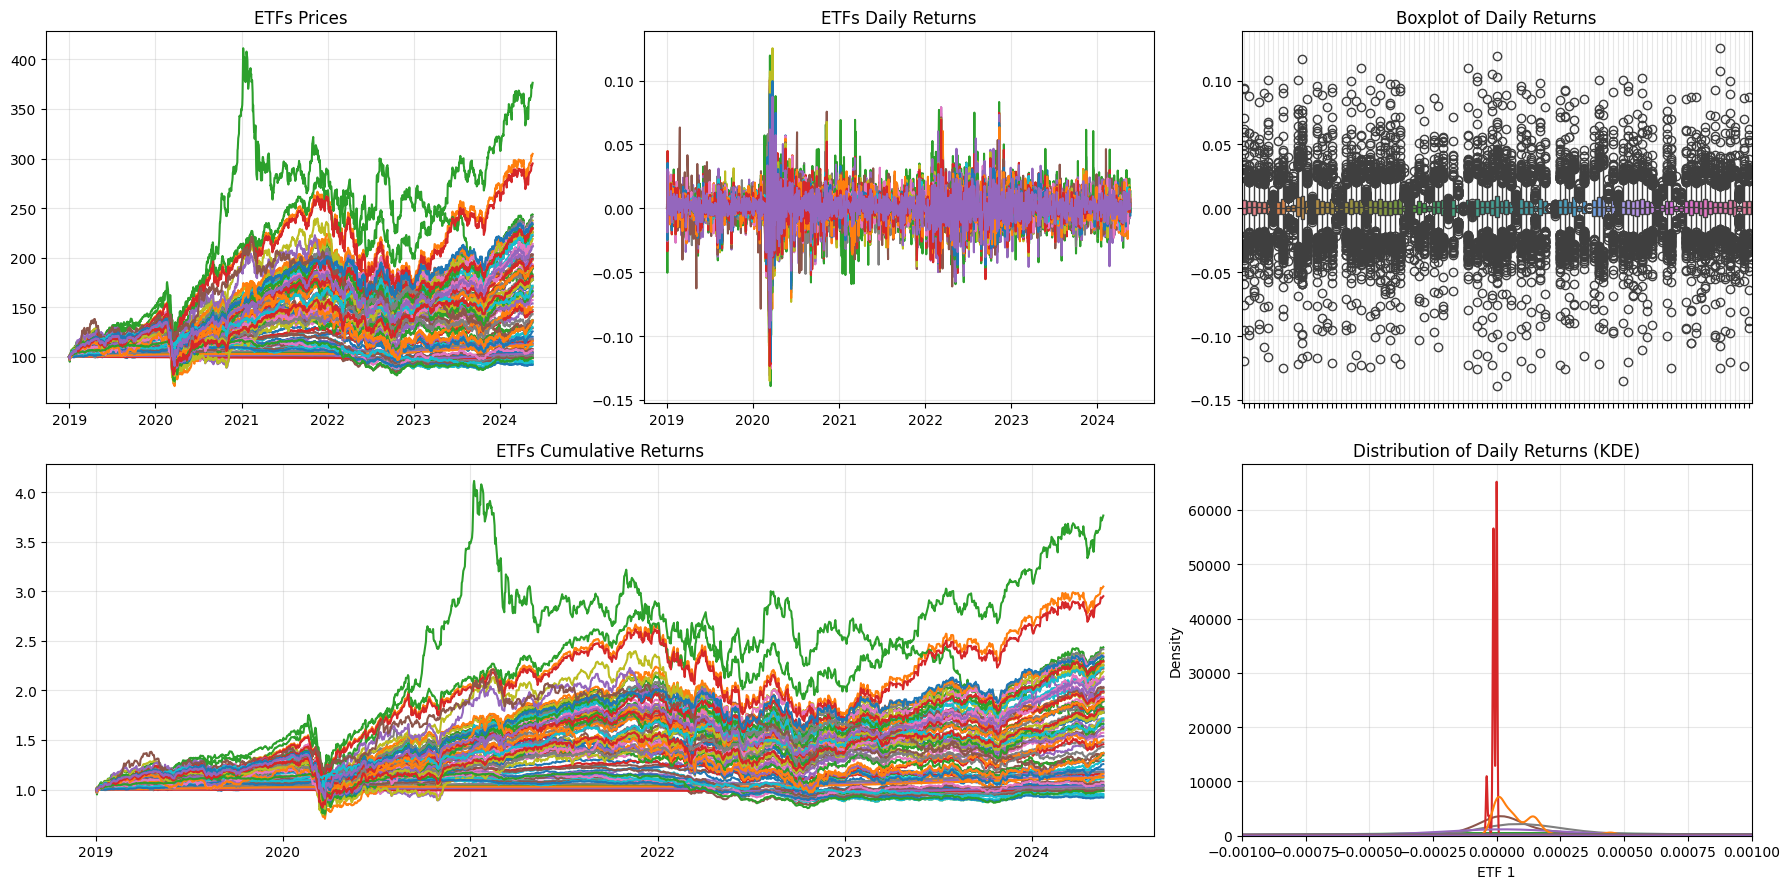

In [9]:
mosaic = [
    ["A", "B", "D"],
    ["C", "C", "E"]
]

fig, axes = plt.subplot_mosaic(mosaic, figsize=(18,  10))
plt.subplots_adjust(hspace=0.9, wspace=0.2)

# ETFs Prices
for col in etf_prices.columns:
    axes["A"].plot(etf_prices.index, etf_prices[col], label=col)
axes["A"].set_title("ETFs Prices")
axes["A"].grid(True, alpha=0.3)

# ETFs Daily Returns
for col in etf_rets.columns:
    axes["B"].plot(etf_rets.index, etf_rets[col], label=col)
axes["B"].set_title("ETFs Daily Returns")
axes["B"].grid(True, alpha=0.3)

# ETFs Cumulative Returns
for col in etf_cum_rets.columns:
    axes["C"].plot(etf_cum_rets.index, etf_cum_rets[col], label=col)
axes["C"].set_title("ETFs Cumulative Returns")
axes["C"].grid(True, alpha=0.3)

# Boxplot of Daily Returns
sns.boxplot(data=etf_rets, ax=axes["D"])
axes["D"].set_title("Boxplot of Daily Returns")
axes["D"].set_xticklabels([])
axes["D"].grid(True, alpha=0.3)

# KDE plot of Daily Returns
for col in etf_rets.columns:
    sns.kdeplot(etf_rets[col], ax=axes["E"], label=col)
axes["E"].set_title("Distribution of Daily Returns (KDE)")
axes["E"].grid(True, alpha=0.3)
axes["E"].set_xlim(-0.001, 0.001)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

________

# I. Classification of ETFs

To classify ETFs and understand their risk–return profiles, we rely on a set of performance and risk metrics. Each metric captures a different dimension of portfolio behavior and together they provide a robust characterization of ETFs.



|   Metric |   |   Formula | Description |
|--|-----|--------|-------------|
| **Annualized Return** |  Performance & Risk-Adjusted Metrics | $$\text{AnnReturn} = \mathbb{E}[r_t] \times \text{trading days}$$ | Measures the average yearly return of the ETF. <br><br> Provides a first-order measure of performance <br>- Enables comparison across ETFs on a common annual scale <br>- Essential for ranking assets by long-term profitability |
| **Annualized Volatility** |  Performance & Risk-Adjusted Metrics | $$\text{AnnVol} = \sigma(r_t)\sqrt{\text{trading days}}$$ | Measures the dispersion of returns around the mean (total risk). <br><br>- Core risk metric in modern portfolio theory <br>- Captures uncertainty and instability of returns <br>- Key input for risk-adjusted performance measures |
| **Sharpe Ratio** | Performance & Risk-Adjusted Metrics | $$\text{Sharpe} = \frac{\text{AnnReturn} - \text{Risk-free rate}}{\text{AnnVol}}$$ | Measures return per unit of risk. <br><br>- Allows fair comparison between ETFs with different risk levels <br>- Penalizes excessive volatility <br>- Widely used by practitioners for portfolio selection |
| **Skewness** | Distribution Shape Metrics |  $$\text{Skew} = \mathbb{E}\left[\left(\frac{r_t - \mu}{\sigma}\right)^3\right]$$ | Measures asymmetry of the return distribution. <br><br>- Negative skew indicates higher probability of extreme losses <br>- Positive skew signals occasional large gains <br>- Reveals tail risks not captured by volatility |
| **Kurtosis** | Distribution Shape Metrics | $$\text{Kurtosis} = \mathbb{E}\left[\left(\frac{r_t - \mu}{\sigma}\right)^4\right]$$ | Measures tail thickness of the return distribution. <br><br>- High kurtosis indicates fat tails and extreme events <br>- Important for stress testing and risk management <br>- Explains why volatility may underestimate true risk |
| **Value at Risk (VaR)** | Downside Risk Metrics |  $$\text{VaR}_{\alpha} = \inf \{x : P(r_t \le x) \ge \alpha\}$$ | Maximum expected loss over one period at confidence level $\alpha$. <br><br>- Standard regulatory risk measure <br>- Provides a clear downside risk threshold <br>- Easy to interpret and communicate |
|   **Conditional Value at Risk (CVaR)** |  Downside Risk Metrics | $$\text{CVaR}_{\alpha} = \mathbb{E}[r_t \mid r_t \le \text{VaR}_{\alpha}]$$ | Expected loss given that VaR is exceeded. <br><br>- Captures tail risk more accurately than VaR <br>- Coherent risk measure (convex, subadditive) <br>- Particularly relevant during crisis periods |
| **Maximum Drawdown** | Downside Risk Metrics | $$\text{MaxDrawdown} = \min_t \left(\frac{V_t - \max_{s \le t} V_s}{\max_{s \le t} V_s}\right)$$ | Measures the worst peak-to-trough loss. <br><br>- Captures extreme downside risk <br>- Highly relevant for capital preservation <br>- Reflects stress during financial crises |



In [10]:
def compute_metrics(returns, trading_days=TRADING_DAYS, alpha=0.05):
    metrics = pd.DataFrame(index=returns.columns)
    # Annualized return
    metrics['AnnReturn'] = returns.mean() * trading_days
    # Annualized volatility
    metrics['AnnVol'] = returns.std() * np.sqrt(trading_days)
    # Sharpe ratio (risk-free rate = 0)
    metrics['Sharpe'] = metrics['AnnReturn'] / metrics['AnnVol']
    # Max drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    metrics['MaxDrawdown'] = drawdown.min()
    # Skewness & Kurtosis
    metrics['Skew'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()
    # VaR (Value at Risk 5%)
    metrics['VaR_95'] = returns.quantile(alpha)
    # CVaR (Conditional VaR 5%)
    def cvar(x, alpha=0.05):
        x = x.dropna()
        cutoff = np.quantile(x, alpha)
        return x[x <= cutoff].mean()
    metrics['CVaR_95'] = returns.apply(lambda x: cvar(x, alpha))
    return metrics

In [11]:
etf_metrics = compute_metrics(etf_rets)
metrics_list = etf_metrics.columns.tolist()
print(etf_metrics.shape)
etf_metrics.head()

(105, 8)


AnnReturn    AnnVol    Sharpe  MaxDrawdown      Skew   Kurtosis  \
ETF 1   0.167017  0.203997  0.818724    -0.338309 -0.533572  14.348390   
ETF 2   0.141341  0.174450  0.810208    -0.340332 -0.815069  15.113467   
ETF 3   0.066820  0.164794  0.405479    -0.368666 -0.525024   6.032380   
ETF 4   0.129837  0.163442  0.794390    -0.337100 -0.936647  15.822307   
ETF 5   0.091576  0.168541  0.543346    -0.342183 -0.920129  15.347135   

         VaR_95   CVaR_95  
ETF 1 -0.017902 -0.030917  
ETF 2 -0.015486 -0.026249  
ETF 3 -0.015652 -0.024474  
ETF 4 -0.014362 -0.024435  
ETF 5 -0.015393 -0.026811

The figure presents histograms and boxplots for our metrics. Together, these plots provide insights into central tendencies, dispersion, skewness, tail risk and outliers.


<br>

### 1. Performance & Risk-Adjusted Metrics

- Annualized Return: Most ETFs deliver moderate annual returns, clustered around similar values. A few ETFs stand out with much higher returns. Showing that while performance is generally comparable, some ETFs clearly outperform

- Annualized Volatility: Volatility varies significantly across ETFs. They exhibit heterogeneous risk profiles, some are relatively stable, while others are much more volatile. This may reflect different risk exposures across asset classes.

- Sharpe Ratio: The majority of ETFs have Sharpe ratios close to zero. Only a small number of ETFs achieve strong risk-adjusted performance.

<br>

### 2. Distribution Shape Metrics


- Skewness: Many ETFs show negative skewness. There are large negative outliers (down to −6) and some positive skew outliers. We can deduce that many ETFs are more prone to large downside shocks than upside surprises.

- Kurtosis: Most ETFs exhibit fat-tailed return distributions. Extreme events occur more often than predicted by a normal model. This confirms that tail risk is a key feature of ETF returns.

<br>

### 3. Downside Risk Metrics

- Maximum Drawdown: Most ETFs experience sizable peak-to-trough losses. Severe drawdowns are common, especially during market stress. This metric highlights the importance of downside risk control.

- Value at Risk: Daily losses at the 5% confidence level are generally moderate. However, there are noticeable differences across ETFs. This indicates heterogeneous short-term downside risk.

- Conditional Value at Risk: Losses beyond VaR are substantially larger. Some ETFs are particularly exposed to extreme market moves. CVaR better captures tail risk than VaR. This confirms that when extreme losses occur, they are substantially worse than suggested by VaR alone, highlighting tail risk concentration.




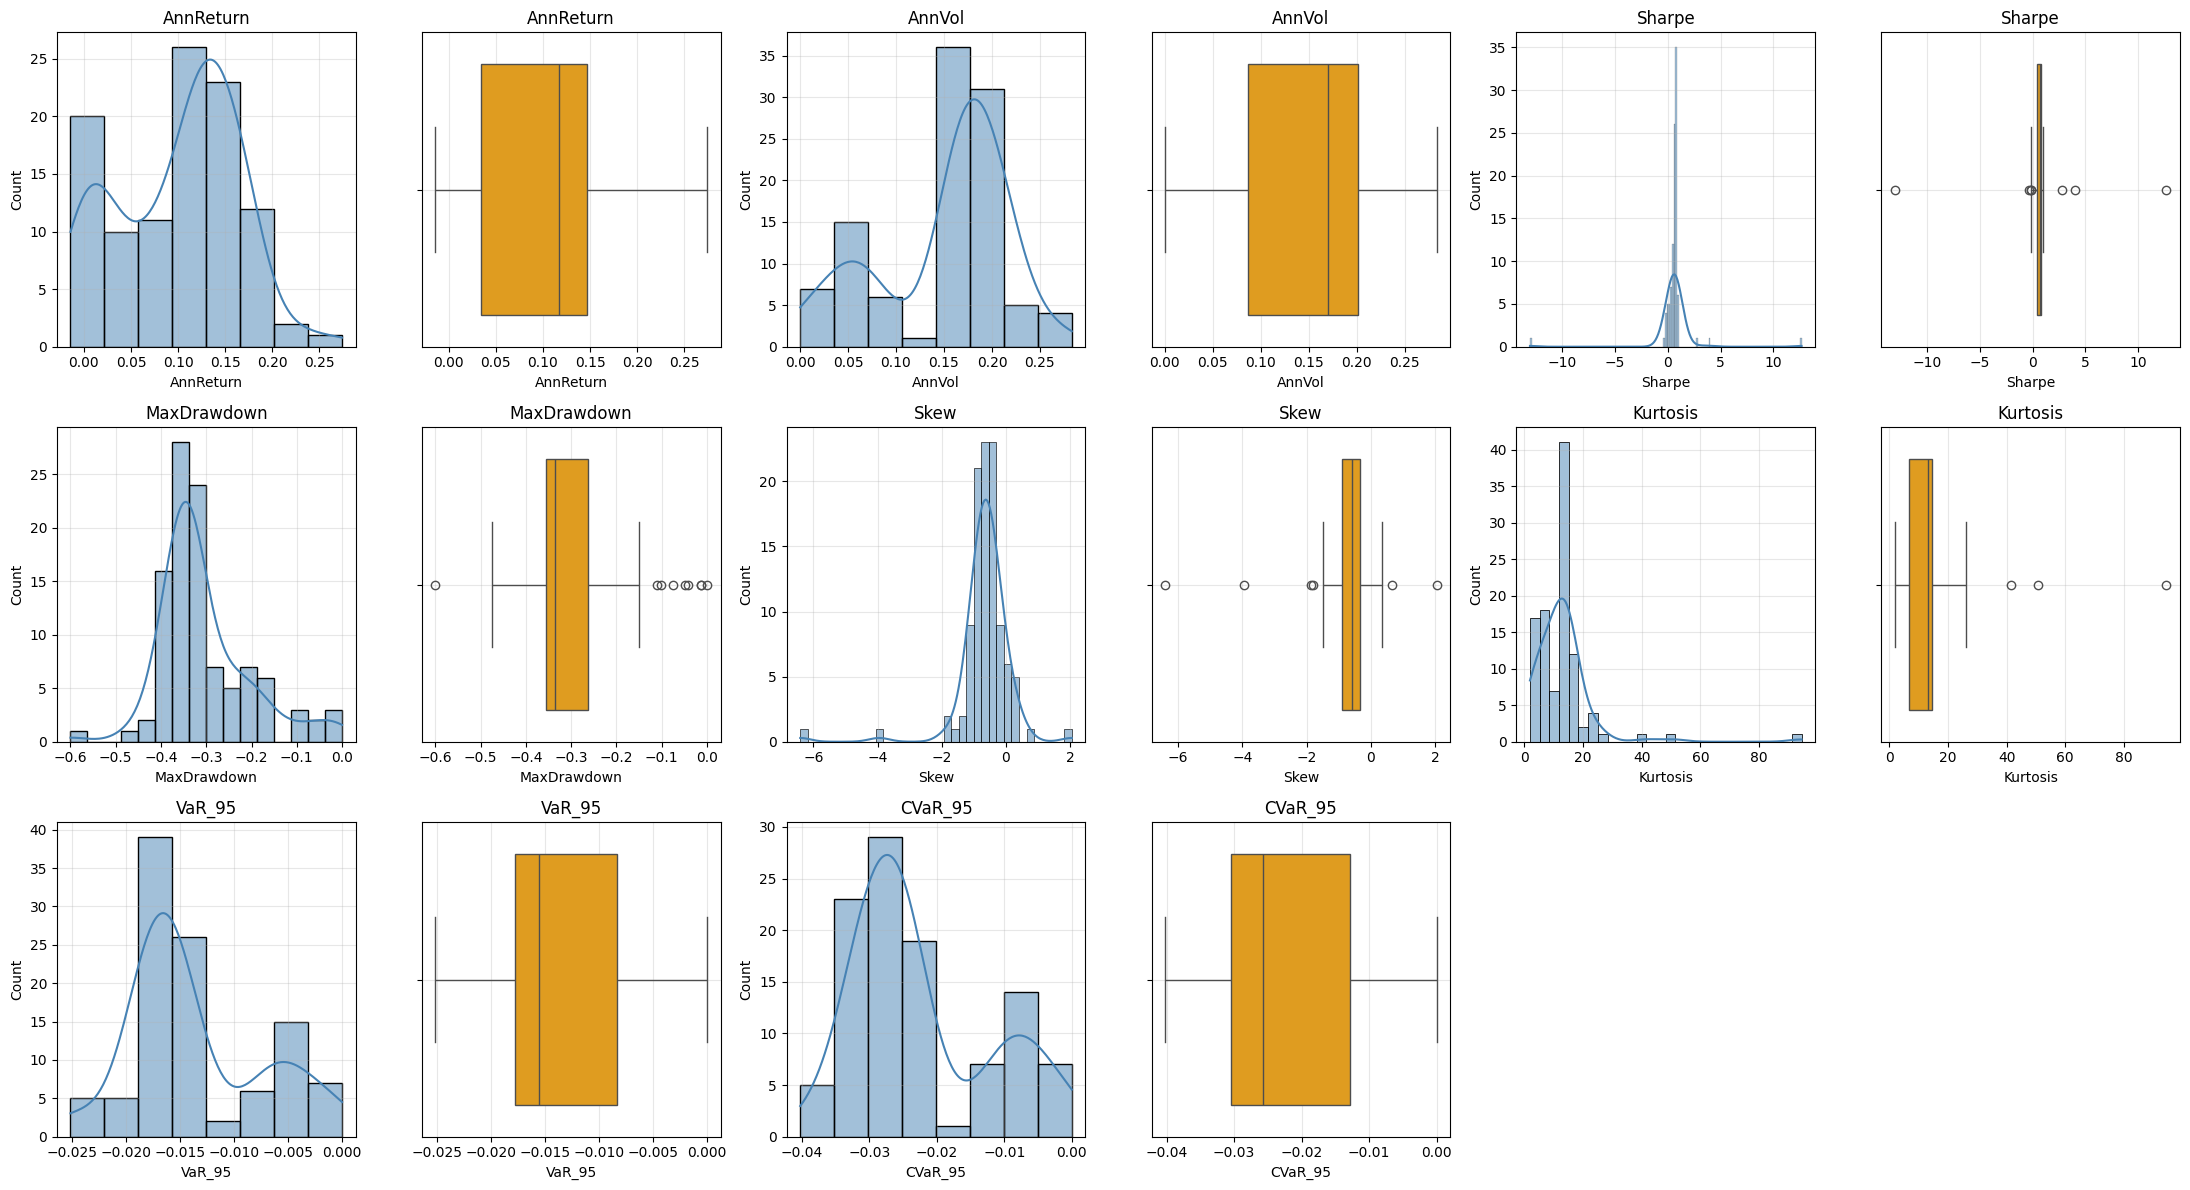

In [12]:
fig, axes = plt.subplots(3, 6, figsize=(22, 12))
axes = axes.flatten()
plot_idx = 0

for metric in etf_metrics.columns:
    data = etf_metrics[metric].dropna()

    # Histogram
    ax_hist = axes[plot_idx]
    sns.histplot(data, kde=True, ax=ax_hist, color="steelblue")
    ax_hist.set_title(f"{metric}")
    ax_hist.grid(True, alpha=0.3)
    plot_idx += 1

    # Boxplot
    ax_box = axes[plot_idx]
    sns.boxplot(x=data, ax=ax_box, color="orange")
    ax_box.set_title(f"{metric}")
    ax_box.grid(True, alpha=0.3)
    plot_idx += 1

# Hide the remaining empty axes
for ax in axes[plot_idx:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

## Pairwise Relationships Between ETF Metrics

The pairplot shows how ETF risk and performance metrics behave individually and relative to each other.

<br>

### 1. Individual Distributions (Diagonal)

- Annualized Return & Volatility: The distributions are irregular and sometimes bimodal, suggesting that ETFs fall into different groups (e.g. low-risk vs high-risk assets).

- Sharpe Ratio are tightly clustered around 0, meaning most ETFs deliver limited risk-adjusted performance. Only a few stand out positively or negatively.

- VaR and CVaR: Both are centered on negative values, confirming that downside risk is a common feature across ETFs.

- Skewness & Kurtosis: Skewness is often negative, and kurtosis is high for many ETFs. This indicates asymmetric returns and frequent extreme events.


<br>


### 2. Relationships Between Metrics (Off-Diagonal)

Risk and Downside Measures Move Together
- Volatility, Max Drawdown, VaR, and CVaR are strongly related
- As volatility increases:
    - Drawdowns become deeper
    - Losses in bad periods become larger
    - These metrics essentially describe the same underlying risk dimension


<br>

### 3. Risk–Return Trade-Off
- Annualized Return vs Volatility shows a positive relationship
- ETFs with higher expected returns generally come with higher risk

<br>

ETF risk is multi-dimensional:
- One dimension captures overall risk and losses
- Another captures tail behavior and non-normality
- Many metrics are redundant, but some (skewness, kurtosis) add unique insights
- This structure could justify dimensionality reduction or clustering to classify ETFs effectively

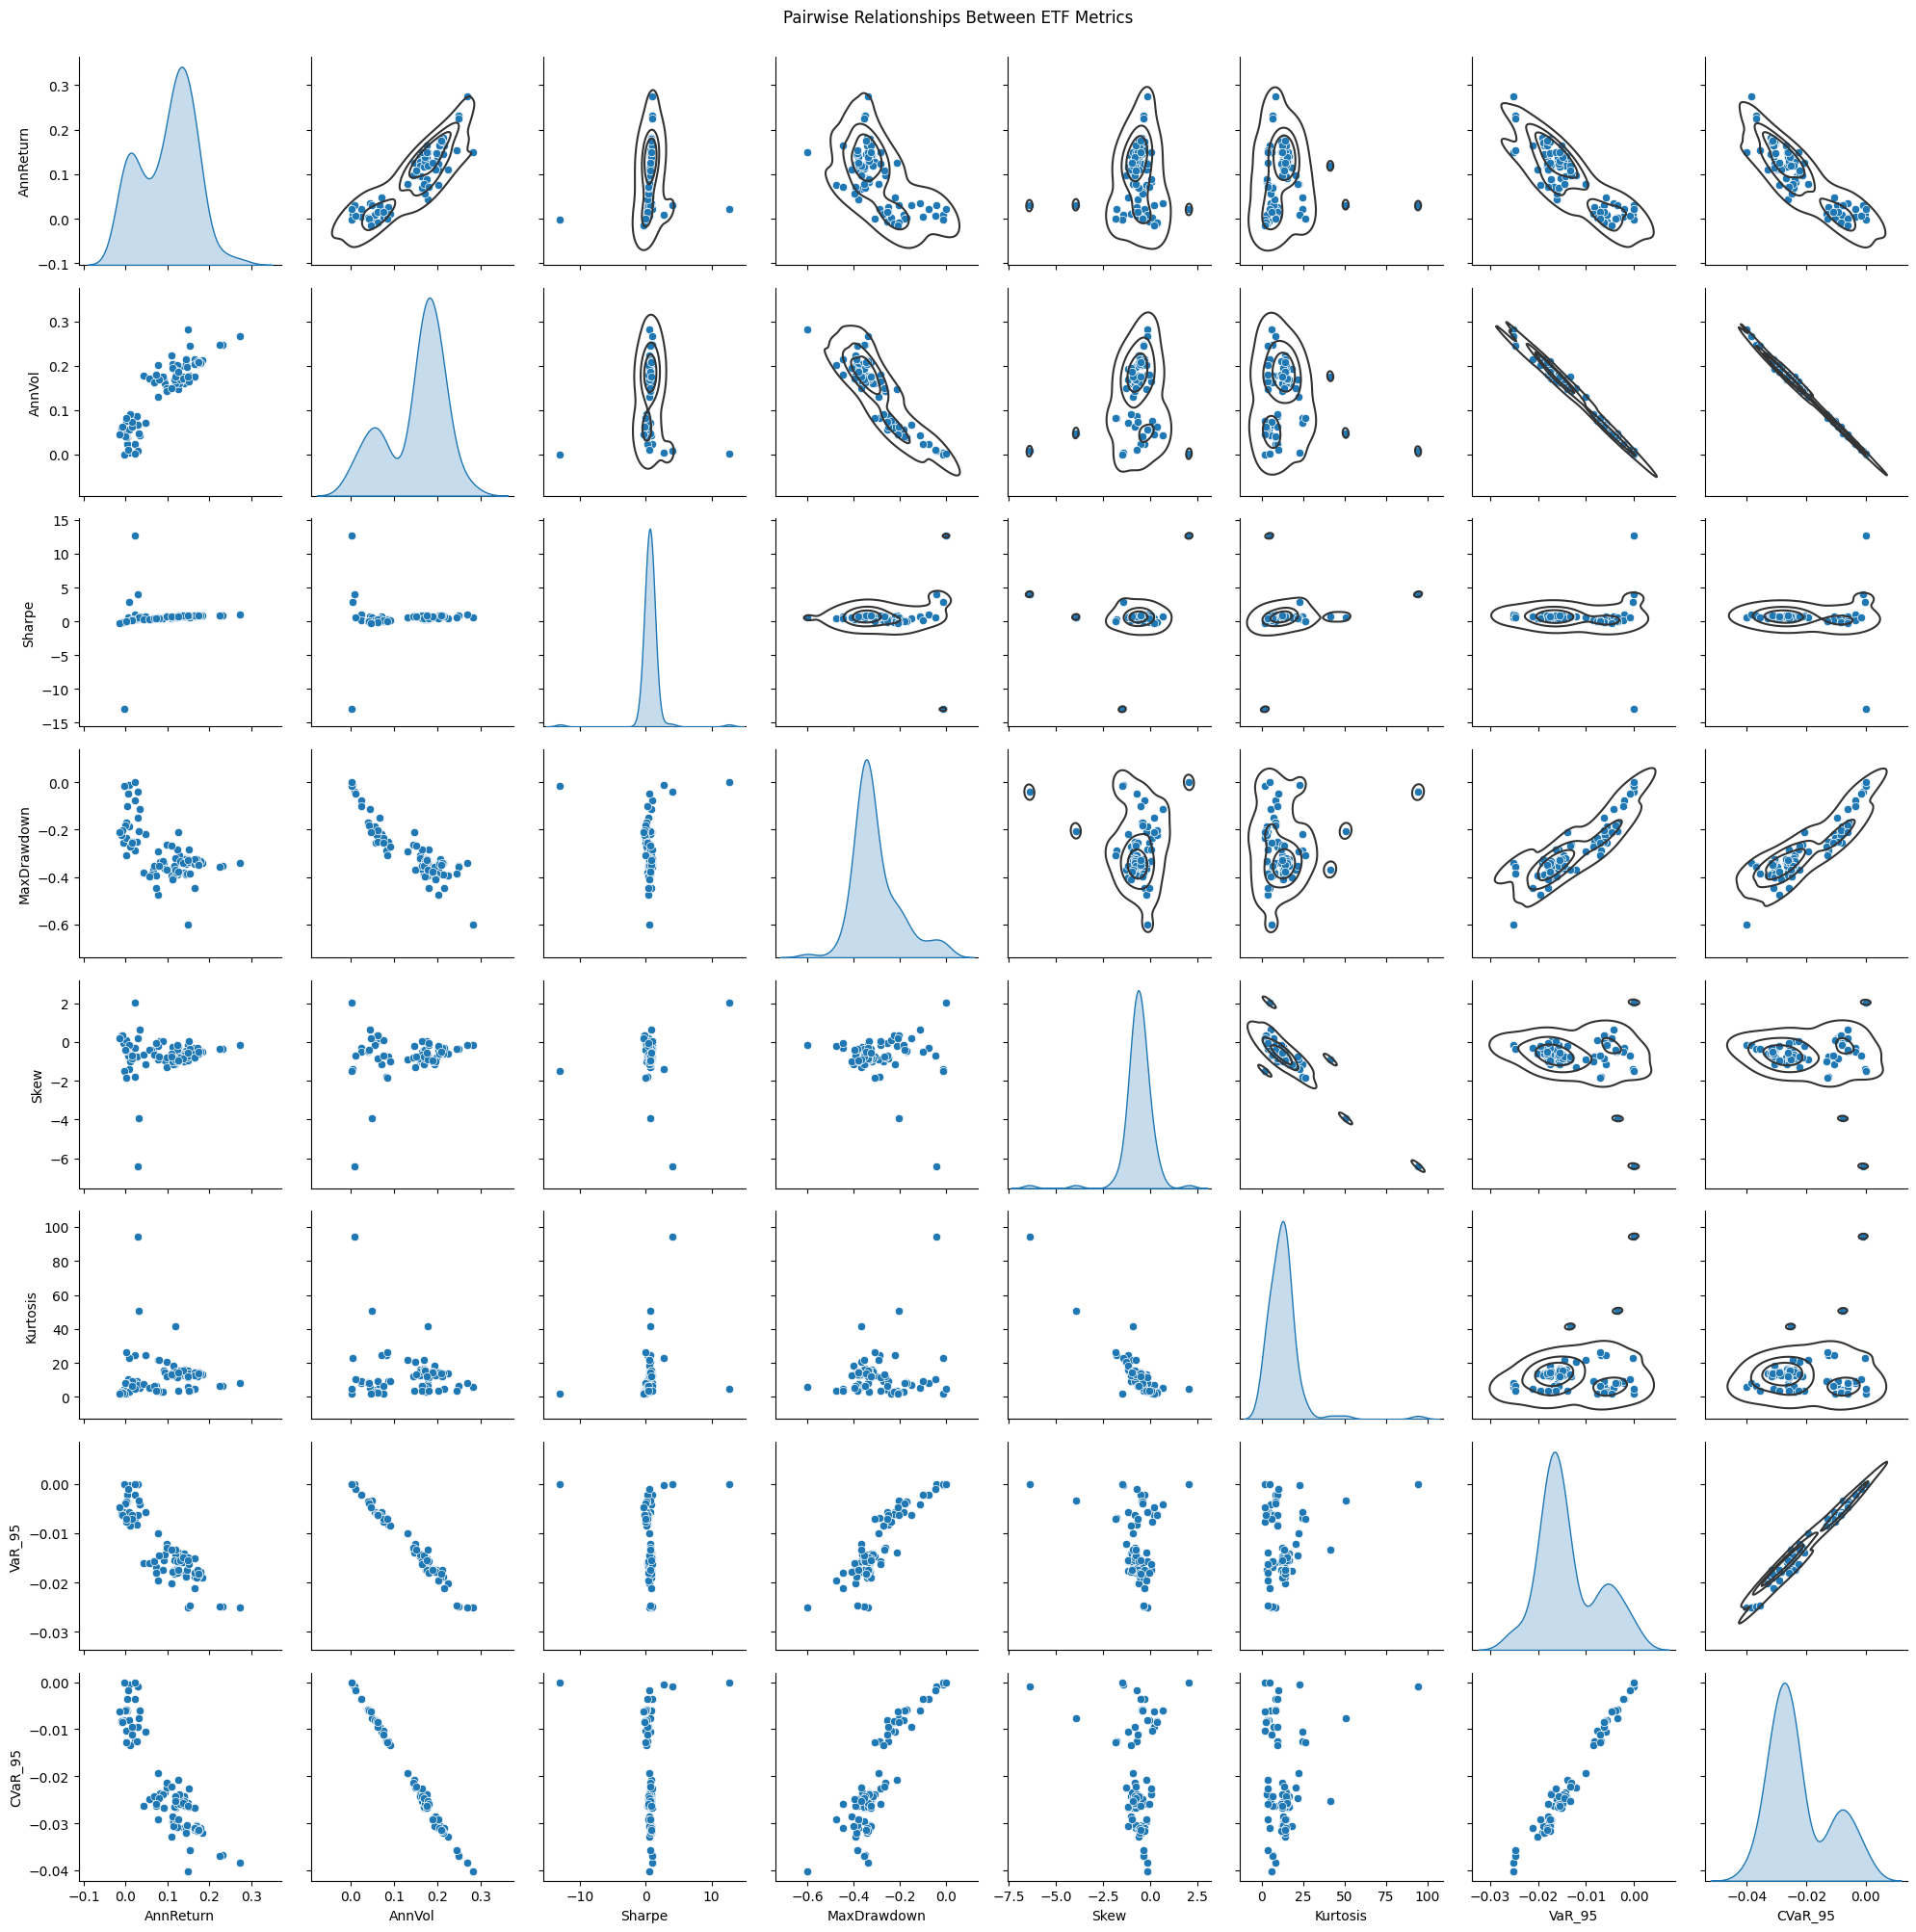

In [13]:
g = sns.pairplot(etf_metrics, diag_kind="kde")
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.suptitle("Pairwise Relationships Between ETF Metrics", y=1.001)
plt.tight_layout()
plt.show()

## Clustered Correlation Matrix of Returns

The clustered heatmap shows the pairwise correlations of daily returns across the 105 ETFs. By grouping ETFs with similar return patterns, the visualization highlights the underlying structure of the ETF universe.

- Most ETFs exhibit strong positive correlations with each other.
- Large red/orange areas indicate that many ETFs tend to move in the same direction on a daily basis.
- This suggests a strong influence of common market factors, such as global equity risk.


<br>

### Identification of ETF Clusters

The clustering clearly separates ETFs into distinct groups based on their return behavior:

- Highly Correlated Cluster (Risk / Equity-Oriented ETFs)
    - A large block of ETFs is strongly correlated internally.
    - These ETFs likely track: Major equity indices, Regional equity markets, igh-beta risk assets
    - ETFs in this cluster offer limited diversification among themselves, as they respond similarly to market movements.

- Lower or Negatively Correlated Cluster (Defensive / Diversifying ETFs)
    - A smaller but clearly distinct cluster shows weaker or negative correlations.
    - These ETFs are likely linked to: Fixed income markets, Credit instruments, Gold or commodities
    - Their return dynamics differ from equity markets, making them valuable for diversification.



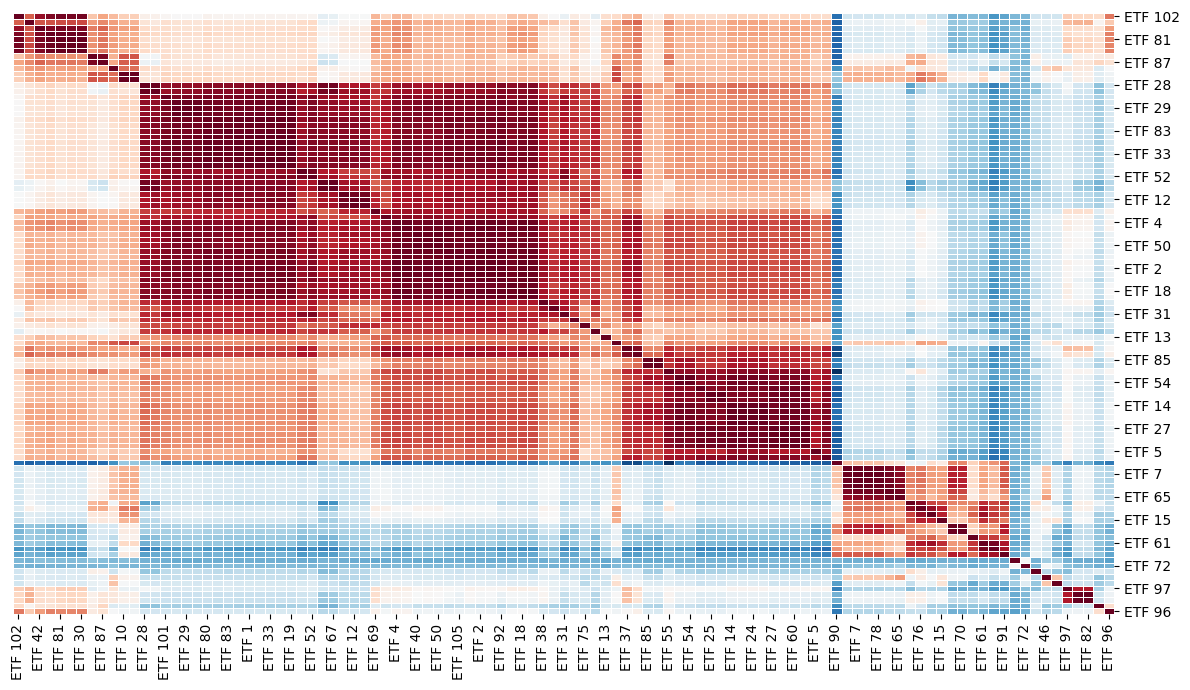

In [90]:
sns.clustermap(
    etf_rets.corr(), cmap='RdBu_r',
    linewidths=0.5, figsize=(12, 7),
    dendrogram_ratio=0., cbar_pos=None
)
plt.show()

## PCA Projection of ETFs

We applied Principal Component Analysis (PCA) to the standardized ETF risk and performance metrics to reduce dimensionality and identify the main drivers of differences across ETFs.


In [15]:
# Standardize
X = etf_metrics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
def plot_pca_results(pca, metrics_list):
    n = pca.n_components_
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    print(f"Explained Variance : {explained_variance}\n")
    print(f"Cumulative Variance : {cumulative_variance}\n")

    # Loadings: contribution of each original variable to PCs
    loadings = pd.DataFrame(
        pca.components_.T,
        index=metrics_list,
        columns=[f"PC{i+1}" for i in range(n)]
    )
    print("Loadings:")
    print(display(loadings.T))

    # Scree Plot + Cumulative Variance
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].bar(range(1, n+1), explained_variance, alpha=0.7, label='Individual')
    axes[0].plot(range(1, n+1), cumulative_variance, color='red', marker='o', label='Cumulative')
    axes[0].set_title("Explained Variance")
    axes[0].set_xticks(range(1, n+1))
    axes[0].set_xticklabels([f"PC{i}" for i in range(1, n+1)])
    axes[0].grid(True)
    axes[0].legend(loc='best')

    # Heatmap of Loadings
    sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("PCA Loadings (Contribution of Each Metric to PCs)")
    plt.tight_layout()
    plt.show()

In [17]:
def pca_n_dim_df(n_components, X_scaled, metrics_list):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    cols = [f"PC{i+1}" for i in range(n_components)]
    pca_df = pd.DataFrame(X_pca, columns=cols, index=X.index)

    plot_pca_results(pca, metrics_list)
    return pca_df, pca

### 1. Interpretation of PCA Results (2D)

- PC1 (57.5% of variance) represents a global risk–return axis.
    - ETFs with high volatility, large drawdowns, and severe tail losses (VaR, CVaR) score strongly on this component.
    - It effectively separates riskier ETFs from more defensive ones.

- PC2 (23.3% of variance) captures distributional characteristics of returns, mainly driven by Kurtosis and Skewness.
    - This dimension distinguishes ETFs exposed to fat tails and asymmetric risks, which are not visible through volatility alone.


Together, the first two components explain 80.8% of total variance, showing that ETF behavior can largely be summarized by:
- Overall risk exposure
- Non-normality and tail behavior of returns



Explained Variance : [0.57529616 0.23287543]

Cumulative Variance : [0.57529616 0.80817159]

Loadings:


AnnReturn    AnnVol    Sharpe  MaxDrawdown      Skew  Kurtosis    VaR_95  \
PC1   0.412327  0.464283  0.029741    -0.415802  0.081897 -0.074358 -0.462478   
PC2   0.123792  0.039760  0.093256    -0.024208 -0.685157  0.707942 -0.000551   

      CVaR_95  
PC1 -0.463173  
PC2 -0.056473

None


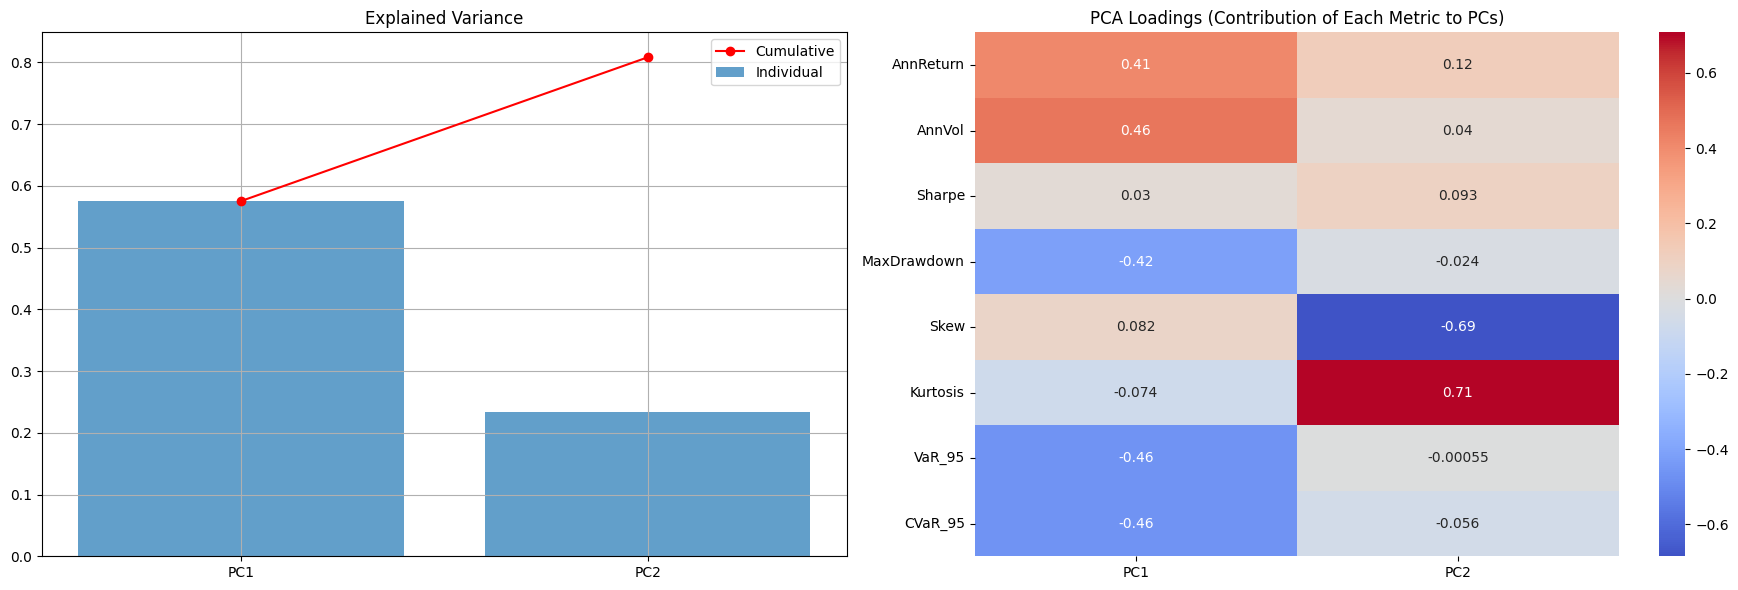

In [18]:
# PCA 2D
pca_2d_df, pca_2d = pca_n_dim_df(2, X_scaled, metrics_list)

### 2. Interpretation of PCA Results (3D)

Extending the analysis to three principal components provides a more complete and interpretable representation of the ETF universe.

Explained Variance:
- PC1 (57.5%) continues to capture the overall risk–return magnitude, separating risky ETFs from defensive ones.
- PC2 (23.3%) captures distributional characteristics, mainly tail risk and asymmetry.
- PC3 (13.3%) adds a new and important dimension related to risk-adjusted performance.

Together, the first three components explain 94.1% of total variance, meaning that almost all relevant information contained in the eight original metrics is preserved in a 3D space.

<br>

### Role of the Third Component (PC3)

The third principal component is almost entirely driven by the Sharpe ratio:
- The Sharpe ratio has a very high loading (≈ 0.95) on PC3.
- All other metrics contribute only marginally to this component.

This indicates that risk-adjusted performance is largely independent from:
- the overall level of risk (PC1), and
- the shape of return distributions and tail risk (PC2).

As a result, 2 ETFs with similar volatility and drawdown profiles can still be clearly differentiated by PC3 if one delivers better returns per unit of risk.

<br>

### Economic Interpretation of the 3D Structure

The 3D PCA organizes ETFs along three intuitive and complementary axes:
- PC1: How risky the ETF is overall
- PC2: How extreme and asymmetric its returns can be
- PC3: How efficiently the ETF converts risk into returns


Explained Variance : [0.57529616 0.23287543 0.13311739]

Cumulative Variance : [0.57529616 0.80817159 0.94128898]

Loadings:


AnnReturn    AnnVol    Sharpe  MaxDrawdown      Skew  Kurtosis    VaR_95  \
PC1   0.412327  0.464283  0.029741    -0.415802  0.081897 -0.074358 -0.462478   
PC2   0.123792  0.039760  0.093256    -0.024208 -0.685157  0.707942 -0.000551   
PC3   0.098203 -0.017884  0.951565     0.124690  0.241510  0.098165  0.024829   

      CVaR_95  
PC1 -0.463173  
PC2 -0.056473  
PC3  0.020812

None


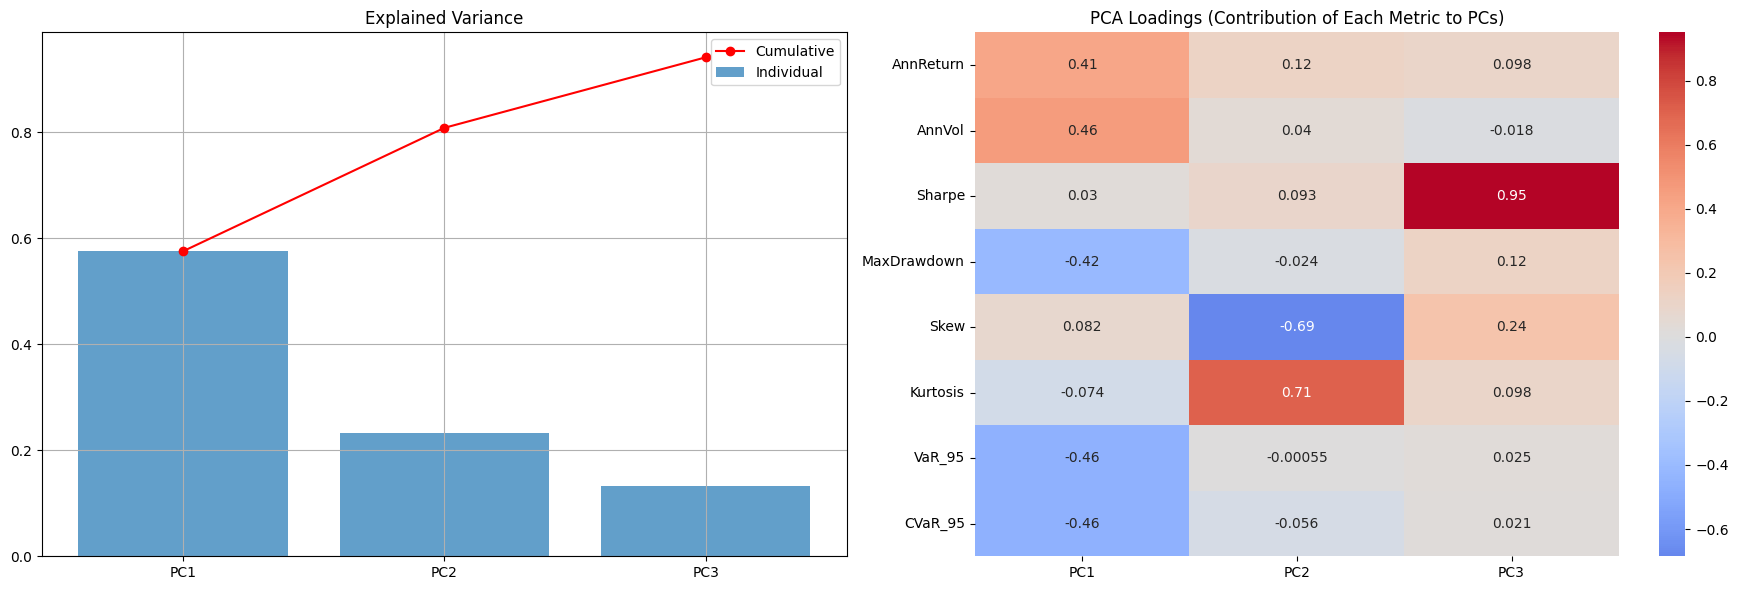

In [19]:
# PCA 3D
pca_3d_df, pca_3d = pca_n_dim_df(3, X_scaled, metrics_list)

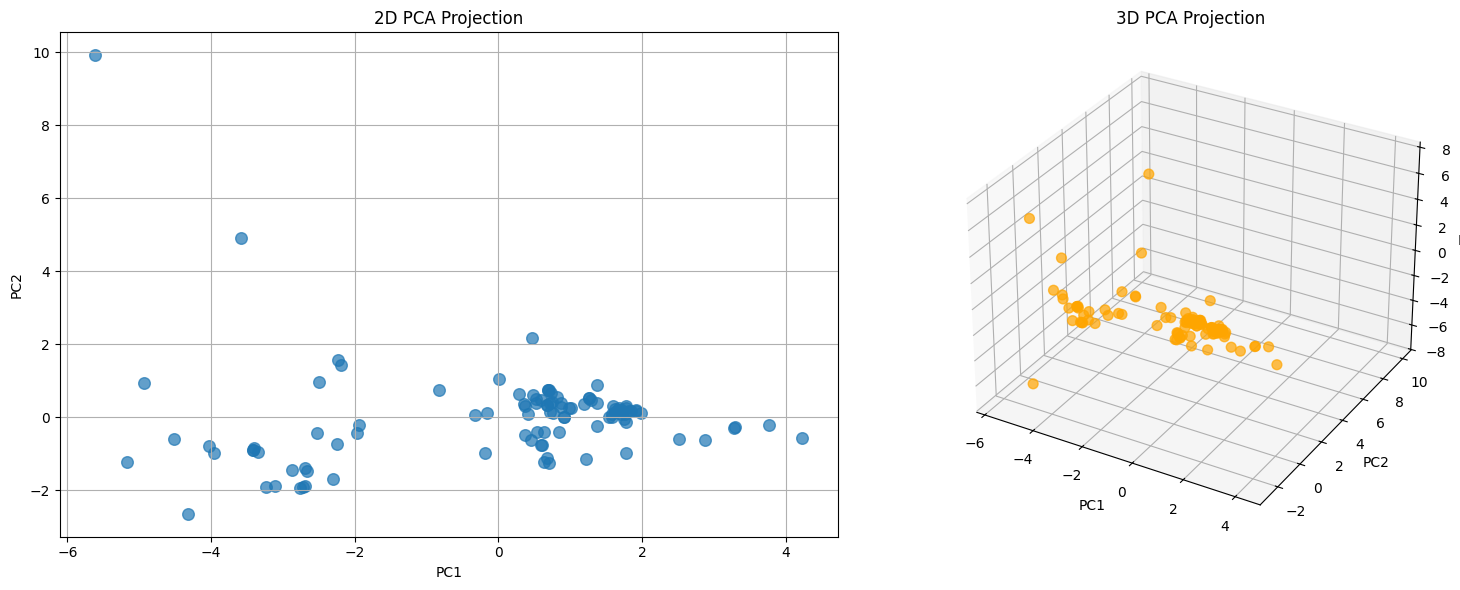

In [20]:
fig = plt.figure(figsize=(16, 6))

# 2D PCA
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(pca_2d_df["PC1"], pca_2d_df["PC2"], s=70, alpha=0.7)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title("2D PCA Projection")
ax1.grid(True)

# 3D PCA
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(pca_3d_df["PC1"], pca_3d_df["PC2"], pca_3d_df["PC3"], color="orange", s=50, alpha=0.7)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.set_title("3D PCA Projection")
plt.tight_layout()
plt.show()



### 3. Interpretation of Higher-Order Components (PC4–PC8)

Running PCA with all 8 principal components allows us to fully decompose the variance contained in the original eight ETF metrics.
- From the 5th principal component onward, each additional component contributes less than 1% of incremental variance.
- This behavior clearly reveals a variance plateau starting around PC4–PC5, meaning that higher-order components mainly capture noise or very specific effects rather than meaningful common structure.

<br>

### 4. Model Selection Justification

Given that:
- PC1, PC2, and PC3 already explain ~94% of the variance, and
- additional components bring very limited explanatory power,

we chose to retain only three principal components for the remainder of the analysis.


Explained Variance : [5.75296160e-01 2.32875431e-01 1.33117391e-01 4.46820776e-02
 8.41506644e-03 4.40729051e-03 1.04120930e-03 1.65374168e-04]

Cumulative Variance : [0.57529616 0.80817159 0.94128898 0.98597106 0.99438613 0.99879342
 0.99983463 1.        ]

Loadings:


AnnReturn    AnnVol    Sharpe  MaxDrawdown      Skew  Kurtosis    VaR_95  \
PC1   0.412327  0.464283  0.029741    -0.415802  0.081897 -0.074358 -0.462478   
PC2   0.123792  0.039760  0.093256    -0.024208 -0.685157  0.707942 -0.000551   
PC3   0.098203 -0.017884  0.951565     0.124690  0.241510  0.098165  0.024829   
PC4   0.684144  0.010073 -0.184258     0.700232  0.084217  0.008125  0.009953   
PC5  -0.025737  0.078845 -0.221229    -0.125795  0.664777  0.665291  0.205529   
PC6   0.563863 -0.296152  0.014899    -0.537160 -0.047797 -0.131446  0.492002   
PC7   0.134794 -0.157427 -0.037053    -0.125151  0.094780  0.133592 -0.641640   
PC8  -0.013815  0.814698  0.021332     0.024947 -0.072369 -0.076474  0.298978   

      CVaR_95  
PC1 -0.463173  
PC2 -0.056473  
PC3  0.020812  
PC4 -0.017661  
PC5 -0.039636  
PC6  0.209668  
PC7  0.708152  
PC8  0.484278

None


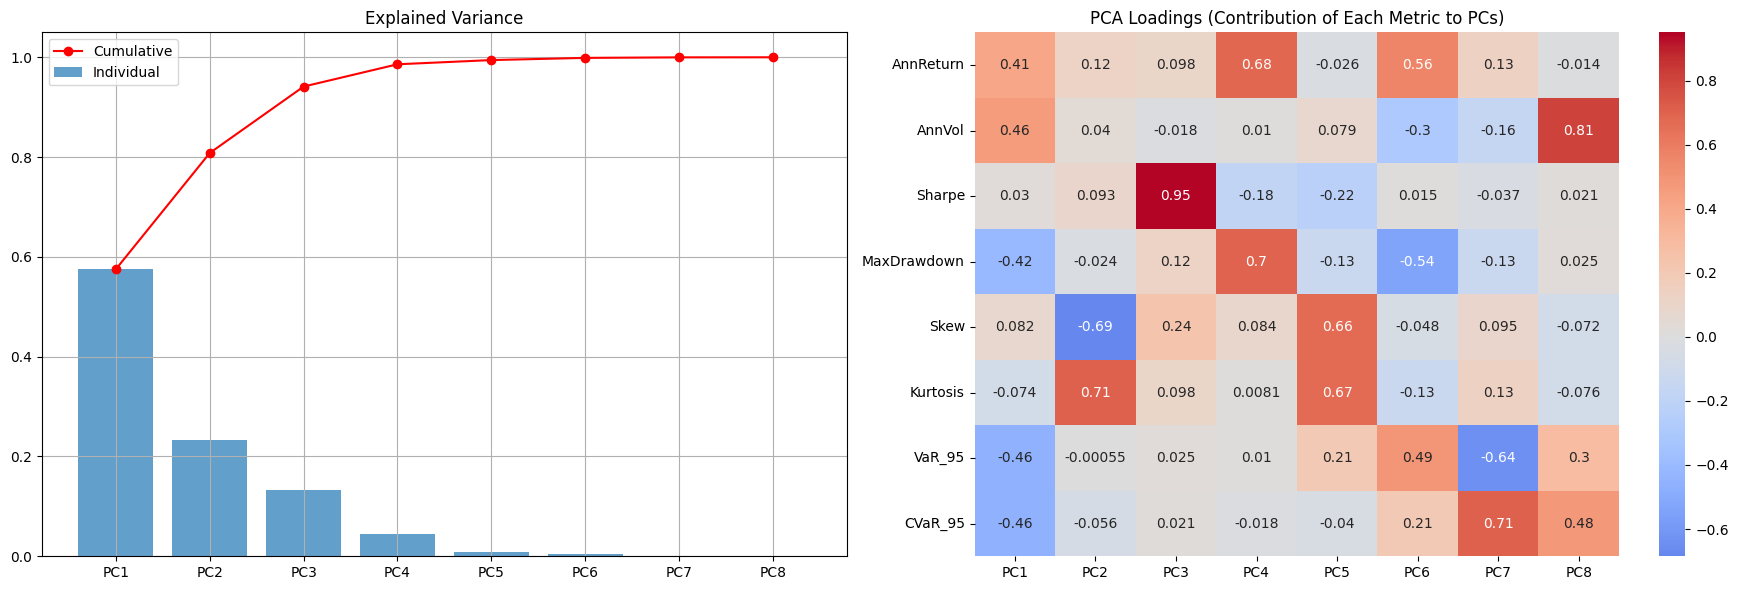

In [21]:
# PCA 8D
pca_8d_df, pca_8d = pca_n_dim_df(8, X_scaled, metrics_list)

## Agglomarative Hierarchical Clustering of ETFs (based on risk-metrics)

The dendrogram visualization (using Ward linkage) confirms the natural grouping structure among the ETFs based on their risk and performance metrics.

<br>

3 main clusters emerge naturally from the dendrogram.
- The largest cluster groups ETFs with standard risk/return profiles.
- A second cluster separates ETFs with lower risk and milder drawdowns.
- The smallest cluster is clearly distinct, containing ETFs with extreme characteristics, particularly in risk-adjusted performance and return distribution.


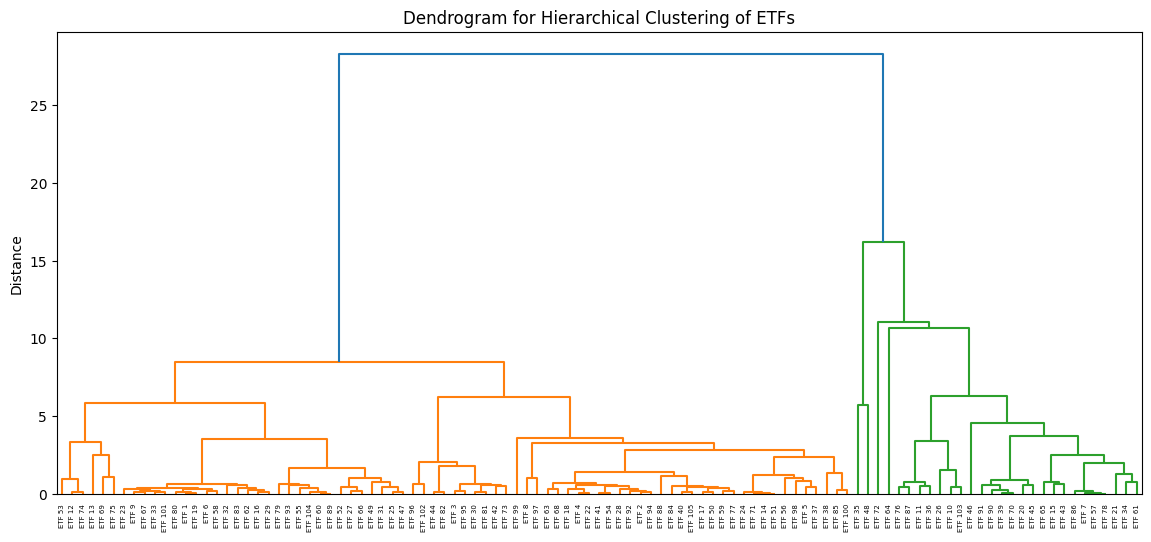

In [22]:
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, labels=X.index, leaf_rotation=90)
plt.title("Dendrogram for Hierarchical Clustering of ETFs")
plt.ylabel("Distance")
plt.show()

### Clustered Pair Plot Analysis

This second plot shows the pair plot of the metrics, where each ETF data point is colored according to its assigned cluster (1, 2, or 3). This visualization highlights the distinguishing characteristics of each cluster across the metrics.

<br>


| Cluster 1 – High Risk/Return | Cluster 2 – Low Risk/Return | Cluster 3 – Outliers / Skewed ETFs |
| :--- | :--- | :--- |
| High Annualized Volatility (up to ~0.25) <br> Severe Max Drawdowns (down to -0.6) | Low volatility (AnnVol < 0.15) and mild drawdowns (~-0.1 to -0.2) | Extreme Sharpe ratios <br> Strong deviations in Skewness and Kurtosis |
| Central Sharpe ratios, strong alignment with major equity indices | VaR and CVaR closer to 0, indicating limited downside | Captures unusual ETFs with  very high <br> or negative risk-adjusted performance |
| Represents typical high-risk, high-return ETFs | Likely composed of fixed-income or low-volatility ETFs | Reflects non-normal return distributions |

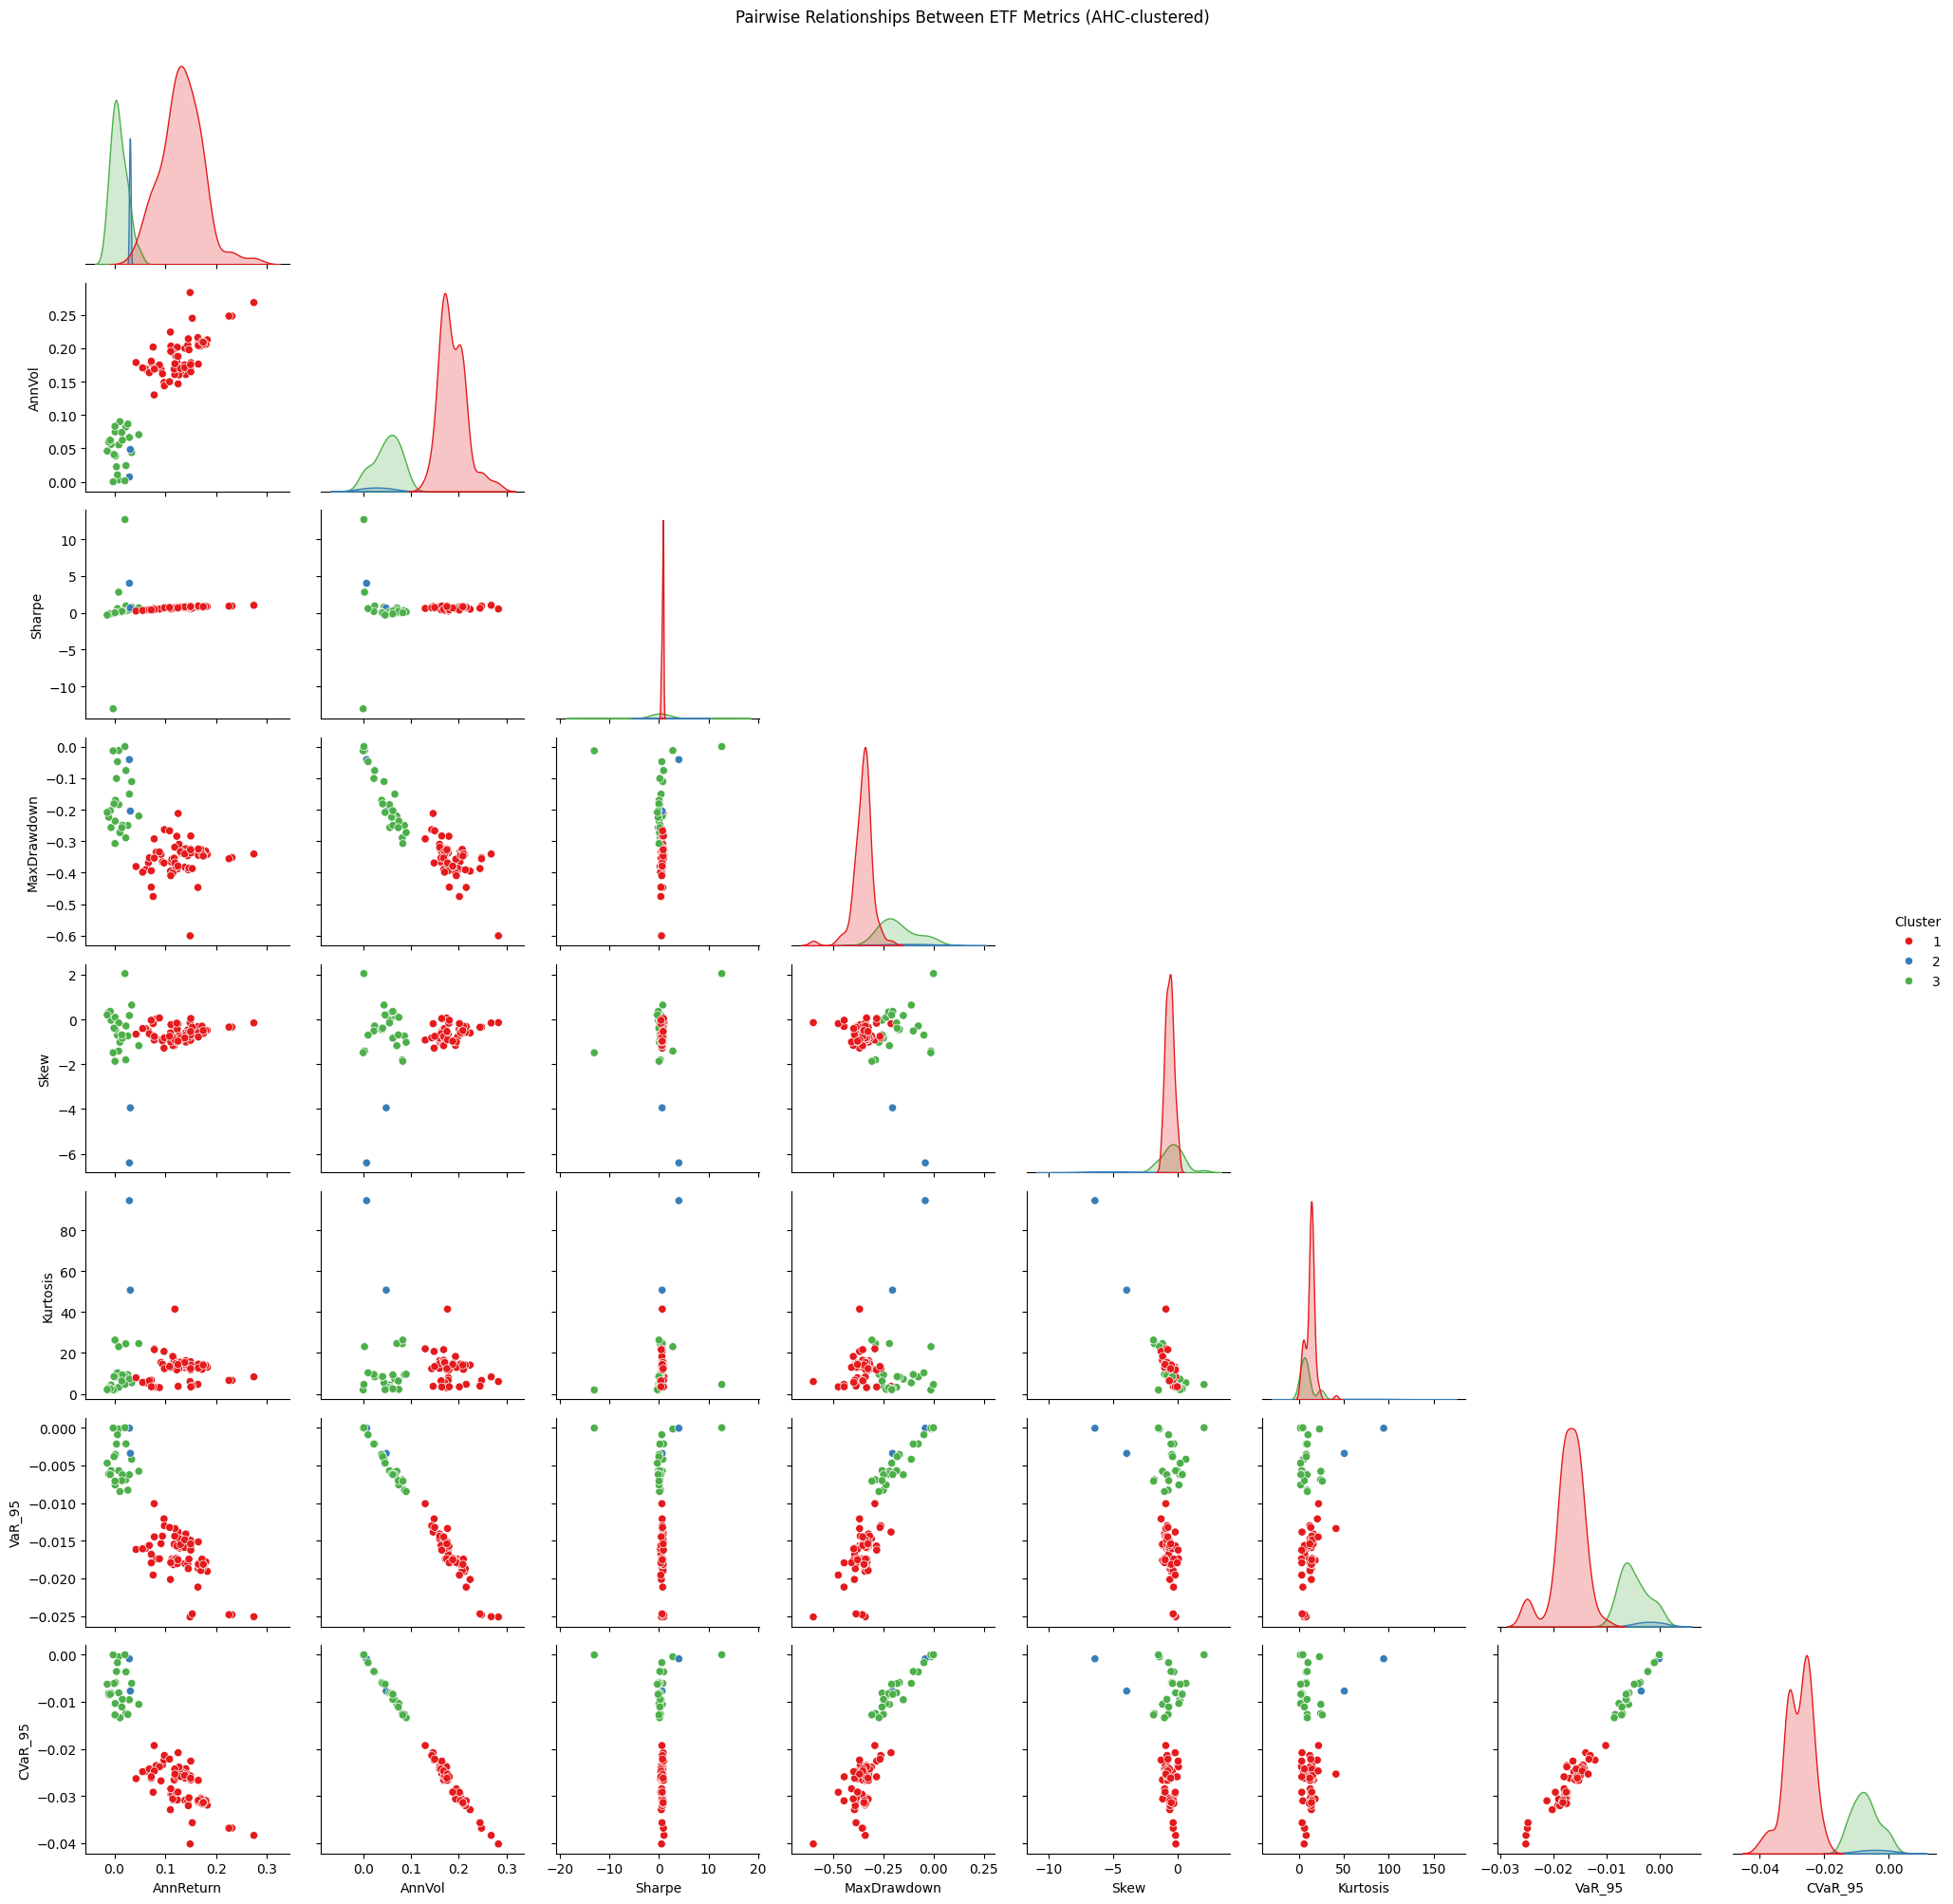

In [23]:
max_clusters = 3
clusters = fcluster(linkage_matrix, t=max_clusters, criterion='maxclust')

etf_ahc_clusters = etf_metrics.copy()
etf_ahc_clusters['Cluster'] = clusters

sns.pairplot(etf_ahc_clusters, diag_kind="kde", hue="Cluster", corner=True, palette="Set1")
plt.suptitle("Pairwise Relationships Between ETF Metrics (AHC-clustered)", y=1.001)
plt.tight_layout()
plt.show()

## KMeans Clustering of ETFs (based on risk-metrics)

The K-Means clustering analysis complements the previous hierarchical clustering by confirming the presence of 3 natural clusters within the ETF universe.
- Cluster 2 = main high-risk/high-return group
- Cluster 1 = conservative low-risk group
- Cluster 0 = isolated outliers with unusual distributional characteristics

<br>

### 1. Elbow Method

The inertia drops sharply from k=1 to k=3, forming a clear "elbow" after which further reduction is minimal.
- This validates k=3 as the optimal number of clusters, aligning with the hierarchical clustering result and capturing most of the structure without overfitting


<br>

### 2. PCA Projection of K-Means Clusters

The 2D scatter plot on PC1 (Risk/Return Magnitude) vs. PC2 (Distribution Shape) shows clear separation:


| Cluster | Interpretation |
|---------|----------------|
| Cluster 2 (Green) | High Risk/High Return ETFs, mostly equity-tracking ETFs with strong correlation to major indices. |
| Cluster 1 (Orange) | Low Risk/Low Return ETFs, likely fixed-income or low-volatility strategies. |
| Cluster 0 (Blue Outliers)  | Outliers / Skewed ETFs, characterized by extreme skewness/kurtosis or unusual risk-return profiles (leveraged, inverse, or niche ETFs). |

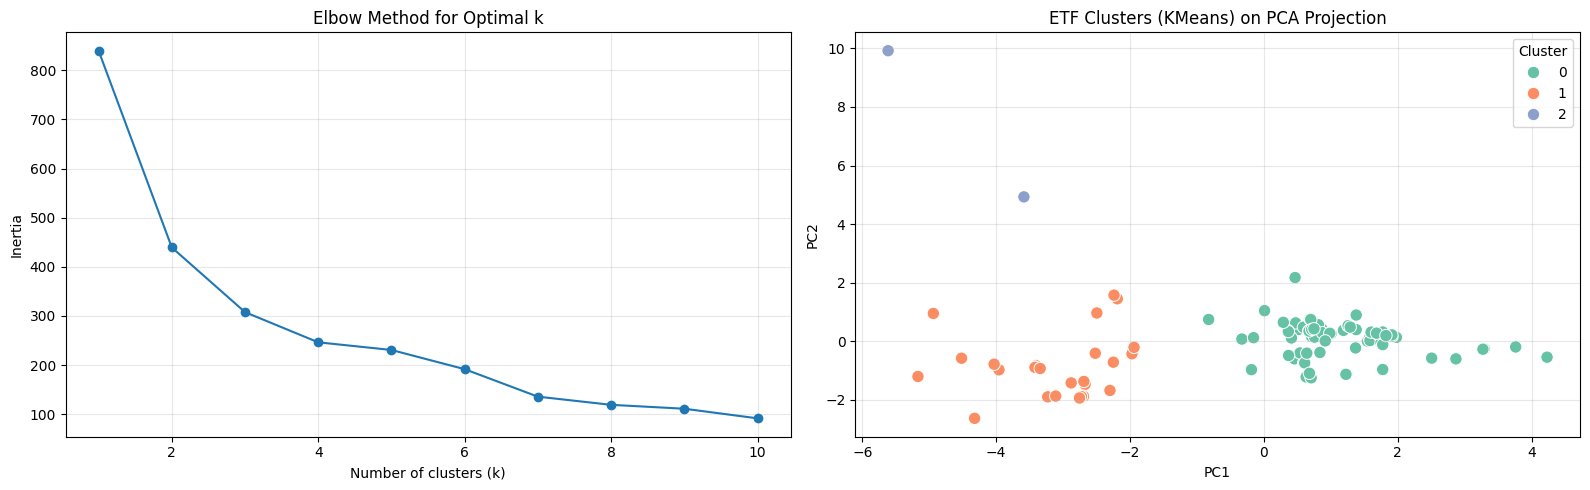

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow Curve
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
axes[0].plot(K, inertia, 'o-')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# PCA Projection with KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
etf_metrics['Cluster'] = clusters

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_2d, columns=['PC1', 'PC2'], index=X.index)
pca_df['Cluster'] = clusters

sns.scatterplot(
    data=pca_df, x='PC1', y='PC2',
    hue='Cluster', palette='Set2', s=80, ax=axes[1]
)
axes[1].set_title('ETF Clusters (KMeans) on PCA Projection')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusion – Classification of ETFs

The analysis of 105 ETFs using performance and risk metrics allowed for a clear classification based on their risk-return profiles, distributional characteristics, and downside exposure. Both Agglomerative Hierarchical Clustering (AHC) and K-Means clustering consistently identified three distinct groups:

1. **High Risk/High Return ETFs**: typically equity-focused, with elevated volatility and drawdowns.  
2. **Low Risk/Low Return ETFs**: generally fixed-income or low-volatility strategies with limited downside.  
3. **Outliers / Skewed ETFs**: ETFs with extreme risk-adjusted performance or non-normal return distributions.  

_________

# II. Relationships between ETFs and main assets classes

In [25]:
main_assets = pd.read_csv("Main Asset Classes.csv", skiprows=4, index_col=0, parse_dates=True)
main_assets = main_assets.iloc[1:, :]
main_assets.index = pd.to_datetime(main_assets.index, dayfirst=True)
main_assets = main_assets.astype(float)

main_asset_rets = main_assets.pct_change().dropna()
main_assets_list = main_assets.columns.tolist()
print(main_asset_rets.shape)
main_assets.head()

(1667, 14)


S&P 500  Nasdaq 100  US Small Caps  Euro Stoxx 50  UK FTSE  \
2018-01-01  4672.65     7256.87      7554.1651        7048.52  6519.85   
2018-01-02  4711.60     7387.98      7625.7417        7020.80  6486.20   
2018-01-03  4741.75     7461.12      7638.4702        7060.42  6505.71   
2018-01-04  4761.55     7472.49      7654.2279        7179.11  6527.28   
2018-01-05  4795.03     7550.47      7675.4522        7257.05  6551.31   

            MSCI EM    Japan      US IG     US HY     EU IG     EU HY  \
2018-01-01  521.047  35413.76  282.4644  269.1327  226.5210  192.4179   
2018-01-02  530.304  35413.76  280.7632  269.4638  226.4472  192.5863   
2018-01-03  533.125  35413.76  281.4011  270.2244  226.6925  192.8904   
2018-01-04  536.880  36567.09  281.2786  270.9258  226.7588  193.1619   
2018-01-05  540.695  36890.97  280.8513  271.2983  226.9667  193.2546   

            EM Bond      Gold  Commodity  
2018-01-01  551.774  323.6981   179.9572  
2018-01-02  551.634  325.4313   180.4815  
2018-01-03  552.930  326.0377   180.8937  
2018-01-04  554.020  326.8173   180.8199  
2018-01-05  554.859  327.0035   179.4927

The analysis of the 14 main asset classes provides insight into the underlying exposures driving ETF performance, helping to explain the clustering patterns observed in the previous section.

Equity indices, especially the S&P 500, dominate cumulative returns and show higher volatility with extreme daily returns, which explains why ETFs tracking these assets form the high-risk/high-return cluster. In contrast, Gold and Investment Grade bonds are stable with tight return distributions, contributing to the low-risk ETF clusters.

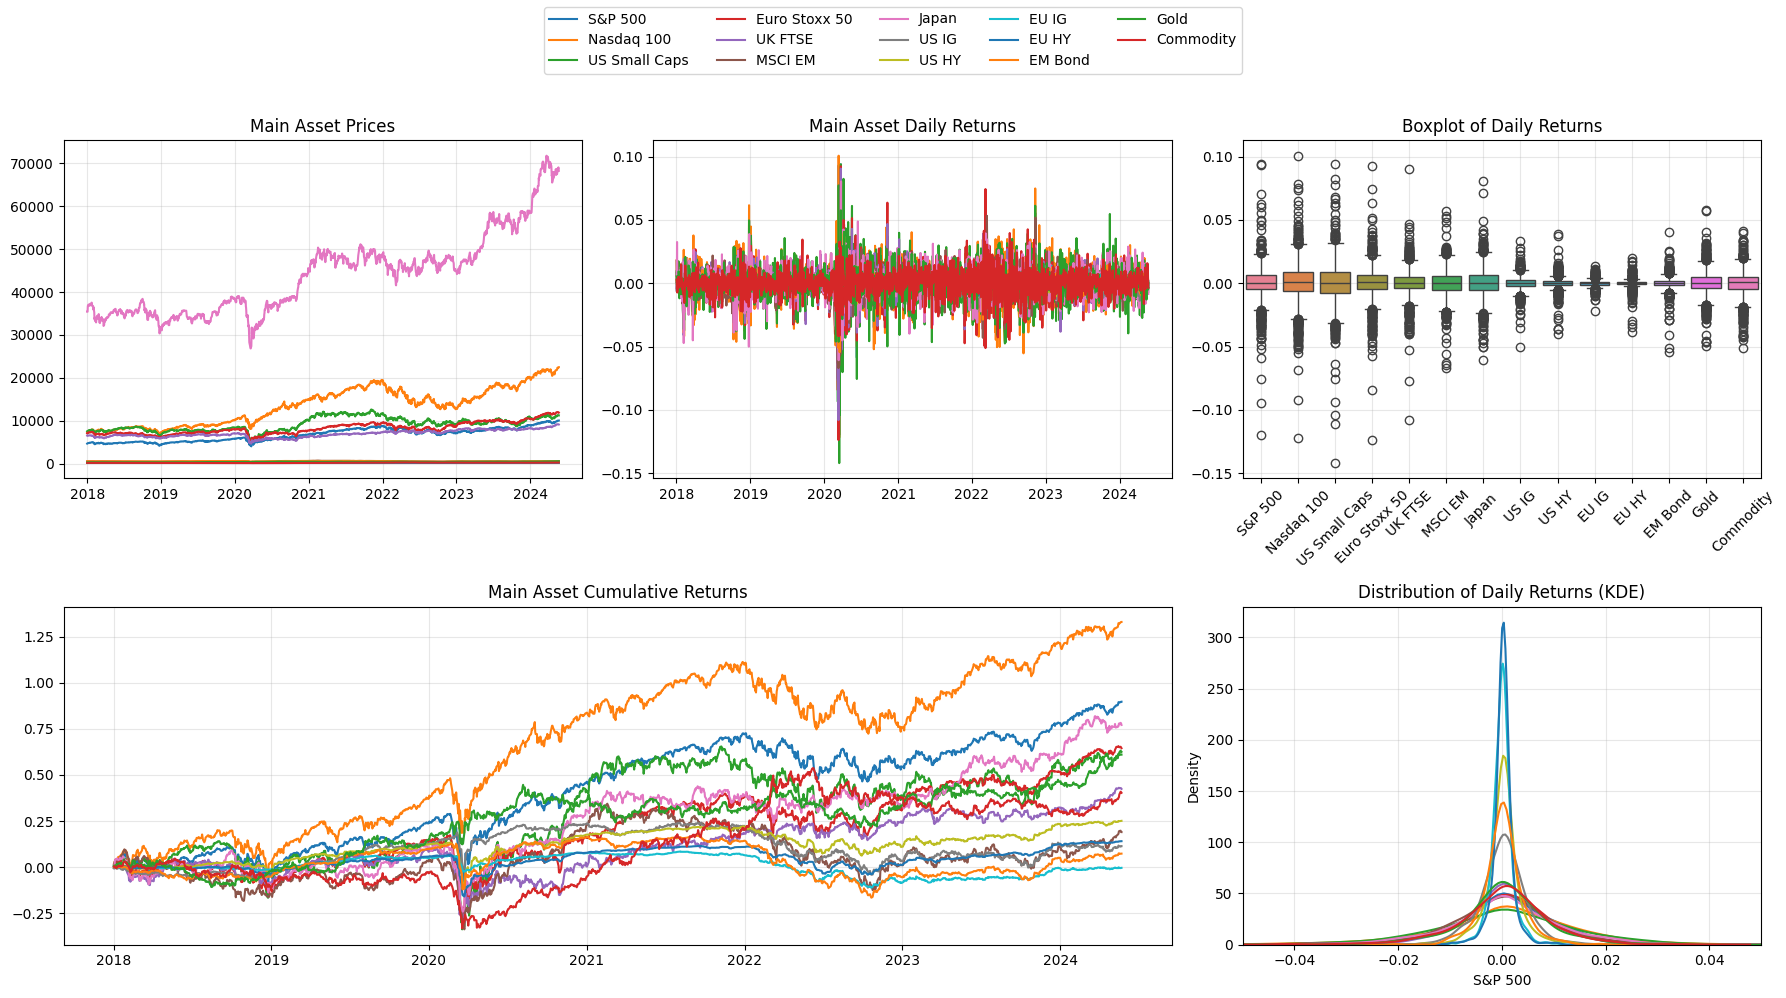

In [26]:
mosaic = [
    ["A", "B", "D"],
    ["C", "C", "E"]
]

fig, axes = plt.subplot_mosaic(mosaic, figsize=(18,  10))
plt.subplots_adjust(hspace=0.9, wspace=0.2)

# Main Asset Prices
for col in main_assets.columns:
    axes["A"].plot(main_assets.index, main_assets[col], label=col)
axes["A"].set_title("Main Asset Prices")
axes["A"].grid(True, alpha=0.3)

# Main Asset Daily Returns
for col in main_asset_rets.columns:
    axes["B"].plot(main_asset_rets.index, main_asset_rets[col], label=col)
axes["B"].set_title("Main Asset Daily Returns")
axes["B"].grid(True, alpha=0.3)

# Main Asset Cumulative Returns
for col in main_asset_rets.columns:
    axes["C"].plot(main_asset_rets.index, main_asset_rets[col].cumsum(), label=col)
axes["C"].set_title("Main Asset Cumulative Returns")
axes["C"].grid(True, alpha=0.3)

# Boxplot of Daily Returns
sns.boxplot(data=main_asset_rets, ax=axes["D"])
axes["D"].set_title("Boxplot of Daily Returns")
axes["D"].set_xticklabels(axes["D"].get_xticklabels(), rotation=45)
axes["D"].grid(True, alpha=0.3)

# KDE plot of Daily Returns
for col in main_asset_rets.columns:
    sns.kdeplot(main_asset_rets[col], ax=axes["E"], label=col)
axes["E"].set_title("Distribution of Daily Returns (KDE)")
axes["E"].grid(True, alpha=0.3)
axes["E"].set_xlim(-0.05, 0.05)
handles, labels = axes["A"].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### Correlation Structure and Clustering

**Equity Cluster (High Positive Correlation):**
- Major equity indices (S&P 500, Nasdaq 100, US Small Caps) are highly correlated (>0.85), forming a dominant cluster.
- European indices and High Yield (US HY, EU HY) are positively correlated, showing that global risk sentiment moves these assets together.
- Impact on ETFs: ETFs tracking these assets naturally group together in the high-risk/high-return cluster (Cluster 1).

**Commodity and Hedge Assets:**
- Gold exhibits near-zero correlation with equity (S&P 500 correlation ~0.03), making it a classic diversification asset.
- Commodity indices maintain modest correlations with equity, retaining unique return characteristics.
- Impact on ETFs: ETFs exposed to Gold or Commodities fall into low-correlation clusters (Cluster 2/3), distinct from equity-dominated ETFs.

**Fixed Income / Credit Segregation:**
- Investment Grade bonds (US IG, EU IG) show low correlation with equities (<0.2), while Emerging Market bonds correlate moderately with equities and EM equity.
- Impact on ETFs: Fixed-income ETFs cluster separately from equity ETFs, supporting diversification and explaining part of Cluster 2’s composition.

<br>

The correlation structure reinforces this: major equities and high-yield bonds are highly correlated, forming a dominant cluster, while commodities and IG bonds are weakly correlated with equities, making them stand out.

Overall, the patterns in prices, returns, and correlations validate the PCA and clustering results, showing that ETF groupings reflect both risk/return magnitude and non-normal or unique return profiles.

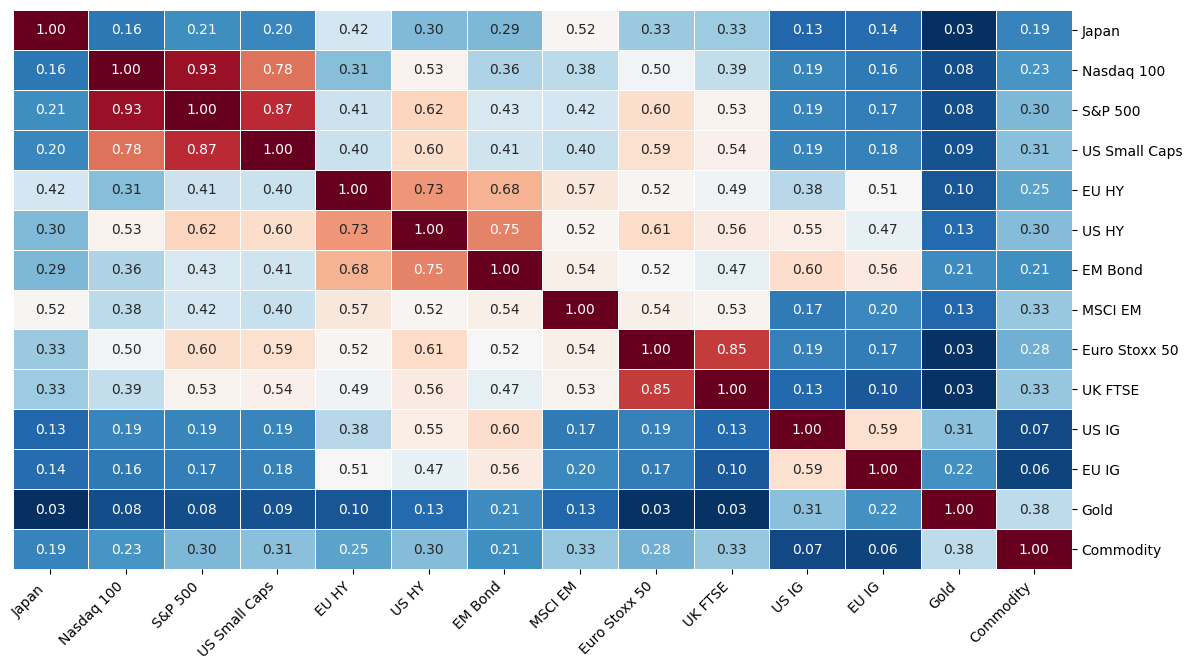

In [27]:
sns.clustermap(
    main_asset_rets.corr(), cmap='RdBu_r',
    linewidths=0.5, figsize=(12, 7), annot=True, fmt=".2f",
    dendrogram_ratio=0., cbar_pos=None
)
plt.xticks(rotation=45, ha="right")
plt.show()

Align ETFs and main assets:

First of all, we align the dates between the ETFs and the main asset classes before doing any analysis
- Sometimes ETFs and main assets might have different date ranges or missing days
- We only want to analyze dates where both ETF and main asset returns available

In [28]:
common_index = etf_rets.index.intersection(main_asset_rets.index)
etf_rets2 = etf_rets.loc[common_index]
main_asset_rets2 = main_asset_rets.loc[common_index]

print(f"Shape of etf_rets2: {etf_rets2.shape}")
print(f"Shape of main_asset_rets2: {main_asset_rets2.shape}")

Shape of etf_rets2: (1404, 105)
Shape of main_asset_rets2: (1404, 14)


## Correlation for each pair ETF–Asset

The asset correlation analysis highlights how individual ETFs relate to the broader set of 14 main asset classes and helps explain their positioning within the ETF universe.

In [29]:
etf_asset_corr = pd.DataFrame(
    {asset: etf_rets2.corrwith(main_asset_rets2[asset])
     for asset in main_asset_rets2.columns}
)

# Identify top correlated asset for each ETF
etf_asset_corr['TopAsset'] = etf_asset_corr.idxmax(axis=1)
etf_asset_corr['MaxCorr'] = etf_asset_corr.iloc[:,:-1].max(axis=1)

etf_asset_corr.head(10)

S&P 500  Nasdaq 100  US Small Caps  Euro Stoxx 50   UK FTSE  \
ETF 1   1.000000    0.932432       0.874493       0.618015  0.559183   
ETF 2   0.970142    0.892318       0.873899       0.743013  0.675191   
ETF 3   0.430133    0.381451       0.411619       0.549935  0.541103   
ETF 4   0.948501    0.868894       0.857189       0.761092  0.696797   
ETF 5   0.559187    0.415521       0.561879       0.856170  1.000000   
ETF 6   0.980034    0.896163       0.881313       0.612480  0.556780   
ETF 7   0.188189    0.174728       0.198401       0.175040  0.107309   
ETF 8   0.130992    0.120401       0.127568       0.081222  0.091903   
ETF 9   0.941047    0.880418       0.811885       0.535082  0.500288   
ETF 10  0.450119    0.382170       0.426734       0.526701  0.483761   

         MSCI EM    Japan      US IG     US HY     EU IG     EU HY   EM Bond  \
ETF 1   0.424710  0.212625  0.213072  0.643457  0.187043  0.424473  0.450119   
ETF 2   0.543384  0.332648  0.271249  0.718998  0.234719  0.524187  0.550224   
ETF 3   0.998703  0.523547  0.190270  0.547642  0.227294  0.605359  0.567130   
ETF 4   0.631259  0.380812  0.276323  0.735937  0.248250  0.564933  0.583495   
ETF 5   0.533805  0.337388  0.137753  0.561533  0.110315  0.503136  0.483788   
ETF 6   0.412080  0.208805  0.232484  0.643556  0.199188  0.421207  0.454032   
ETF 7   0.204816  0.128822  0.603200  0.485190  0.985858  0.505617  0.558715   
ETF 8   0.207694  0.033967  0.249200  0.200191  0.248844  0.167033  0.288025   
ETF 9   0.323378  0.169774  0.117382  0.523752  0.144634  0.342675  0.318064   
ETF 10  0.552782  0.297009  0.613825  0.768031  0.568766  0.696730  1.000000   

            Gold  Commodity TopAsset   MaxCorr  
ETF 1   0.089048   0.297465  S&P 500  1.000000  
ETF 2   0.138326   0.347137  S&P 500  0.970142  
ETF 3   0.123295   0.322418  MSCI EM  0.998703  
ETF 4   0.144069   0.361825  S&P 500  0.948501  
ETF 5   0.035950   0.322590  UK FTSE  1.000000  
ETF 6   0.109924   0.295276  S&P 500  0.980034  
ETF 7   0.236410   0.071250    EU IG  0.985858  
ETF 8   0.752739   0.317177     Gold  0.752739  
ETF 9  -0.029038   0.232447  S&P 500  0.941047  
ETF 10  0.207323   0.210089  EM Bond  1.000000

### Clustered correlation heatmap

It effectively illustrates the relationship between ETFs and the 14 main asset classes.

ETF Clustering: The ETFs naturally group into 3 distinct blocks:
- Equity/High-Risk ETFs (Top Section): Most ETFs fall here, showing strong positive correlation with major equity indices and high-yield credit. These ETFs are highly sensitive to the global equity/risk-on factor (PC1) and have low or negative exposure to defensive assets like Gold and IG bonds.
- Emerging Market/Specific Risk ETFs (Middle Section): A smaller set of ETFs is highly correlated with MSCI EM and EM Bond, reflecting a distinct risk exposure that is decoupled from developed market equities.
- Fixed Income/Defensive ETFs (Bottom Section): These ETFs show positive correlation with IG credit and Gold but low correlation with equities, representing low-risk or defensive strategies.

<br>

Asset Class Clustering: Columns reveal natural grouping of correlated asset classes: equities cluster together, while fixed income, Gold, and commodities remain separated, reflecting their lower systemic correlation.

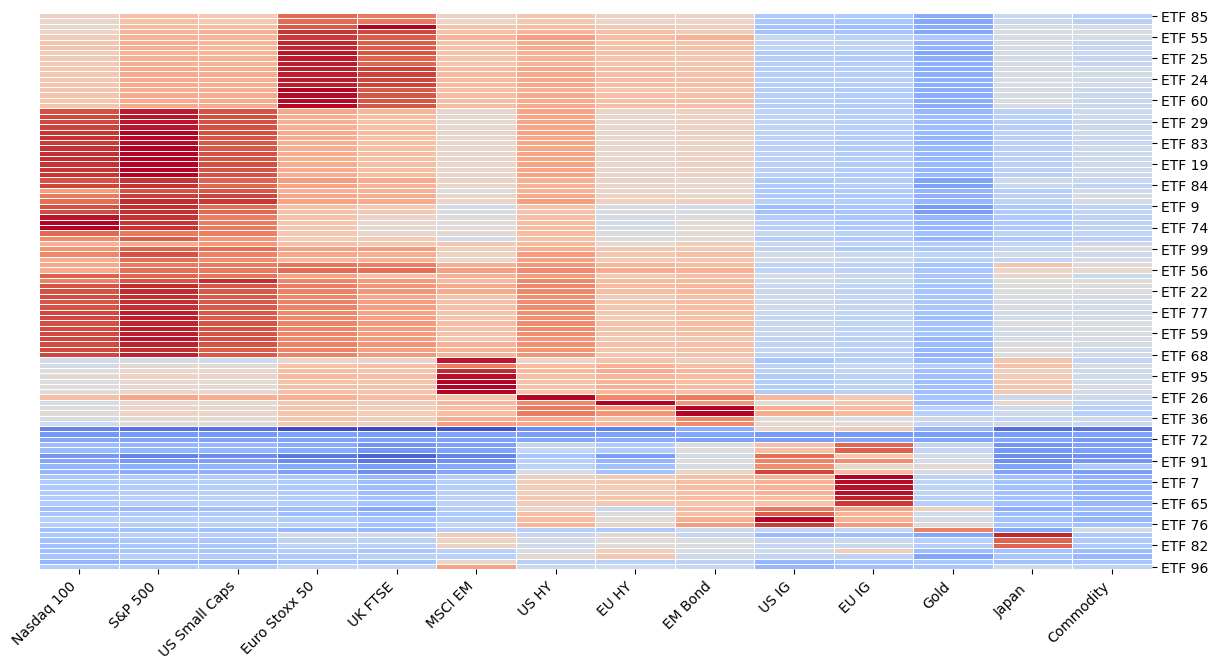

In [30]:
sns.clustermap(
    etf_asset_corr[main_assets_list], cmap='coolwarm',
    linewidths=0.5, figsize=(12, 7),
    dendrogram_ratio=0., cbar_pos=None,
)
plt.xticks(rotation=45, ha="right")
plt.show()

In [116]:
def plot_etf_correlations(ax, etf_name, corr_df):
    """ Plot correlations for one ETF """
    series = corr_df.loc[etf_name].drop(["TopAsset", "MaxCorr"], errors="ignore")
    series_sorted = series.sort_values(ascending=False)

    sns.barplot(y=series_sorted.index, x=series_sorted.values,
                color="#4C9F70", edgecolor="black", ax=ax)

    ax.axvline(0, color="black", linewidth=1.5)
    ax.set_title(f"Asset Correlation Profile for {etf_name}")
    ax.set_xlabel("Correlation")
    ax.grid(axis="x", alpha=0.25)
    # Value labels
    for i, v in enumerate(series_sorted.values):
        ax.text(v + 0.02, i, f"{v:.2f}", va="center", fontweight='bold')


def plot_top_asset_frequency(ax, corr_df):
    """ Plot frequency of top asset classification """
    assets_list = corr_df["TopAsset"].unique()
    count_series = corr_df["TopAsset"].value_counts().reindex(assets_list, fill_value=0)
    freq_series = 100 * count_series / len(corr_df)

    sns.barplot(x=freq_series.index, y=freq_series.values,
                edgecolor="black", color="steelblue", ax=ax)

    ax.set_title("Frequency of Top Asset Classification")
    ax.set_ylabel("% of ETFs")
    ax.set_xticklabels(freq_series.index, rotation=45, ha="right")
    ax.grid(axis="y", alpha=0.25)
    for i, v in enumerate(freq_series.values):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha="center")


def plot_max_correlation(ax, corr_df):
    """ Plot maximum correlation per ETF """
    etf_numbers = [int(s.split()[1]) for s in corr_df.index]

    sns.lineplot(x=etf_numbers, y=corr_df["MaxCorr"],
        marker="o", linewidth=2, ax=ax
    )

    ax.axhline(0.5, linestyle="--", color="red", alpha=0.8, linewidth=1.5)
    ax.axhline(1.0, linestyle="--", color="red", alpha=0.8, linewidth=1.5)
    ax.set_title("Maximum Correlation for Each ETF")
    ax.set_xlabel("ETF Number")
    ax.set_ylabel("Max Correlation")
    ax.grid(axis="y", alpha=0.25)


def plot_etf_asset_relationships(etf_name, corr_df):
    mosaic = """
    AB
    AC
    """
    fig, axes = plt.subplot_mosaic(mosaic, figsize=(12, 5))
    # Single ETF correlation profile
    plot_etf_correlations(axes["A"], etf_name, corr_df)
    # Frequency of top asset classification
    plot_top_asset_frequency(axes["B"], corr_df)
    # Maximum correlation across ETFs
    plot_max_correlation(axes["C"], corr_df)
    plt.tight_layout()
    plt.show()

ETF 1:
- This ETF is almost perfectly aligned with the S&P 500, showing very high correlations with other US equity indices (Nasdaq 100, US Small Caps) and moderate correlations with European and high-yield assets.
- It has very low correlation with safe-haven or fixed-income assets like Gold or Investment Grade bonds. ETF 1 clearly represents a high-risk, high-correlation equity ETF, consistent with the main equity cluster identified in the earlier clustering analysis.


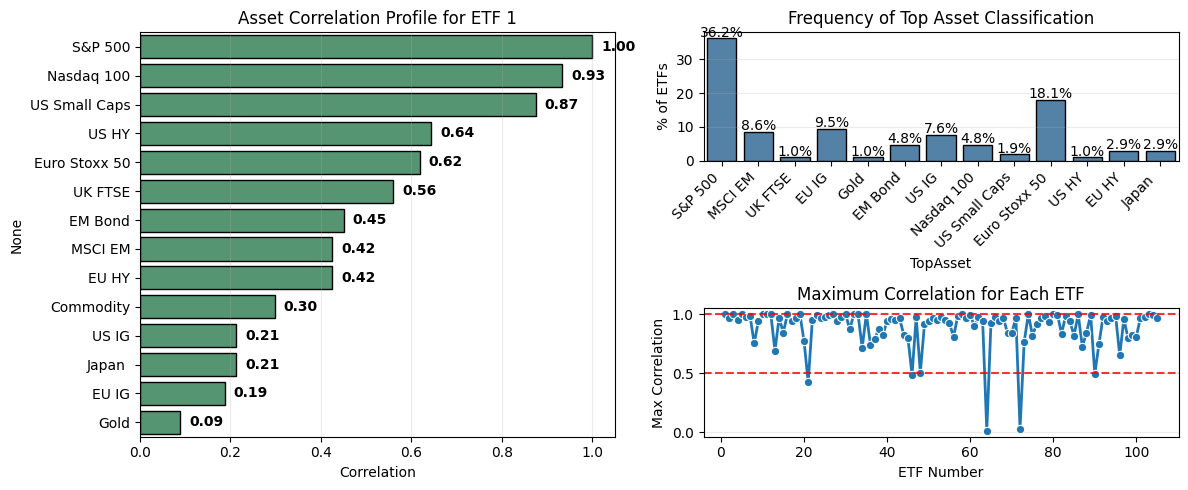

In [117]:
plot_etf_asset_relationships("ETF 1", etf_asset_corr)

ETF 102:
- In contrast, this ETF is primarily exposed to Emerging Markets (MSCI EM), with a very high correlation to that index (0.98) and moderate correlations with related risk assets like EU High Yield and Japan.
- Its correlation with dominant US equities is moderate, and its correlations with Gold and IG bonds remain low.
- ETF 102 exemplifies emerging market-focused ETFs with a distinct risk factor profile, less tied to the central US equity factor.


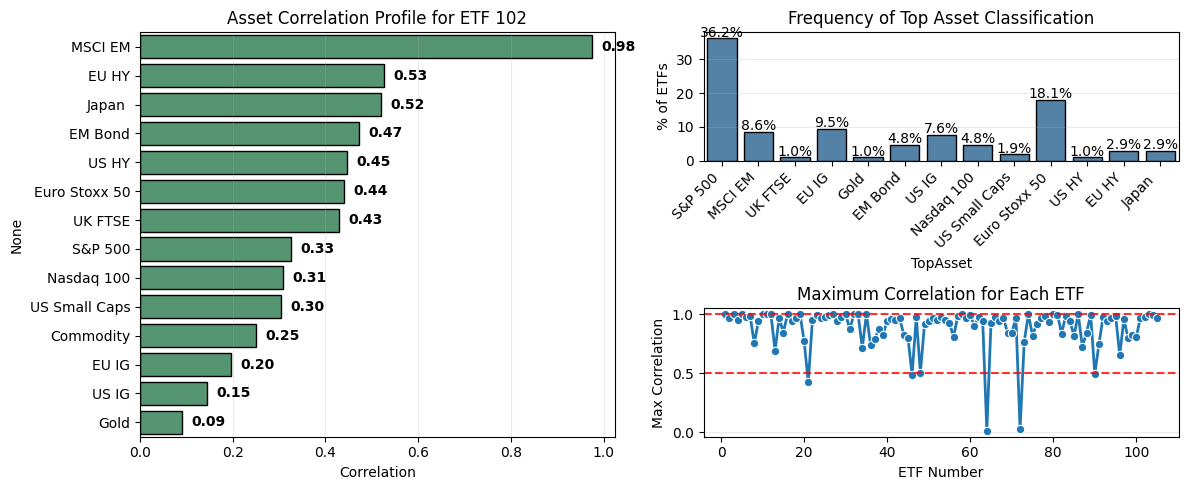

In [118]:
plot_etf_asset_relationships("ETF 102", etf_asset_corr)

## Asset-Class-Based Regression of ETF Returns

In [33]:
def align_returns(etf_rets, main_asset_rets):
    common_index = etf_rets.index.intersection(main_asset_rets.index)
    etf_aligned = etf_rets.loc[common_index].dropna()
    asset_aligned = main_asset_rets.loc[common_index].dropna()
    # Ensure indices match exactly
    common_index = etf_aligned.index.intersection(asset_aligned.index)
    return etf_aligned.loc[common_index], asset_aligned.loc[common_index]


def split_features(etf_name, etf_rets, main_asset_rets):
    y = etf_rets[etf_name]
    X = main_asset_rets
    # Align indices
    y = y.loc[X.index]
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [34]:
def train_model_get_weights(etf_rets, main_asset_rets, model_class, model_params=None):
    if model_params is None:
        model_params = {}
    etf_names = etf_rets.columns
    asset_names = main_asset_rets.columns

    results_array = np.zeros((len(etf_names), len(asset_names) + 2))
    results_df = pd.DataFrame(
        results_array, index=etf_names,
        columns=list(asset_names) + ["R2", "RMSE"]
    )

    metrics_dict = {"train_mse": {}, "test_mse": {}, "errors": {}}
    for idx, etf_name in enumerate(etf_names):
        # Split features
        X_train_scaled, X_test_scaled, y_train, y_test = split_features(etf_name, etf_rets, main_asset_rets)
        # Train model
        model = model_class(**model_params)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        # Feature importances or coefficients
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = model.coef_
        else:
            importances = np.full(len(asset_names), np.nan)

        # Metrics
        train_mse = mean_squared_error(y_train, model.predict(X_train_scaled))
        test_mse = mean_squared_error(y_test, y_pred)
        residuals = y_test - y_pred

        # Store results
        results_df.iloc[idx, :len(asset_names)] = importances
        results_df.iloc[idx, -2] = r2_score(y_test, y_pred)
        results_df.iloc[idx, -1] = test_mse
        metrics_dict["train_mse"][etf_name] = train_mse
        metrics_dict["test_mse"][etf_name] = test_mse
        metrics_dict["errors"][etf_name] = residuals
    return results_df.astype(float), metrics_dict

In [119]:
def plot_etf_vs_assets(etf_name, etf_rets, main_asset_rets):
    # Combine ETF and main assets
    n_cols = 5
    series = pd.concat([etf_rets[[etf_name]], main_asset_rets], axis=1)
    n_assets = main_asset_rets.shape[1]
    n_rows = int(np.ceil(n_assets / n_cols))

    plt.figure(figsize=(15, 8))
    for i, asset in enumerate(series.columns[1:]):
        plt.subplot(n_rows, n_cols, i+1)
        # Scatter plot
        sns.scatterplot(x=series[asset], y=series[etf_name], alpha=0.7, s=30)
        # KDE contours
        sns.kdeplot(x=series[asset], y=series[etf_name], levels=5, color="red", alpha=0.5)
        # Correlation
        corr = series[etf_name].corr(series[asset])
        plt.title(f"{asset} (correlation={corr:.2f})")
        plt.ylabel(etf_name)
        plt.xlabel("")
    plt.tight_layout()
    plt.suptitle(f"{etf_name} vs Main Asset Classes", y=1.02)
    plt.show()


def plot_importance_results(
        etf_name, model_name=None, results_model=None, metrics=None,
        y_test=None, y_pred=None, importances=None,
        train_errors=None, test_errors=None, errors=None):
    if [metrics, results_model] != [None, None]:
        # Retrieve metrics for that ETF
        train_errors = metrics["train_mse"][etf_name]
        test_errors = metrics["test_mse"][etf_name]
        errors = metrics["errors"][etf_name]
        y_test = etf_rets.loc[errors.index, etf_name]
        y_pred = y_test - errors
        importances = pd.Series(
            results_rf.loc[etf_name, main_assets_list], index=main_assets_list
        ).sort_values(ascending=False)
    print(model_name)
    print("R^2:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred), "\n")

    mosaic = [
    ["A", "B", "C", "G", "G"],
    ["D", "E", "F", "G", "G"]
]
    fig, axes = plt.subplot_mosaic(mosaic, figsize=(18, 6))
    # Feature Importances
    sns.barplot(x=importances.values, y=importances.index, ax=axes["A"], color="#4C9F70")
    axes["A"].axvline(0, color="black", linewidth=1.5)
    axes["A"].set_title("Feature Importances")
    axes["A"].grid(axis="x", alpha=0.3)
    # Predicted vs Actual
    axes["B"].scatter(y_test, y_pred, alpha=0.7, color="steelblue")
    axes["B"].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes["B"].set_xlabel("Actual ETF Returns")
    axes["B"].set_ylabel("Predicted ETF Returns")
    axes["B"].set_title("Predicted vs Actual ETF Returns")
    axes["B"].grid(alpha=0.3)
    # Time Series of Predictions
    axes["C"].plot(range(len(y_test)), y_test, label="Actual", color="blue")
    axes["C"].plot(range(len(y_pred)), y_pred, '--', label="Predicted", color="orange")
    axes["C"].set_title("Actual vs Predicted ETF Returns")
    axes["C"].set_xlabel("ETF")
    axes["C"].legend()
    axes["C"].grid(alpha=0.3)
    # Prediction Errors
    axes["D"].plot(range(len(errors)), errors, color="red")
    axes["D"].set_title("Prediction Errors")
    axes["D"].grid(alpha=0.3)
    # Error Distribution
    sns.histplot(errors, bins=30, kde=True, color="orange", ax=axes["E"])
    axes["E"].set_title("Distribution of Prediction Errors")
    axes["E"].grid(alpha=0.25)
    # Training vs Testing MSE
    if isinstance(train_errors, (list, np.ndarray)):
        axes["F"].plot(range(1, len(train_errors)+1), train_errors, label="Train MSE")
        axes["F"].plot(range(1, len(test_errors)+1), test_errors, label="Test MSE")
        axes["F"].legend()
    else:
        axes["F"].bar(['Train MSE', 'Test MSE'], [train_errors, test_errors])
    axes["F"].set_title("Training vs Testing MSE")
    axes["F"].grid(alpha=0.25)

    # Cumulative Returns Comparison
    cum_true = (1 + y_test).cumprod()
    cum_pred = (1 + y_pred).cumprod()

    axes["G"].plot(cum_true.values, label="True ETF", linewidth=2)
    axes["G"].plot(cum_pred.values, linestyle="--", label="Reconstructed (Main Assets)", linewidth=2)

    axes["G"].set_title("Cumulative Returns Comparison")
    axes["G"].legend()
    axes["G"].grid(alpha=0.3)
    plt.suptitle(f"{model_name} Results for {etf_name}")
    plt.tight_layout()
    plt.show()

In [36]:
etf_rets_aligned, main_assets_aligned = align_returns(etf_rets, main_asset_rets)

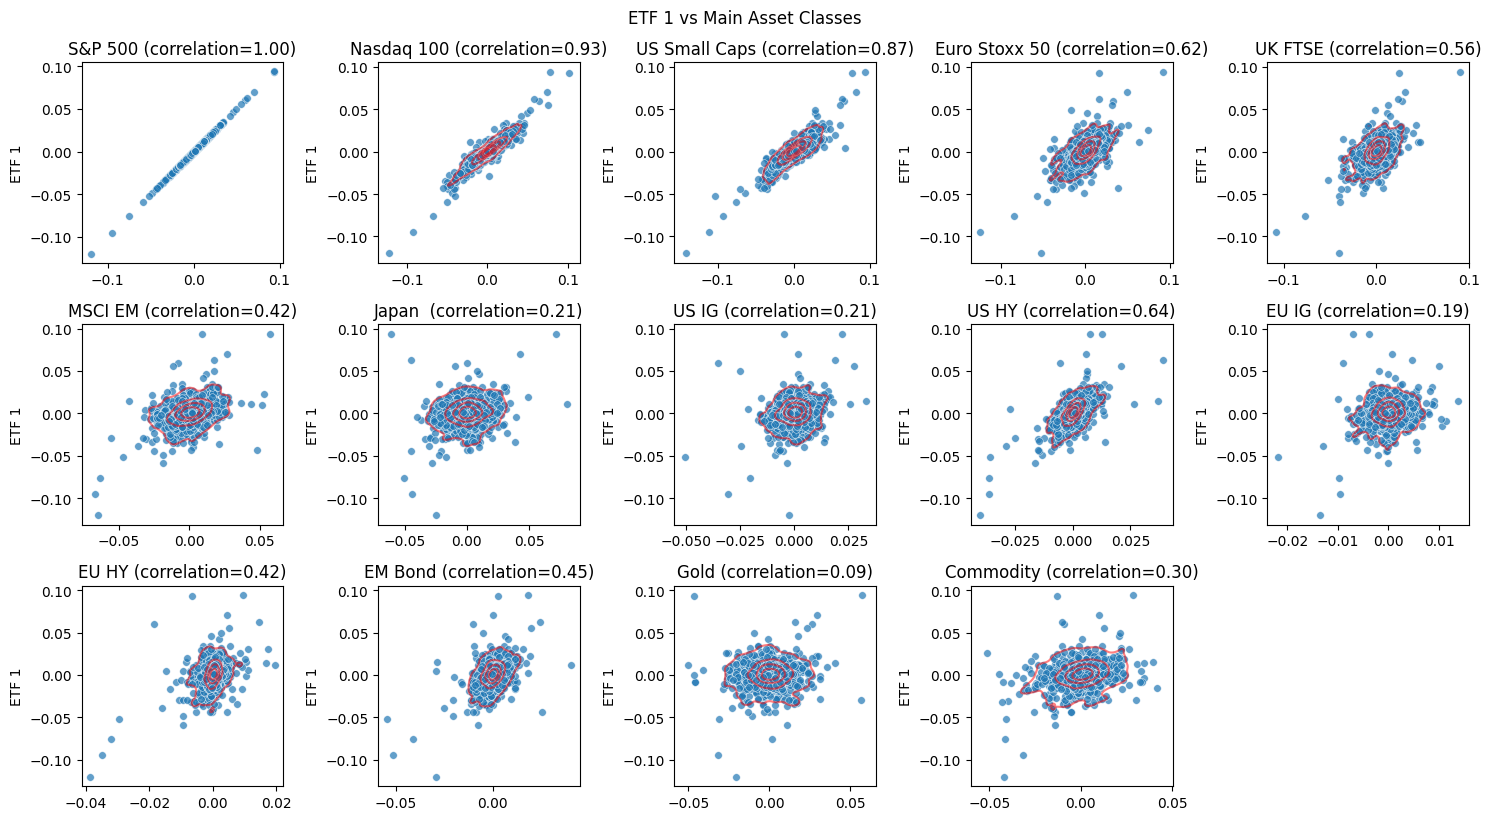

In [120]:
plot_etf_vs_assets("ETF 1", etf_rets_aligned, main_assets_aligned)

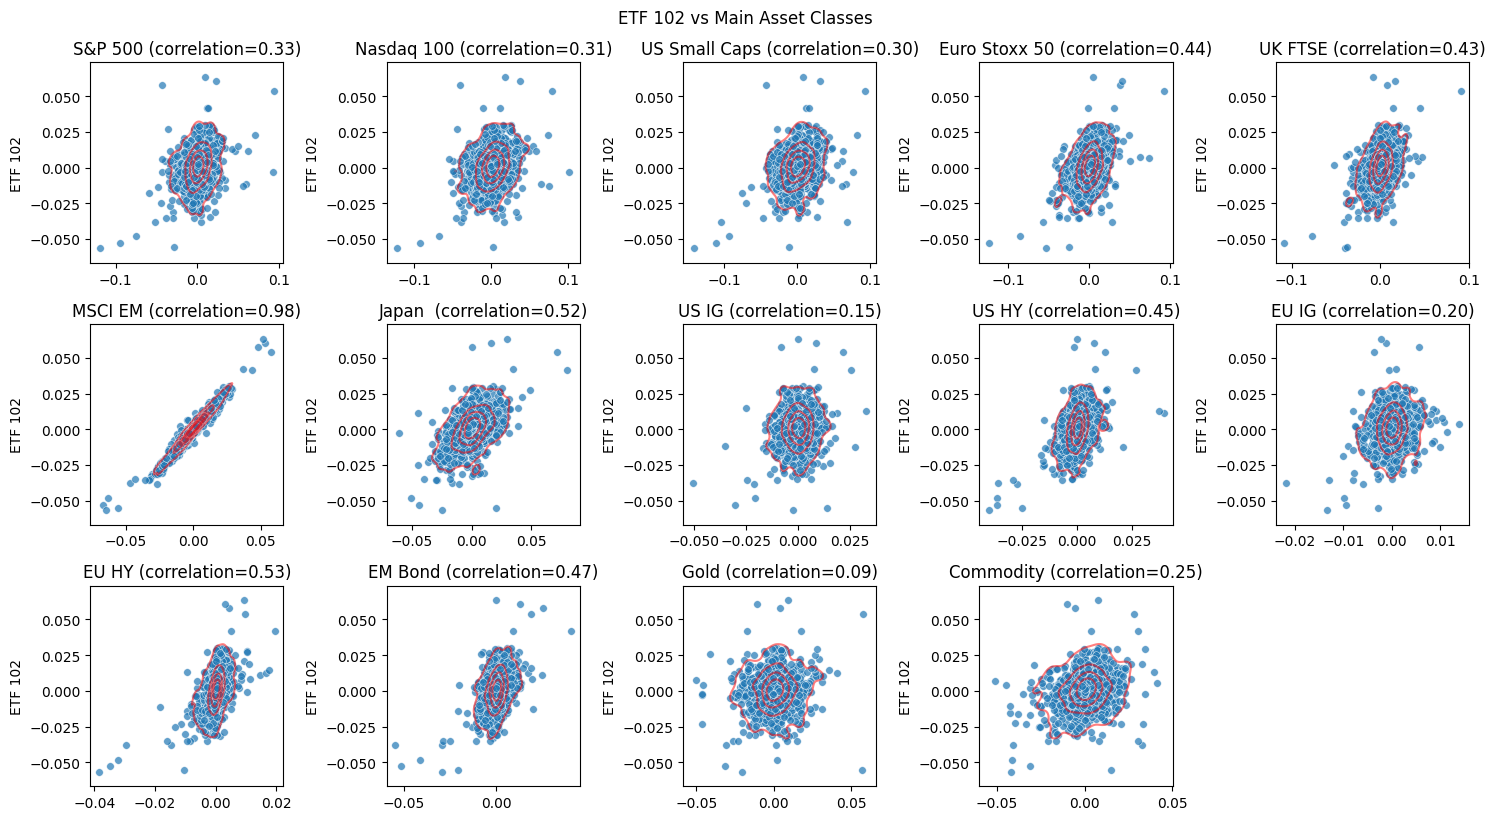

In [121]:
plot_etf_vs_assets("ETF 102", etf_rets_aligned, main_assets_aligned)

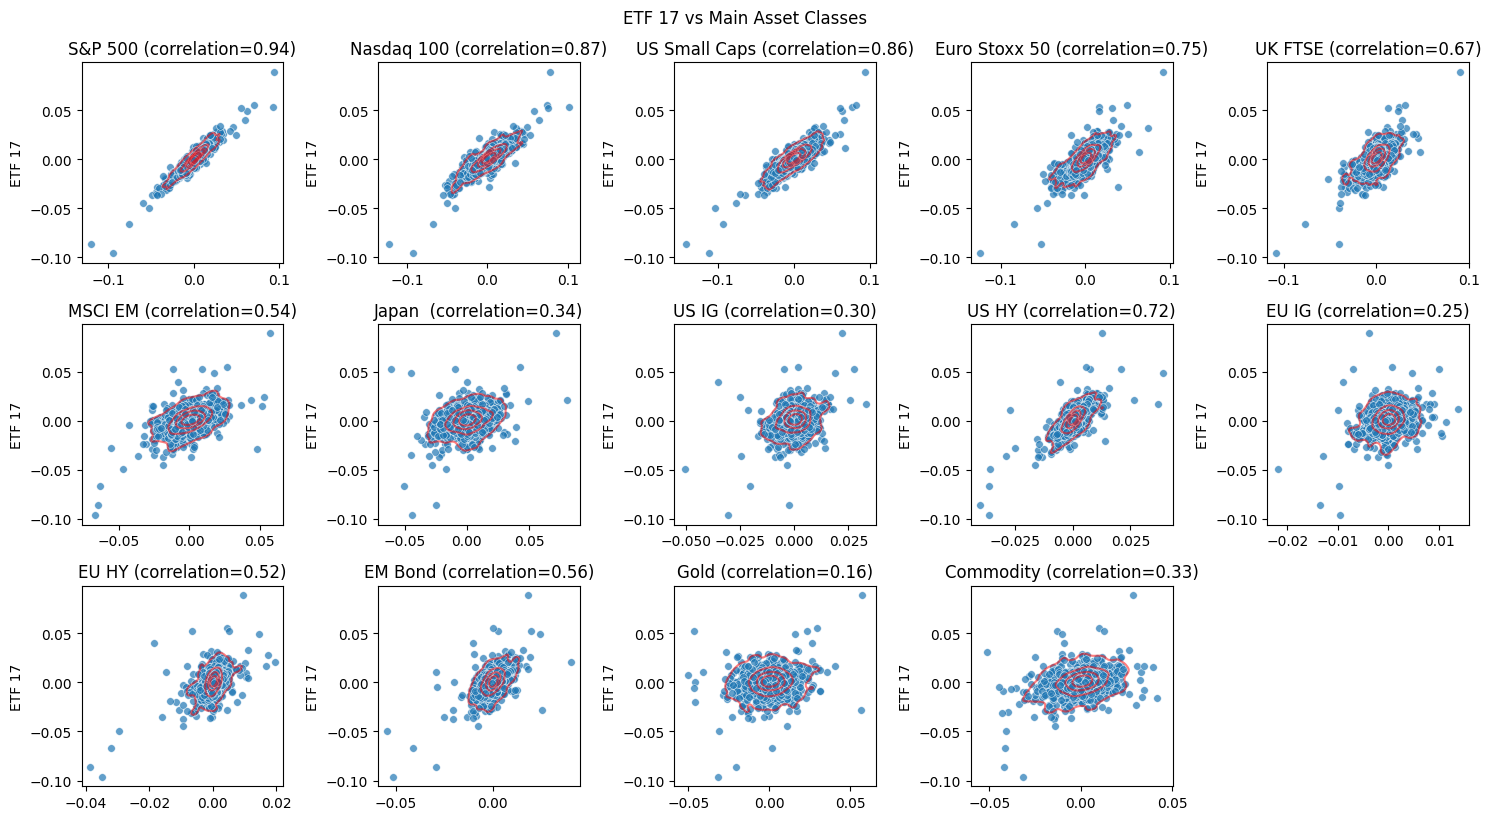

In [122]:
etf_name = "ETF 17"
plot_etf_vs_assets(etf_name, etf_rets_aligned, main_assets_aligned)

In [38]:
params_models = {
    "LinearRegression": {"model": LinearRegression, "param": {}},
    "RandomForest": {"model": RandomForestRegressor, "param": {"n_estimators": 5, "random_state":42}},
    "Lasso": {"model": Lasso, "param": {"alpha": 1, "random_state":42}},
    "PLSRegression": {"model": PLSRegression, "param": {"n_components": 5}}
}

The regression analysis clearly demonstrates that the returns of ETF 17 are highly predictable from the 14 main asset classes, emphasizing the dominance of US equity exposure.

## Random Forest Regression



In [39]:
results_rf, metrics_rf = train_model_get_weights(
    etf_rets_aligned, main_assets_aligned,
    model_class=params_models["RandomForest"]["model"],
    model_params=params_models["RandomForest"]["param"]
)

Random Forest Regressor
R^2: 0.8982814771287072
MSE: 8.763669256280812e-06 



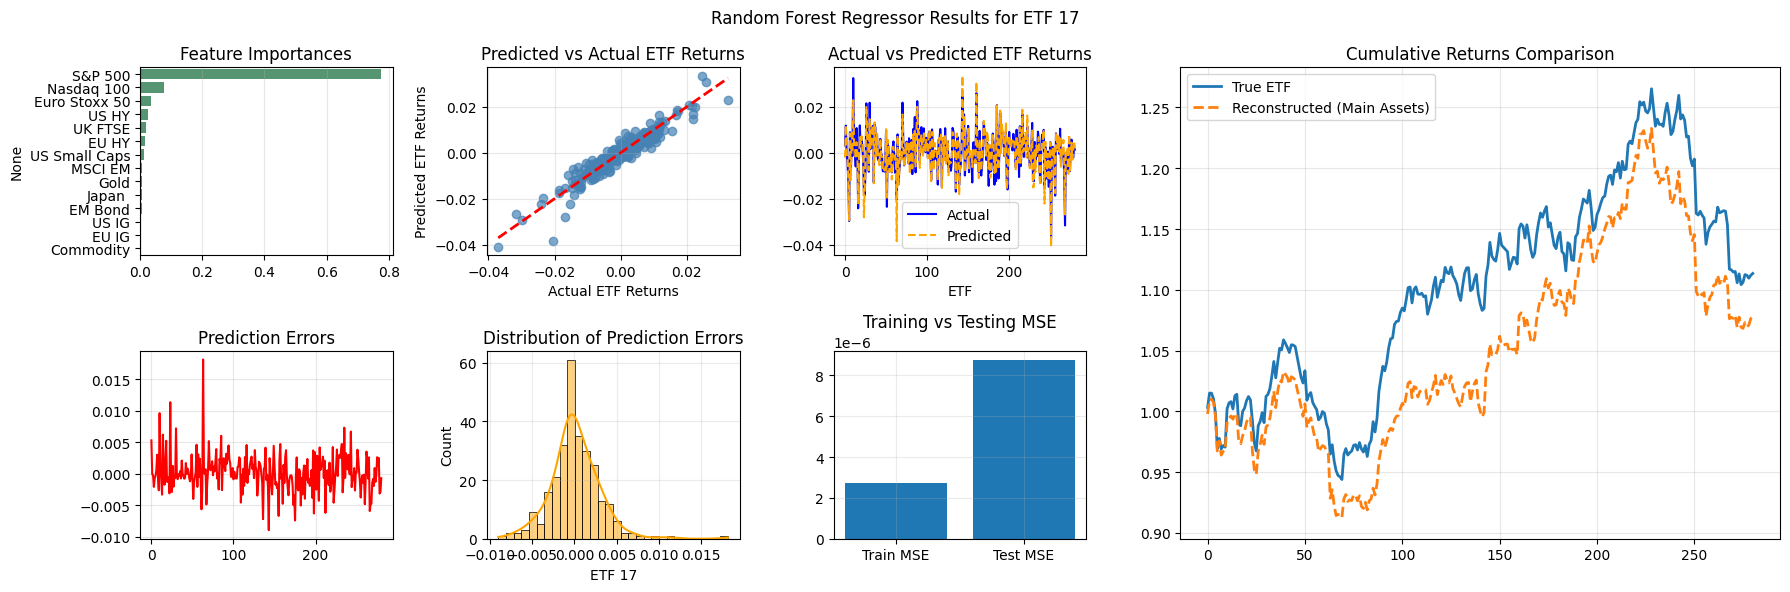

In [110]:
plot_importance_results(
    etf_name, metrics=metrics_rf,
    results_model=results_rf, model_name="Random Forest Regressor"
)

## Linear Regression


In [41]:
results_linreg, metrics_linreg = train_model_get_weights(
    etf_rets_aligned, main_assets_aligned,
    model_class=LinearRegression, model_params={}
)

results_lasso, metrics_lasso = train_model_get_weights(
    etf_rets_aligned, main_assets_aligned,
    model_class=params_models["LinearRegression"]["model"],
    model_params=params_models["LinearRegression"]["param"]
)

LinearRegression
R^2: 0.9451640474667669
MSE: 4.724450746914993e-06 



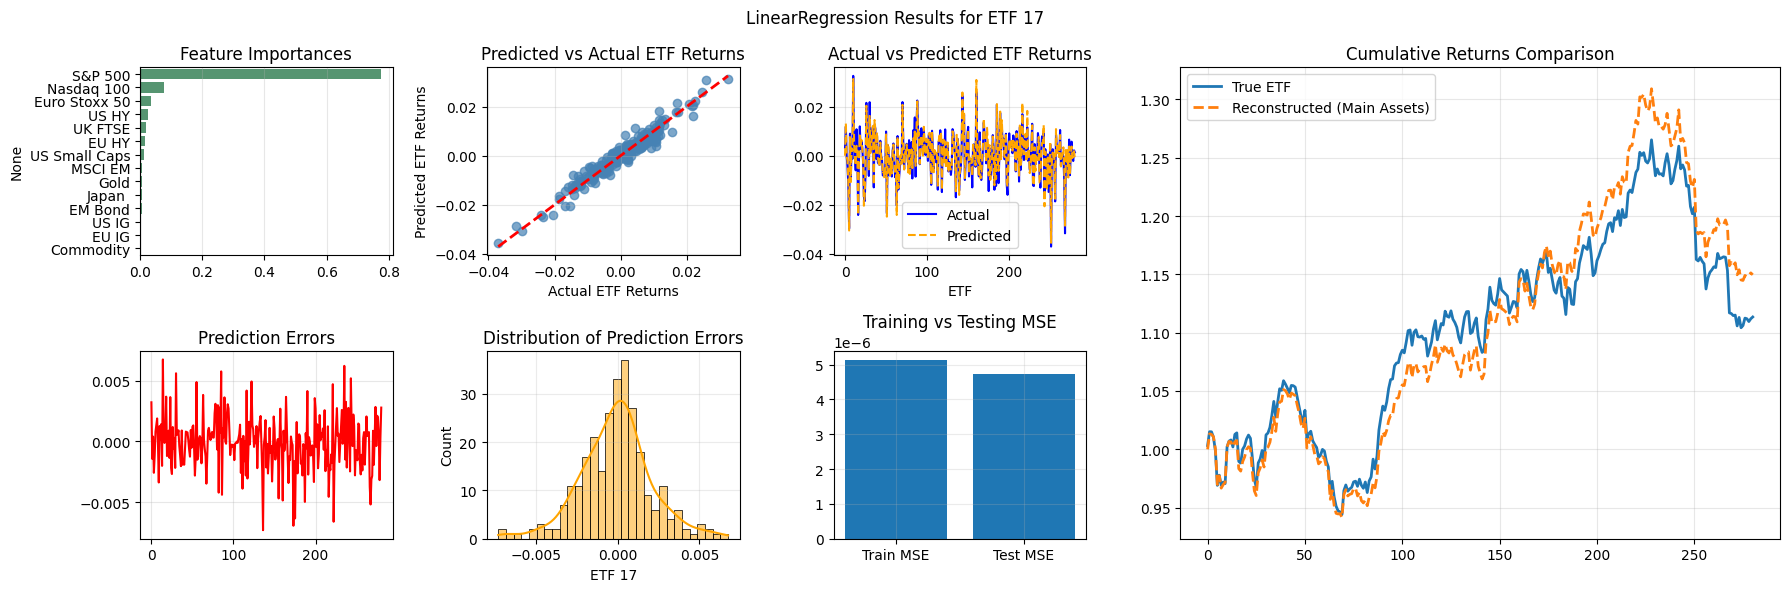

In [111]:
plot_importance_results(
    etf_name, metrics=metrics_linreg,
    results_model=results_linreg, model_name="LinearRegression"
)

## Lasso Regression


In [43]:
results_lasso, metrics_lasso = train_model_get_weights(
    etf_rets_aligned, main_assets_aligned,
    model_class=params_models["Lasso"]["model"],
    model_params=params_models["Lasso"]["param"]
)

LassoRegression
R^2: -0.0003472724506923264
MSE: 8.618600024572968e-05 



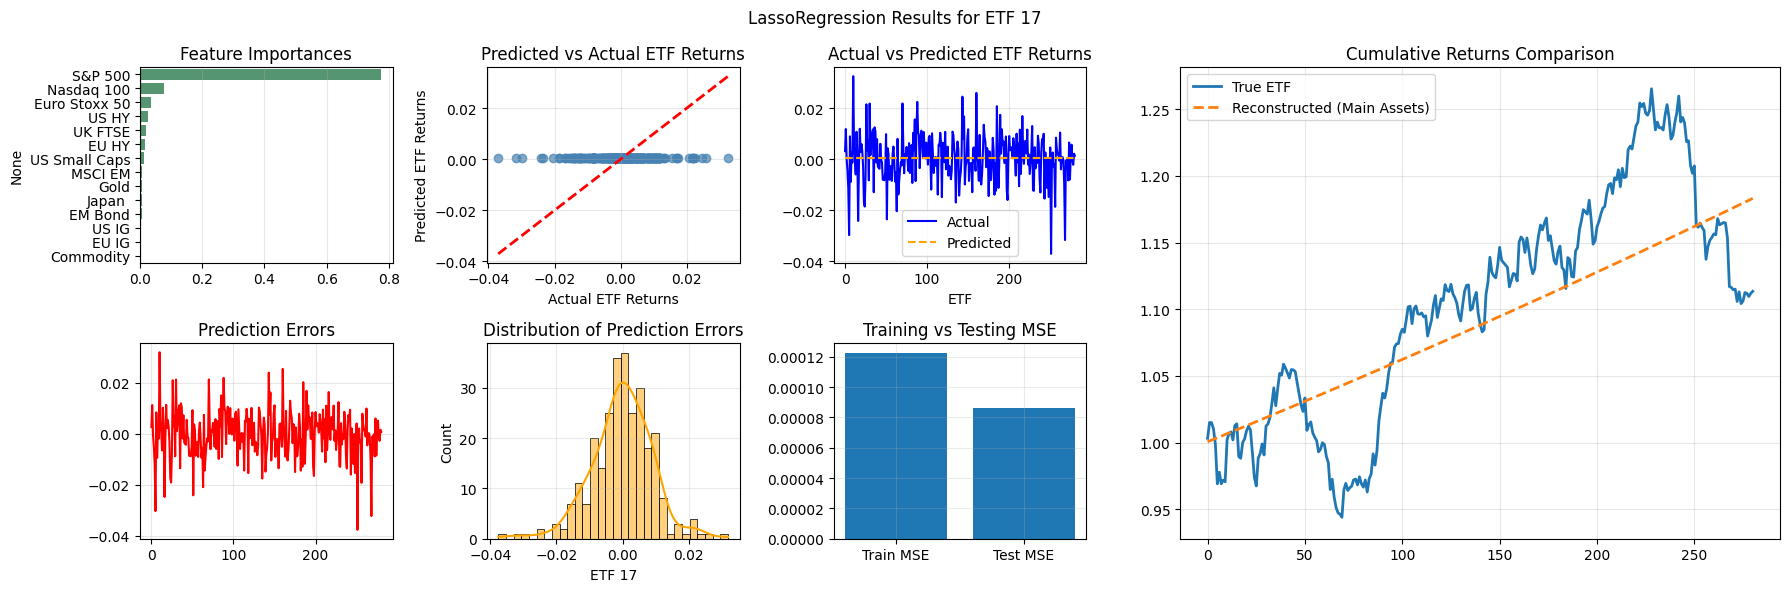

In [112]:
plot_importance_results(
    etf_name, metrics=metrics_lasso,
    results_model=results_lasso, model_name="LassoRegression"
)

## PLS Regression


In [45]:
results_plsreg, metrics_plsreg = train_model_get_weights(
    etf_rets_aligned, main_assets_aligned,
    model_class=params_models["PLSRegression"]["model"],
    model_params=params_models["PLSRegression"]["param"]
)

PLS Regression
R^2: 0.9414224839846642
MSE: 5.046809191895723e-06 



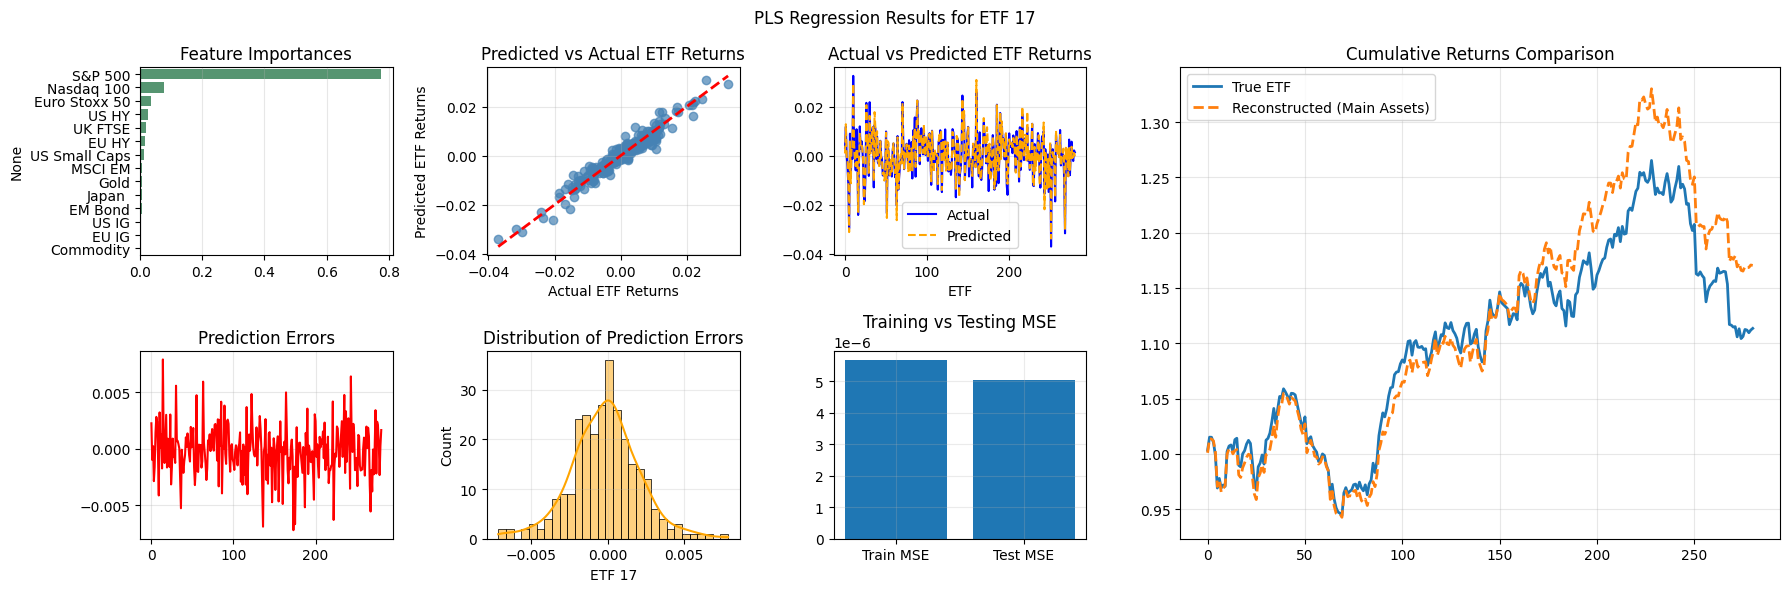

In [113]:
plot_importance_results(
    etf_name, metrics=metrics_plsreg,
    results_model=results_plsreg, model_name="PLS Regression"
)

### 1. Model Performance:
- Linear Regression and PLS Regression achieve excellent fits ($R^2$ ≈ 0.94), capturing almost all daily return variance of ETF 17.
- Random Forest performs reasonably well ($R^2$ ≈ 0.898), but slightly underperforms the linear models.
- Lasso Regression fails ($R^2$ ≈ -0.0003) due to overly strong regularization, essentially eliminating all relevant coefficients.


<br>


### 2. Factor Exposure:
- The S&P 500 is the dominant driver across all successful models, confirming ETF 17’s strong US equity bias.
- Other contributors include Nasdaq 100, Euro Stoxx 50, US HY, and US Small Caps, while defensive assets (Gold, IG credit) have minimal impact.
- This aligns ETF 17 with the high-risk/high-correlation cluster (Cluster 1) identified in the clustering analysis.


<br>

### 3. Cumulative Returns Fit:
- Linear models and PLS accurately replicate the true cumulative return path of ETF 17, including peaks and troughs, whereas Random Forest shows minor deviations and Lasso completely fails.


<br>

### 4. Weights Interpretation:
- Regression coefficients represent factor exposures rather than portfolio weights; they do not sum to 1 for most models, except Random Forest where importance scores are normalized.


<br>

ETF 17 behaves as a systematic exposure vehicle, predominantly tracking US equities. Linear relationships dominate, making linear and PLS regression highly effective in explaining its returns, while models with overly aggressive regularization (Lasso) fail to capture meaningful patterns. This reinforces the earlier finding that a majority of ETFs in the universe are driven by major equity factors.

## Comparing Cumulative Returns from models

In [128]:
def plot_cumrets_models_from_errors(etf_name, etf_rets, models_metrics, main_asset_rets, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))

    # Reference from first model
    ref_model = next(iter(models_metrics))
    ref_errors = models_metrics[ref_model]["errors"][etf_name]
    y_true = etf_rets.loc[ref_errors.index, etf_name]

    # True cumulative returns
    cum_true = (1 + y_true).cumprod()
    ax.plot(cum_true.values, color="black", linewidth=3, label="True ETF")

    # Equally weighted portfolio of main assets
    equal_weight = main_asset_rets.loc[ref_errors.index].mean(axis=1)
    cum_equal = (1 + equal_weight).cumprod()
    ax.plot(cum_equal.values, linestyle="--", color="gray", linewidth=2, label="Equally Weighted Portfolio")

    # Models
    for model_name, metrics in models_metrics.items():
        errors = metrics["errors"][etf_name]
        y_pred = y_true.loc[errors.index] - errors
        cum_pred = (1 + y_pred).cumprod()
        ax.plot(cum_pred.values, linestyle="--", linewidth=2, label=model_name)
    ax.set_title(f"Cumulative Returns ({etf_name})")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)
    return ax

In [132]:
models_metrics = {
    "Linear Regression": metrics_linreg,
    "Lasso": metrics_lasso,
    "Random Forest": metrics_rf,
    "PLS Regression": metrics_plsreg
}

models_results = {
    "Lasso": results_lasso,
    "RandomForest": results_rf,
    "LinearRegression": results_linreg,
    "PLSRegression": results_plsreg
}

### Model Performance Consistency

Across all three ETFs examined—ETF 17, ETF 1, and ETF 102, the results reveal a consistent hierarchy in model performance, but with some nuances depending on the ETF’s specific exposure:


<br>

| Model | Performance | Limitations |
|-------|------------------|----------------------|
| **Linear Regression <br> PLS Regression** | Generally provide the best reconstruction of true cumulative returns. <br> Accurately capture trend and volatility of high-beta ETFs (ETF 1, ETF 17) <br> and perform well for idiosyncratic ETFs (ETF 102). | Fit slightly less precise for noisy or complex Emerging Market exposures. <br>Superior performance reflects strong linear relationship between ETF returns <br> and the 14 main asset classes. |
| **Random Forest Regressor** | Moderately good approximation of ETF returns.  <br> Captures general trends but tends to smooth peaks <br>and troughs, underestimating volatility. | Tree-based models struggle with subtle linear dependencies and <br>high-frequency variations, especially with small or shallow ensembles. |
| **Lasso Regression** | Performs poorly across ETFs. <br>Cumulative returns are nearly flat or misaligned with true paths. | Strong regularization drives most coefficients toward zero, eliminating key  asset exposures. <br> Overly aggressive shrinkage is unsuitable for ETFs with well-defined factor exposures. |

<br>


### ETF-Specific Variation

It is notable that the top-performing model can vary slightly depending on the ETF.
- For example, while Linear Regression might slightly outperform PLS for ETF 17
- PLS may better capture cumulative return peaks for ETF 102 due to its dimensionality reduction component accommodating multicollinearity among asset classes.
- Thus, even though linear models dominate overall, the precise “best” model can differ across ETFs, reflecting differences in factor loadings and return dynamics.


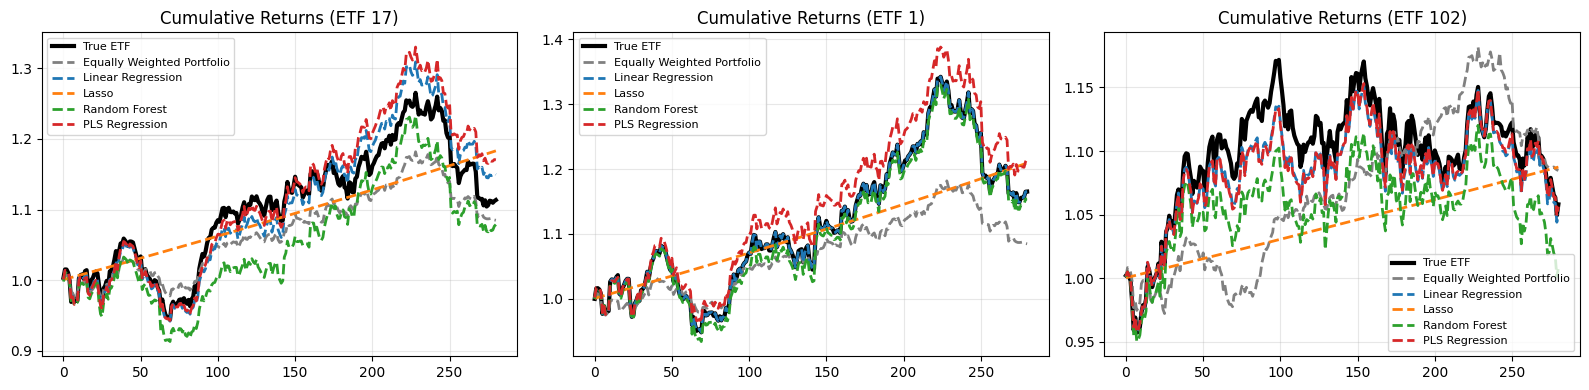

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_cumrets_models_from_errors(etf_name=etf_name, etf_rets=etf_rets_aligned,
                                models_metrics=models_metrics, main_asset_rets=main_assets_aligned, ax=axes[0])
plot_cumrets_models_from_errors(etf_name="ETF 1", etf_rets=etf_rets_aligned,
                                models_metrics=models_metrics, main_asset_rets=main_assets_aligned, ax=axes[1])
plot_cumrets_models_from_errors(etf_name="ETF 102", etf_rets=etf_rets_aligned,
                                models_metrics=models_metrics, main_asset_rets=main_assets_aligned, ax=axes[2])
plt.tight_layout()
plt.show()

### **Weight Sums Across Models**

The analysis confirms that the sum of weights differs substantially depending on the regression model:

<br>

| Model | Sum of Weights Behavior | Interpretation |
|-------|-----------------------|----------------|
| **Random Forest** | Feature importances sum to 1 for each ETF | Reflects tree-based decomposition <br>- contributions normalized across all input features  <br> - emphasizing dominant drivers of variance |
| **Linear Regression / Lasso / PLS Regression** | Coefficients do not sum to 1 | Represent factor exposures (betas)  <br> - capturing ETF sensitivity to each asset class  <br> - unconstrained and can be negative, reflecting inverse relationships |


<br>

### Full Investment of Capital

In portfolio construction, weights must sum up to 1 because they represent the proportion of total capital allocated to each asset in the portfolio.
- If weights sum to 1, it ensures all available capital is invested, correctly scaled, and interpretable in terms of risk and return

<br>

> Since the feature importances naturally sum to 1, Random Forest is well-suited for constructing portfolios directly, because the outputs can be interpreted as normalized allocations across assets.


In [49]:
pd.DataFrame({
    "LinearRegression": results_linreg[main_assets_list].sum(axis=1),
    "RandomForest": results_rf[main_assets_list].sum(axis=1),
    "Lasso": results_lasso[main_assets_list].sum(axis=1),
    "PLSRegression": results_plsreg[main_assets_list].sum(axis=1)
}).T

ETF 1     ETF 2     ETF 3     ETF 4     ETF 5     ETF 6  \
LinearRegression  0.013216  0.013380  0.010910  0.013005  0.010943  0.013218   
RandomForest      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Lasso             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PLSRegression     0.013600  0.013646  0.010818  0.013160  0.011238  0.013639   

                     ETF 7     ETF 8     ETF 9    ETF 10  ...    ETF 96  \
LinearRegression  0.002497  0.008036  0.011089  0.005397  ...  0.007944   
RandomForest      1.000000  1.000000  1.000000  1.000000  ...  1.000000   
Lasso             0.000000  0.000000  0.000000  0.000000  ...  0.000000   
PLSRegression     0.002531  0.008050  0.011760  0.005366  ...  0.007668   

                    ETF 97    ETF 98    ETF 99   ETF 100   ETF 101   ETF 102  \
LinearRegression  0.009825  0.010847  0.012376  0.008390  0.013400  0.010448   
RandomForest      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Lasso             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PLSRegression     0.009945  0.010541  0.012536  0.008564  0.013871  0.010177   

                   ETF 103   ETF 104   ETF 105  
LinearRegression  0.005444  0.012389  0.012805  
RandomForest      1.000000  1.000000  1.000000  
Lasso             0.000000  0.000000  0.000000  
PLSRegression     0.005418  0.012936  0.013150  

[4 rows x 105 columns]

In [138]:
models_results.keys()

dict_keys(['Lasso', 'RandomForest', 'LinearRegression', 'PLSRegression'])

In [142]:
def plot_asset_kde(models_results, model_name):
    model_result = models_results[model_name]
    model_result = model_result[main_assets_list]

    mosaic = [
        list("ZZZZZZZ"),
        list("ZZZZZZZ"),
        list("ABCDEFG"),
        list("HIJKLMN"),
    ]

    fig, axes = plt.subplot_mosaic(mosaic, figsize=(14, 7), constrained_layout=True)
    palette = sns.color_palette("tab20", n_colors=len(main_assets_list))
    asset_colors = dict(zip(main_assets_list, palette))
    # Grouped KDE
    for asset in main_assets_list:
        sns.kdeplot(model_result[asset], fill=True, alpha=0.4, label=asset,
                    color=asset_colors[asset], ax=axes["Z"])
    axes["Z"].set_xlabel("")
    axes["Z"].set_ylabel("")
    axes["Z"].set_title(f"{model_name}: Weights for Main Assets")
    axes["Z"].legend()

    # Individual KDEs for each letter
    letters = [key for key in axes.keys() if key != "Z"]
    for letter, asset in zip(letters, main_assets_list):
        sns.kdeplot(model_result[asset], fill=True, alpha=0.6,
                    color=asset_colors[asset], ax=axes[letter])
        axes[letter].set_title(f"KDE of {asset}")
        axes[letter].set_xlabel("")
        axes[letter].set_ylabel("")
    plt.tight_layout()
    plt.show()

### Frequency of Asset Classes in ETF-decomposition

The KDE plots reveal how asset exposures are distributed across the 105 ETFs for our models.

For example, for Random Forest and Linear Regression:


| Feature | Random Forest | Linear Regression |
|---------|---------------|-----------------|
| **Weight Characteristics** | - non-negative <br>- mostly concentrated near 0 <br>- minor exposures suppressed | - can be positive or negative <br>- captures inverse relationships for some ETFs |
| **S&P 500 Exposure** | - dominant factor <br> - clear peak around 0.5 | - broad distribution <br> - strong but variable exposures across ETFs |
| **Other Equity Assets <br> (Nasdaq 100, US Small Caps, Euro Stoxx 50)** | - moderate contributions <br> - tails extend slightly from 0 | - significant contributions with varying sensitivities among ETFs |
| **Defensive/Fixed Income Assets <br> (Gold, US IG, EU IG)** | - minimal impact<br> - distributions sharply centered near 0 | - mostly negligible<br>- occasional slight negative values reflecting minor hedging <br> or inverse behavior |
| **Interpretation** | - highlights variance importance<br> - emphasizes key drivers <br>- compresses minor exposures | - shows factor sensitivity<br>- reveals both positive and negative betas <br> - detailed ETF exposures |

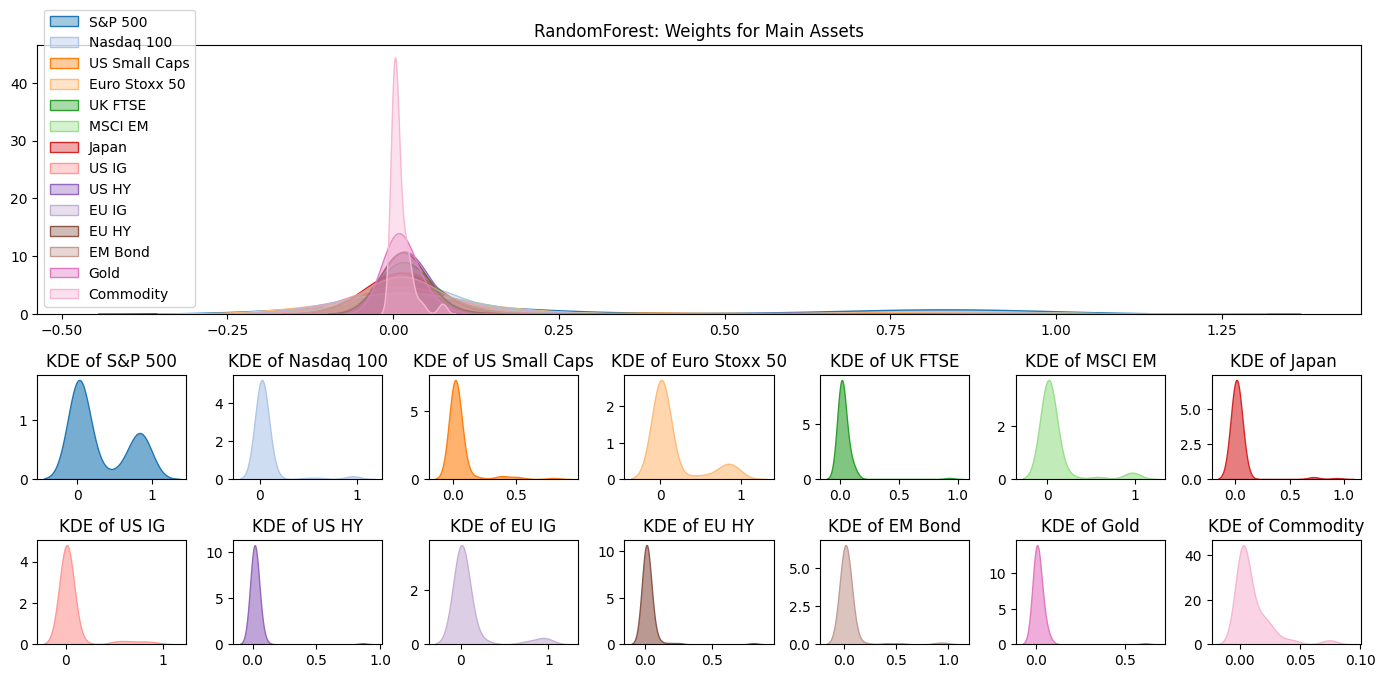

In [143]:
plot_asset_kde(models_results, 'RandomForest')

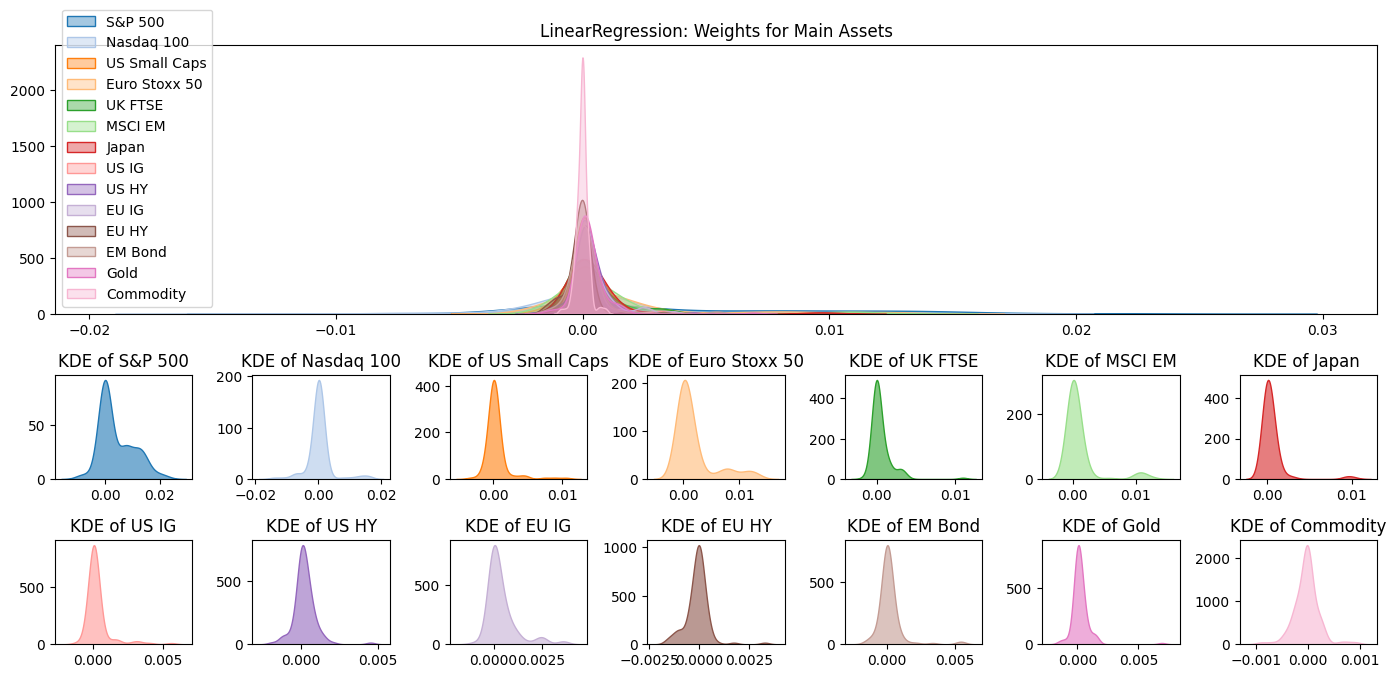

In [144]:
plot_asset_kde(models_results, 'LinearRegression')

### Factor Exposure Heatmaps

The heatmaps visualize how our different regression models allocate factor exposures (weights or feature importances) for all 105 ETFs across 14 main asset classes. The intensity of red corresponds to the magnitude of each exposure.

| Model               | Heatmap Pattern                   | Interpretation |
|--------------------|---------------------------------|----------------|
| **Lasso Regression**    | Mostly blank or pale red          | Aggressive regularization ($\alpha=1$) drives most coefficients to 0. <br>It fails to capture key factor exposures, explaining its very poor performance |
| **Random Forest**       | Sparse with isolated dark red squares | Only a few assets per ETF are assigned meaningful importance. <br>S&P 500 and Nasdaq 100 dominate, while minor factors are ignored. <br>Feature importances sum to 1 per ETF, reflecting a variance decomposition approach. |
| **Linear Regression**   | Dense, uniformly dark red/orange  | Most assets receive non-0 coefficients. <br>Weights do not sum to 1, capturing widespread linear correlations. <br>Nearly all assets contribute to explaining ETF returns. |
| **PLS Regression**      | Dense, slightly more structured   | Similar to Linear Regression: non-normalized coefficients capture broad factor exposures. <br>Slightly more structured patterns reflect PLS dimensionality reduction, <br>highlighting systematic trends while smoothing minor noise. |

<br>

- Linear models are ideal when understanding sensitivity to all factors is important
- while Random Forest is useful for identifying key drivers of variance

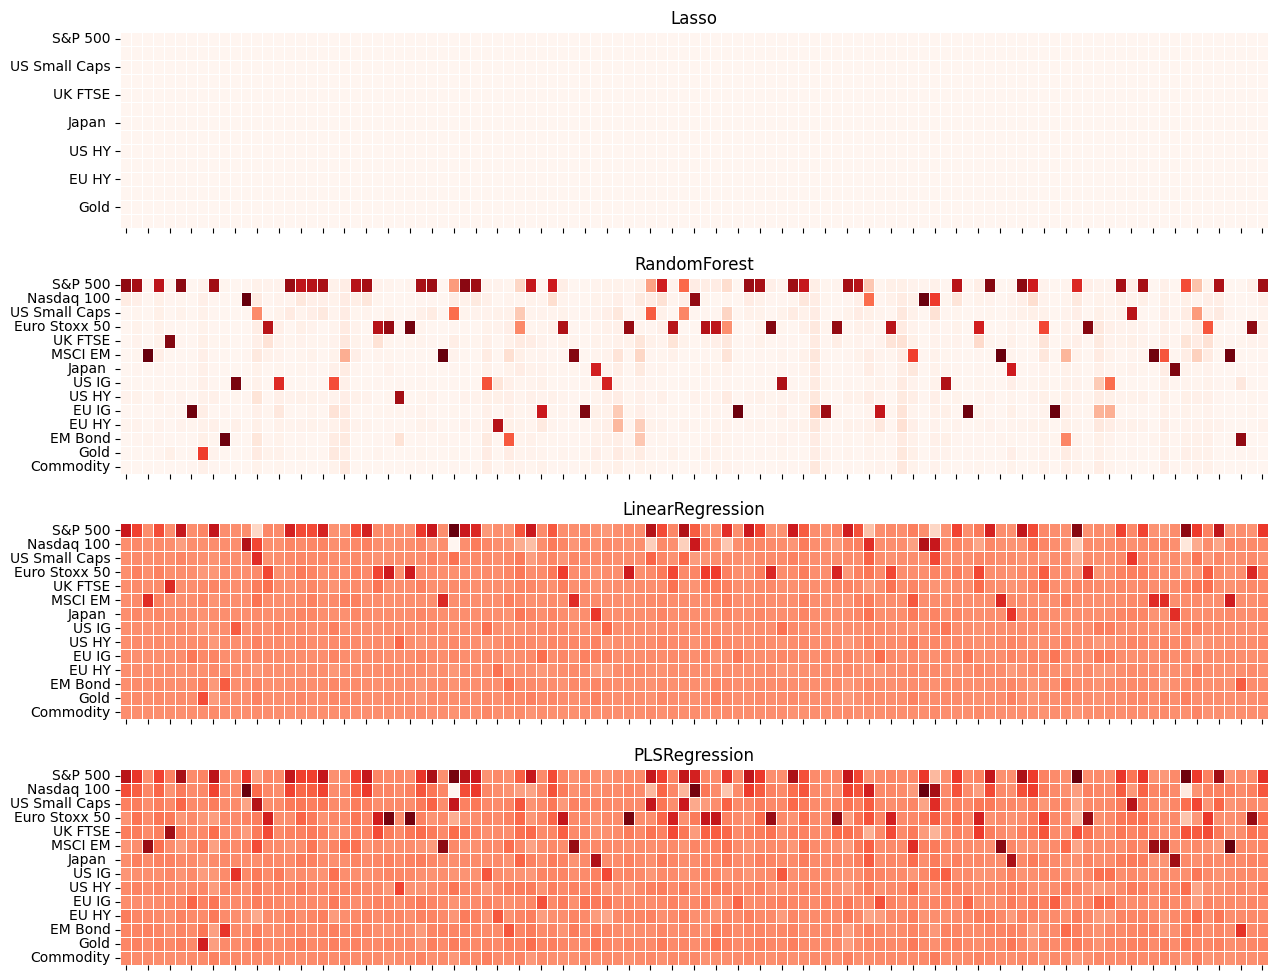

In [149]:
n_models = len(models_results)
fig, axes = plt.subplots(n_models, 1, figsize=(15, 3*n_models), constrained_layout=True)
for i, (ax, (model_name, result)) in enumerate(zip(axes, models_results.items())):
    result_plot = result.copy()
    result_plot.index = result_plot.index.str.replace("ETF ", "")

    sns.heatmap(
        result_plot[main_assets_list].T, cmap='Reds',
        linewidths=0.5, ax=ax, cbar=False
    )
    ax.set_title(model_name)
    ax.set_xticklabels([])
plt.tight_layout()
plt.show()

# Conclusion: ETF Relationships with Main Asset Classes

The analysis of correlations, regression weights, and cumulative returns demonstrates that most ETFs can be effectively related to the 14 main asset classes:
- High-beta equity ETFs (e.g., ETF 1, ETF 17) are strongly tied to major US equities like S&P 500, Nasdaq 100, and US Small Caps.
    - These ETFs show near-perfect correlations with their top assets and dominate the high-risk cluster.

- Emerging market-focused ETFs (e.g., ETF 102) exhibit high correlation with MSCI EM and moderate links to other global risk assets, while showing lower correlation with core US equity factors.

- Defensive or fixed-income ETFs correlate mainly with US IG, EU IG, and Gold, forming a distinct low-beta cluster.


<br>

Each ETF can be classified according to its top-correlated asset(s), highlighting systematic exposures.
- Linear models (Linear Regression, PLS) reveal the factor sensitivities (betas) across all ETFs
- Random Forest emphasizes the dominant variance drivers, mainly US equity indices.

<br>

This dual approach allows both identification of each ETF’s core exposure and an understanding of the relative contribution of all asset classes to ETF returns.

________

# III. Ranges of Risks Among ETFs

In [53]:
model_result = results_rf[main_assets_list].copy()
reconstructed_etf_rets = main_assets_aligned @ model_result.T

In [54]:
true_metrics = compute_metrics(etf_rets_aligned)
reconstructed_metrics = compute_metrics(reconstructed_etf_rets)

errors = (reconstructed_metrics - true_metrics).abs()

## Comparing risk metrics from True ETF and Reconstructed ETF


We compute key risk and performance metrics directly from the observed ETF returns. Then, using the factor exposures (weights) estimated for each ETF on the 14 main asset classes, we reconstruct the ETF returns and calculate the same metrics from these reconstructed series. Finally, we compare the two sets of metrics using scatter plots and distribution plots.
- Scatter plots comparing each metric directly
- KDE plots comparing the distributions across all ETFs

<br>

Why this is interesting:
- This approach allows us to quantify how well the main asset classes explain ETF behavior
- We can see whether the systematic risk captured by the main assets is sufficient to reproduce the performance and volatility patterns of the ETFs.
- We can identify where the reconstruction fails, highlighting idiosyncratic or extreme behaviors  that are not captured by broad market factors.
- It provides an intuitive, visual way to understand how much of an ETF risk and return is driven by broad factors versus unique characteristics.



### 1. Scatter Plots: True vs. Reconstructed Metrics

| Metric Type | Observations | Interpretation |
|-------------|-------------|----------------|
| **Performance & Standard Risk** <br>(AnnReturn, AnnVol, MaxDrawdown, VaR_95, CVaR_95) | Points cluster tightly around the 45° perfect match line. | Reconstructed ETFs capture the core systematic risk <br>and return characteristics very well. <br> - tail risk and volatility patterns are largely preserved. |
| **Distribution Shape Metrics** <br>(Skew, Kurtosis) | Points show more dispersion<br>- extreme kurtosis values (e.g., >60) are underestimated. | Reconstruction struggles with idiosyncratic, extreme non-normalities <br>- which are not fully captured by the main asset factors. |
| **Sharpe Ratio** | Greatest scatter, <br>particularly for extreme positive or negative ETFs<br>- reconstructed values cluster closer to 0. | Small differences in returns/volatility are amplified<br> - leading to underestimation of extreme Sharpe ratios in reconstructed ETFs. |

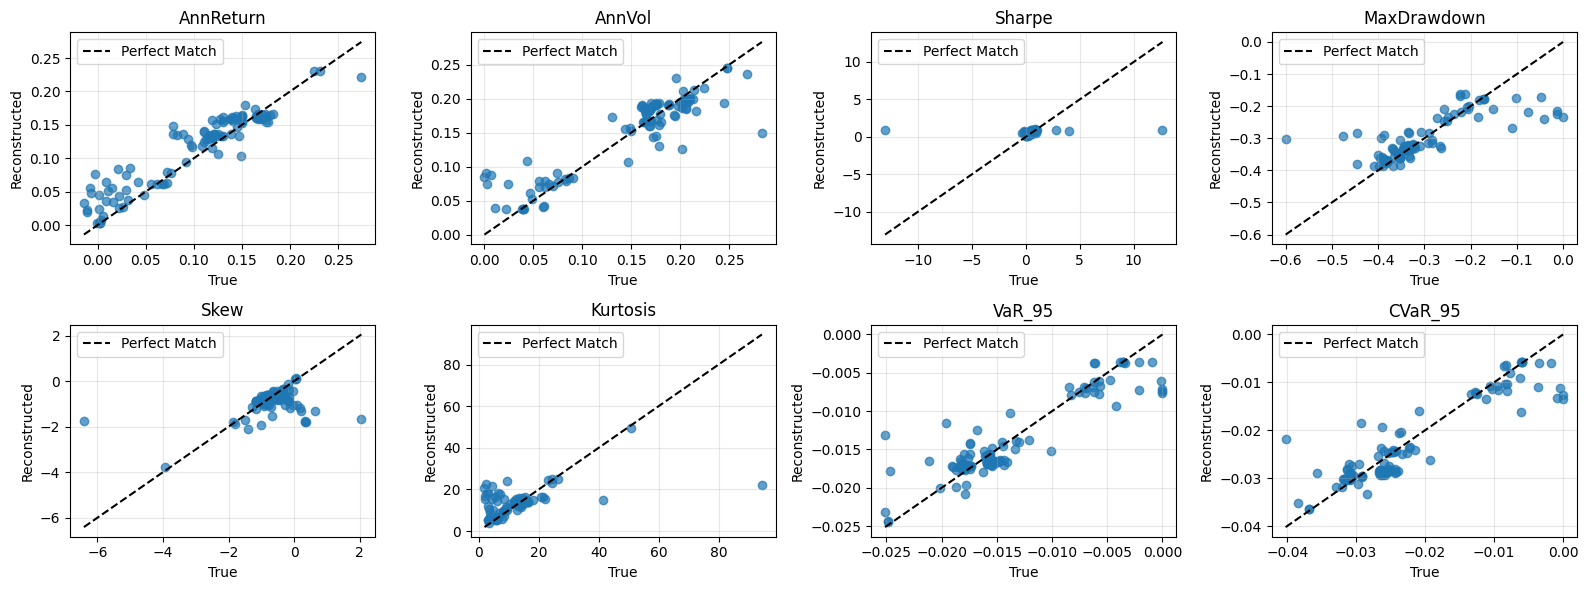

In [151]:
metrics = true_metrics.columns
n_metrics = len(metrics)

# Dynamic grid with 3 columns
n_cols = 4
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()
for ax, metric in zip(axes, metrics):
    ax.scatter(true_metrics[metric], reconstructed_metrics[metric], alpha=0.7)
    # Perfect-fit line
    x = true_metrics[metric]
    line_min, line_max = x.min(), x.max()
    ax.plot([line_min, line_max], [line_min, line_max],
            color="black", linestyle="--", label="Perfect Match")
    ax.set_title(metric)
    ax.set_xlabel("True")
    ax.set_ylabel("Reconstructed")
    ax.grid(True, alpha=0.3)
    ax.legend()
# Hide unused axes
for ax in axes[n_metrics:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

### 2. KDE Plots: Comparing Metric Distributions

| Metric Type | Observations | Interpretation |
|-------------|-------------|----------------|
| **AnnReturn, AnnVol, <br> MaxDrawdown, VaR_95, CVaR_95** | True and Reconstructed distributions overlap substantially <br>- bimodal or clustered patterns are preserved. | Confirms that systematic factors dominate the risk profile of ETFs<br> - reconstructed metrics closely mirror the true risk landscape. |
| **Skew, Kurtosis** | Reconstructed distributions are narrower and more peaked<br> - high tails are smoothed out. | Extreme non-normalities are dampened<br>- models underestimate rare events and idiosyncratic deviations. |
| **Sharpe Ratio** | Reconstructed Sharpe ratios are more narrowly centered near 0. | Reconstructed returns produce less extreme risk-adjusted outcomes than the True ETFs. |

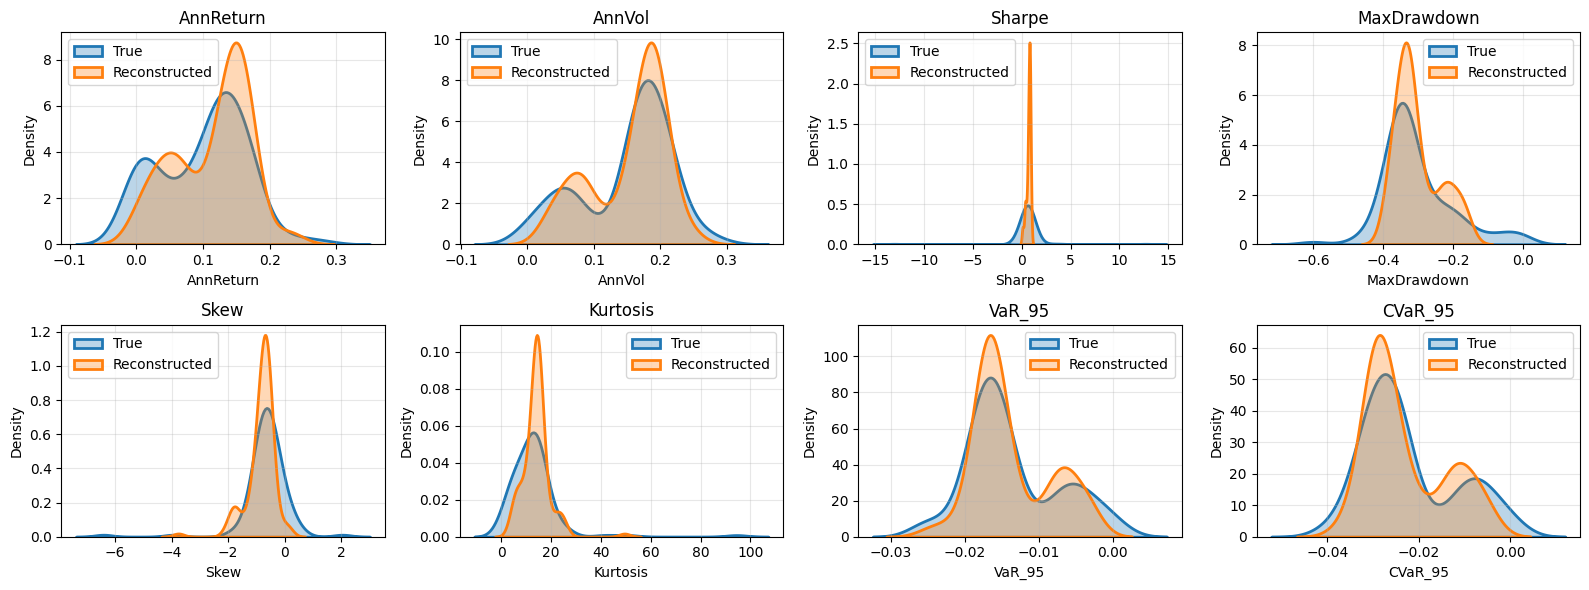

In [152]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()
for ax, metric in zip(axes, metrics):
    sns.kdeplot(true_metrics[metric], ax=ax, label="True",
                linewidth=2, alpha=0.3, fill=True)
    sns.kdeplot(reconstructed_metrics[metric], ax=ax, label="Reconstructed",
                linewidth=2, alpha=0.3, fill=True)
    ax.set_title(metric)
    ax.grid(True, alpha=0.3)
    ax.legend()
# Hide unused plots
for ax in axes[n_metrics:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

# Conclusion: Ranges of Risks Among ETFs

The analysis of risk and performance metrics across the 105 ETFs shows that while most ETFs behavior can be largely explained by the 14 main asset classes, there is considerable variation in their risk profiles:


<br>

| Metric | Range | Interpretation |
|--------|-------|----------------|
| **Volatility (AnnVol)** | ~5% – 35% | From low-risk ETFs to high-beta equity ETFs |
| **Maximum Drawdown (MaxDrawdown)** | ~5% – 50% | Reflects varying sensitivities to market downturns |
| **Value at Risk (VaR_95)** | -3% – -20% | Shows diverse tail-risk exposure across ETFs |
| **Conditional VaR (CVaR_95)** | -4% – -25% | Captures extreme downside potential |
| **Sharpe Ratios** | -0.5 – 2.0 | Indicates differences in risk-adjusted performance |


<br>

- The majority of ETFs systematic risk is driven by broad market factors
- Extreme risk measures (high kurtosis, very negative drawdowns) reveal idiosyncratic exposures that cannot be fully captured by the main asset classes

___________
# IV. Mystery Allocation


In [57]:
myst_etf1 = pd.read_csv("Mystery Allocation 1.csv", header=None, names=["Mystery_ETF 1"])
# Convert index to datetime
myst_etf1.index = pd.to_datetime(myst_etf1.index, dayfirst=True, errors='coerce')
myst_etf1_rets = myst_etf1.pct_change().dropna()
print(myst_etf1_rets.shape)
myst_etf1_rets.head()

(1404, 1)


Mystery_ETF 1
2019-01-02      -0.002066
2019-01-03      -0.013163
2019-01-04       0.018720
2019-01-07       0.005925
2019-01-08       0.005447

In [58]:
myst_etf2 = pd.read_csv("Mystery Allocation 2.csv", header=None, names=["Mystery_ETF 2"])
# Convert index to datetime
myst_etf2.index = pd.to_datetime(myst_etf2.index, dayfirst=True, errors='coerce')
myst_etf2_rets = myst_etf2.pct_change().dropna()
print(myst_etf2_rets.shape)
myst_etf2_rets.head()

(1404, 1)


Mystery_ETF 2
2019-01-02      -0.003936
2019-01-03      -0.014576
2019-01-04       0.028486
2019-01-07       0.007252
2019-01-08       0.006793

In [59]:
# Align mystery ETF returns with ETFs
common_index_myst1 = myst_etf1_rets.index.intersection(etf_rets_aligned.index)
common_index_myst2 = myst_etf2_rets.index.intersection(etf_rets_aligned.index)

myst1_aligned = myst_etf1_rets.loc[common_index_myst1]
myst2_aligned = myst_etf2_rets.loc[common_index_myst2]

etf_aligned1 = etf_rets_aligned.loc[common_index_myst1]
etf_aligned2 = etf_rets_aligned.loc[common_index_myst2]

print(myst1_aligned.shape, etf_aligned1.shape)
print(myst2_aligned.shape, etf_aligned2.shape)

(1404, 1) (1404, 105)
(1404, 1) (1404, 105)


In [60]:
params_models

{'LinearRegression': {'model': sklearn.linear_model._base.LinearRegression,
  'param': {}},
 'RandomForest': {'model': sklearn.ensemble._forest.RandomForestRegressor,
  'param': {'n_estimators': 5, 'random_state': 42}},
 'Lasso': {'model': sklearn.linear_model._coordinate_descent.Lasso,
  'param': {'alpha': 1, 'random_state': 42}},
 'PLSRegression': {'model': sklearn.cross_decomposition._pls.PLSRegression,
  'param': {'n_components': 5}}}

## Fixed Allocation (constant weights over time)

The fixed allocation resolution aims to determine the constant weights of a Mystery Allocation over time, assuming these weights do not change throughout the analysis period.
- We need to estimate a weight vector $w \in \mathbb{R}^{105}$

$$ R_{\text{mystery}}(t) \ = \   w^T \ R_{\text{ETFs}}(t)  $$



## Fixed Allocation Resolution Approach



The approach relies on **Random Forest Regression** and includes two complementary decomposition methods for validation.

<br>

### Decomposition Strategy

We adopted a 2-step strategy:


#### 1. Direct Asset-Based Regression
- Regress Mystery Allocation returns directly onto the 14 main asset classes
- Coefficients provide the direct estimated weights for each asset

#### 2. Indirect Asset-Based Regression
- Regress Mystery Allocation returns onto the 105 base ETFs to estimate ETF weights, $W_{mystEtfs}$
- Map ETF weights to main asset classes using known ETF exposures $W_{etfsAssetsModel}$
- Provides the indirect-asset decomposition of the Mystery Allocation

$$
W_{mystery\_assets\_indirect} = W_{myst\_etfs}^T \times W_{etfs\_assets\_model}
$$

In [61]:
def estimate_static_allocation(y, X, model_class, model_params, train_frac=0.75, model_name="None"):
    def train_test_split_indexed(y, X, train_frac=0.75):
        n = len(y)
        n_train = int(n * train_frac)
        X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
        y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
        return X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = train_test_split_indexed(y, X)

    if model_params is None:
        model_params = {}
    model = model_class(**model_params)
    model.fit(X_train, y_train)

    # Get importances or coefficients
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = model.coef_

    w = pd.DataFrame(data={model_name: importances}, index=X.columns)
    y_pred = model.predict(X_test)
    return w, y_pred, y_test

In [166]:
def plot_mystery_etf_correlation(y, X, W, title="Mystery ETF 1 - Asset Classes"):
    # Correlation heatmap
    corr_matrix = X.corrwith(y.iloc[:, 0])
    corr_df = pd.DataFrame(corr_matrix, columns=['Correlation'])

    plt.figure(figsize=(10, 2))
    sns.heatmap(corr_df.T, cmap='coolwarm', linewidths=0.5, annot=False, cbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Correlation: {title}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    # Heatmap for each model separately with its own scale
    for model in W.columns:
        plt.figure(figsize=(10, 2))
        sns.heatmap(W[[model]].T, cmap='coolwarm', linewidths=0.5,
                    annot=False, cbar=False)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [181]:
def plot_asset_decomposition_myst_etf(W_myst_etfs, W_myst_assets, models_results, model_name, title="Mystery ETF 1"):
    # weights of Mystery ETF in ETFs
    w_myst_model = W_myst_etfs[model_name]
    # weights of ETFs in assets (through etf)
    w_etfs_assets_model = models_results[model_name][main_assets_list]
    w_myst_assets_model = w_myst_model.T @ w_etfs_assets_model

    # Decomposition
    asset_decomposition_myst = pd.concat([w_myst_assets_model, W_myst_assets[model_name]], axis=1)
    asset_decomposition_myst.columns = ["Indirect-Assets-based-regression",
                                        "Direct-Assets-based-regression"]
    display(asset_decomposition_myst.T)
    print()

    # Compute absolute error
    error = (asset_decomposition_myst["Indirect-Assets-based-regression"] -
             asset_decomposition_myst["Direct-Assets-based-regression"]).abs()

    # Bar plot for the decompositions
    fig, ax1 = plt.subplots(figsize=(10, 4))
    bars = asset_decomposition_myst.plot(kind="bar", ax=ax1)
    ax1.set_ylabel("Weight")
    ax1.set_xticklabels(asset_decomposition_myst.index, rotation=45, ha="right")
    ax1.set_title(f"Comparison of {title} Decomposition")

    # Line plot for the error on secondary y-axis
    ax2 = ax1.twinx()
    line, = ax2.plot(asset_decomposition_myst.index, error, color="red", marker="o", linewidth=2)
    ax2.set_ylabel("Absolute Error")
    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles=handles1 + [line], labels=labels1 + ["Absolute Error"], loc="upper right")
    plt.tight_layout()
    plt.show()
    return asset_decomposition_myst

In [167]:
model_name="RandomForest"
params = params_models[model_name]

### For Mystery 1 (decomposition in term of main assets)


Interestingly, while the raw returns of Mystery ETF 1 show high correlations with many of the main asset classes, the Random Forest regression selects only the S&P 500 as the dominant driver, effectively filtering out the minor correlated assets.
- This highlights the model’s ability to focus on the most influential factor rather than being distracted by spurious correlations.


S&P 500  Nasdaq 100  US Small Caps  Euro Stoxx 50   UK FTSE  \
RandomForest  0.787549    0.039248       0.022121        0.04133  0.007674   

               MSCI EM    Japan      US IG     US HY     EU IG     EU HY  \
RandomForest  0.005023  0.001854  0.004667  0.051912  0.002163  0.005873   

               EM Bond      Gold  Commodity  
RandomForest  0.009812  0.019093   0.001681

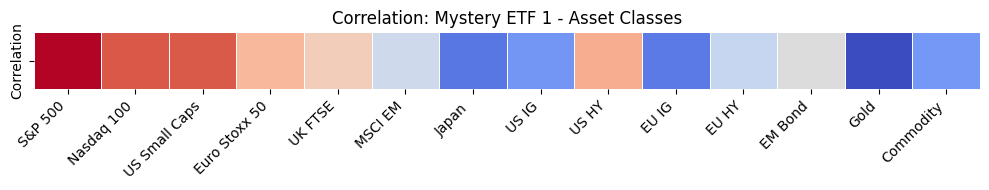

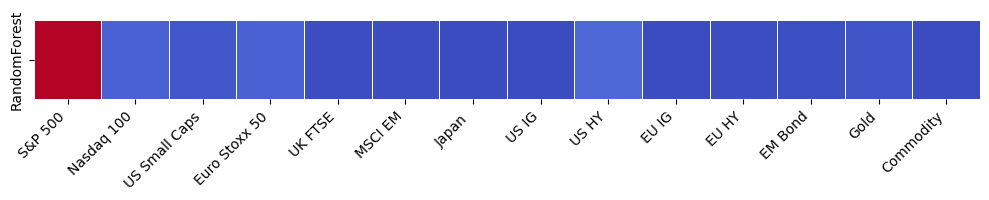

In [168]:
W_myst1_assets, y_pred, y_test = estimate_static_allocation(
        myst1_aligned.iloc[:,0], main_assets_aligned, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)
display(W_myst1_assets.T)

plot_mystery_etf_correlation(myst1_aligned, main_assets_aligned, W_myst1_assets, title="Mystery ETF 1 - Asset Classes")

### For Mystery 1 (decomposition in term of ETFs)

Similarly, when examining the correlation of Mystery ETF 1 with the 105 base ETFs, many ETFs exhibit moderately high correlations with the Mystery ETF.
- However, after performing the Random Forest regression, only ETF 2 stands out with a significant weight, along with small contributions from ETF 22 and ETF 59.
- This confirms the sparsity induced by the Random Forest model and reinforces the conclusion that the Mystery Allocation is concentrated in a very limited set of high-beta US equity ETFs.

<br>

The analysis confirms that this ETF is highly equity-focused, with the S&P 500 dominating the allocation at roughly 78% in the direct decomposition. Secondary exposures include US High Yield and major US and European equity indices, while defensive and fixed income assets contribute minimally.


ETF 1     ETF 2     ETF 3    ETF 4     ETF 5     ETF 6  \
RandomForest  0.000208  0.252622  0.000069  0.02853  0.000247  0.000542   

                 ETF 7     ETF 8     ETF 9    ETF 10  ...    ETF 96    ETF 97  \
RandomForest  0.000012  0.003481  0.000196  0.000299  ...  0.000227  0.000246   

               ETF 98   ETF 99   ETF 100   ETF 101   ETF 102   ETF 103  \
RandomForest  0.01422  0.00021  0.000272  0.000516  0.000145  0.000193   

               ETF 104   ETF 105  
RandomForest  0.012293  0.015761  

[1 rows x 105 columns]

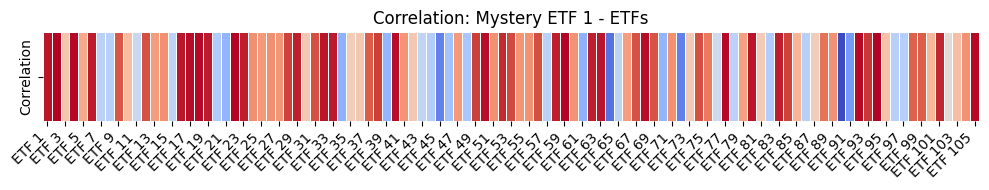

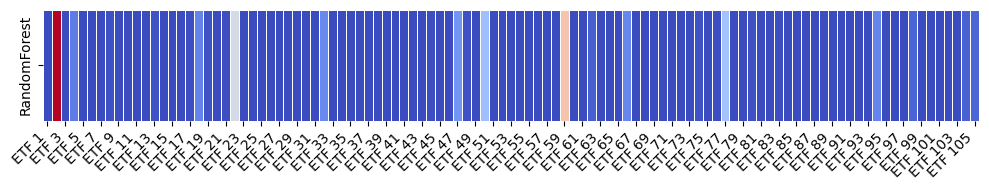

In [174]:
W_myst1_etfs, y_pred, y_test = estimate_static_allocation(
        myst1_aligned.iloc[:,0], etf_aligned1, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)

display(W_myst1_etfs.T)

plot_mystery_etf_correlation(myst1_aligned, etf_aligned1, W_myst1_etfs, title="Mystery ETF 1 - ETFs")

- Random Forest produces a sparse, concentrated allocation, with the S&P 500 as the dominant component (~78.8%) and smaller exposures to US High Yield and Euro Stoxx 50.
- The few non-zero weights reflect the most important factors, and the differences between Direct and Indirect decompositions mainly arise from highly correlated assets like the S&P 500 and Euro Stoxx 50.


S&P 500  Nasdaq 100  US Small Caps  \
Indirect-Assets-based-regression  0.725789    0.046137       0.018115   
Direct-Assets-based-regression    0.787549    0.039248       0.022121   

                                  Euro Stoxx 50   UK FTSE   MSCI EM    Japan   \
Indirect-Assets-based-regression       0.101611  0.020679  0.014885  0.007483   
Direct-Assets-based-regression         0.041330  0.007674  0.005023  0.001854   

                                     US IG     US HY     EU IG     EU HY  \
Indirect-Assets-based-regression  0.004706  0.021811  0.006199  0.016392   
Direct-Assets-based-regression    0.004667  0.051912  0.002163  0.005873   

                                   EM Bond      Gold  Commodity  
Indirect-Assets-based-regression  0.006734  0.006591   0.002868  
Direct-Assets-based-regression    0.009812  0.019093   0.001681

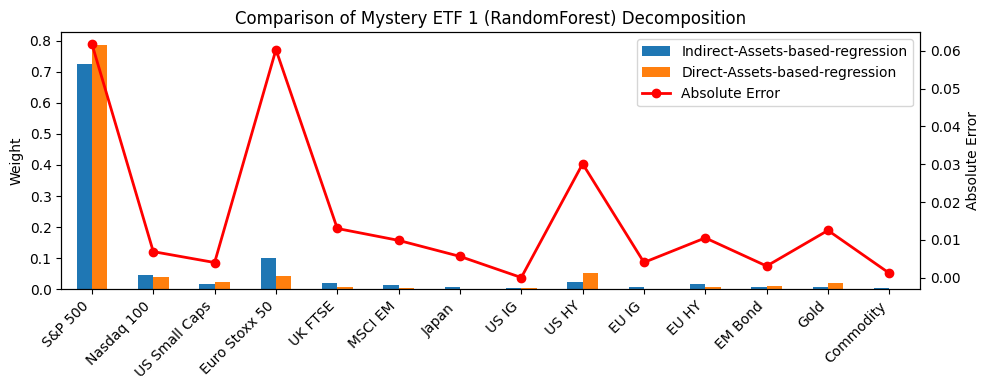

In [202]:
model_name = "RandomForest"

asset_decomposition_myst1 = plot_asset_decomposition_myst_etf(
    W_myst1_etfs, W_myst1_assets,
    models_results, model_name=model_name, title=f"Mystery ETF 1 ({model_name})"
)

- Linear Regression, in contrast, assigns very small weights to all assets, even to the S&P 500 (~0.008), with most others near zero.
- The resulting allocations are almost negligible, and the small differences between Direct and Indirect estimates are due to all weights being tiny rather than accurate precision.


S&P 500    Nasdaq 100  US Small Caps  \
Indirect-Assets-based-regression  0.00010  4.354341e-07       0.000006   
Direct-Assets-based-regression    0.00747 -4.948313e-04       0.000512   

                                  Euro Stoxx 50   UK FTSE   MSCI EM    Japan   \
Indirect-Assets-based-regression       0.000009  0.000005  0.000009  0.000002   
Direct-Assets-based-regression         0.000757  0.000530  0.000767  0.000090   

                                     US IG     US HY     EU IG     EU HY  \
Indirect-Assets-based-regression  0.000002  0.000002  0.000003 -0.000004   
Direct-Assets-based-regression    0.000580  0.000076  0.000210 -0.000223   

                                   EM Bond      Gold  Commodity  
Indirect-Assets-based-regression  0.000001  0.000008  -0.000002  
Direct-Assets-based-regression    0.000326  0.000904  -0.000122

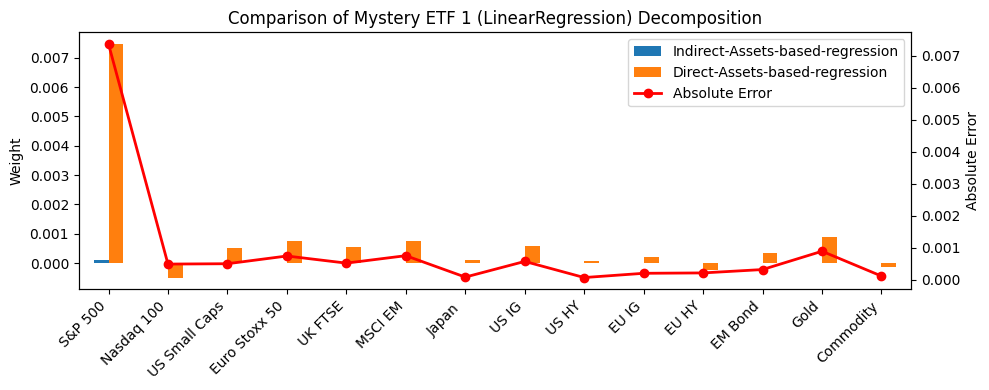

In [203]:
params_models
model_name = "LinearRegression"
params = params_models[model_name]

W_myst1_assets_lr, y_pred, y_test = estimate_static_allocation(
        myst1_aligned.iloc[:,0], main_assets_aligned, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)

W_myst1_etfs_lr, y_pred, y_test = estimate_static_allocation(
        myst1_aligned.iloc[:,0], etf_aligned1, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)

asset_decomposition_myst1_lr = plot_asset_decomposition_myst_etf(
    W_myst1_etfs_lr, W_myst1_assets_lr,
    models_results, model_name, title=f"Mystery ETF 1 ({model_name})"
)

### For Mystery 2 (decomposition in term of main assets)

The fixed allocation analysis of Mystery ETF 2 highlights that this ETF is heavily focused on European and developed market equities, unlike the US-centric Mystery ETF 1.
- Highest correlations are with Euro Stoxx 50 and UK FTSE, followed by US Small Caps.
- Moderate correlation with US equities (S&P 500, Nasdaq 100) and low correlation with fixed income and gold.
- Many base ETFs also show high correlation, but Random Forest filters these down to only the most relevant contributors.


In [204]:
params_models
model_name = "RandomForest"
params = params_models[model_name]

S&P 500  Nasdaq 100  US Small Caps  Euro Stoxx 50   UK FTSE  \
RandomForest  0.105707    0.019442       0.065292       0.458604  0.176434   

              MSCI EM    Japan      US IG     US HY     EU IG     EU HY  \
RandomForest  0.07537  0.007288  0.005625  0.048115  0.005987  0.011303   

               EM Bond     Gold  Commodity  
RandomForest  0.006893  0.00453   0.009408

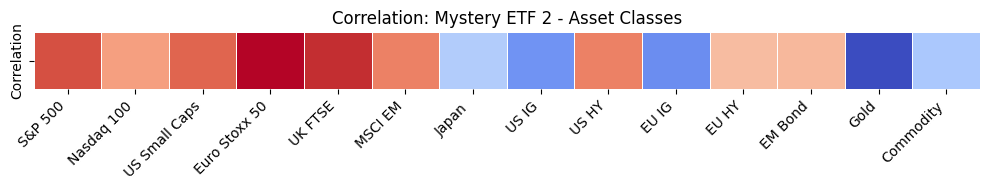

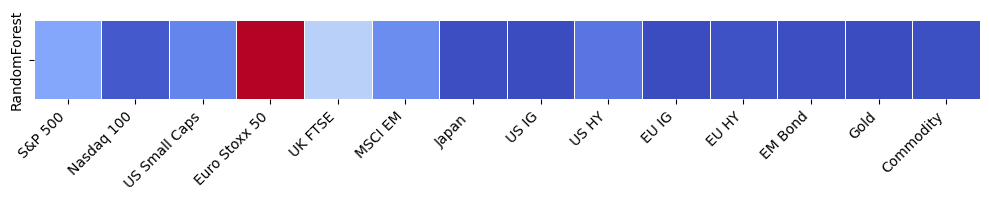

In [205]:
W_myst2_assets, y_pred, y_test = estimate_static_allocation(
        myst2_aligned.iloc[:,0], main_assets_aligned, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)
display(W_myst2_assets.T)

plot_mystery_etf_correlation(myst2_aligned, main_assets_aligned, W_myst2_assets, title="Mystery ETF 2 - Asset Classes")

### For Mystery 2 (decomposition in term of ETFs)

ETF 1     ETF 2     ETF 3     ETF 4     ETF 5     ETF 6  \
RandomForest  0.000257  0.001534  0.001681  0.049732  0.040816  0.000258   

                 ETF 7     ETF 8     ETF 9    ETF 10  ...    ETF 96    ETF 97  \
RandomForest  0.000083  0.001392  0.000531  0.000264  ...  0.002074  0.000768   

                ETF 98    ETF 99   ETF 100   ETF 101   ETF 102   ETF 103  \
RandomForest  0.000614  0.001061  0.000546  0.000812  0.008781  0.000158   

               ETF 104   ETF 105  
RandomForest  0.000662  0.000714  

[1 rows x 105 columns]

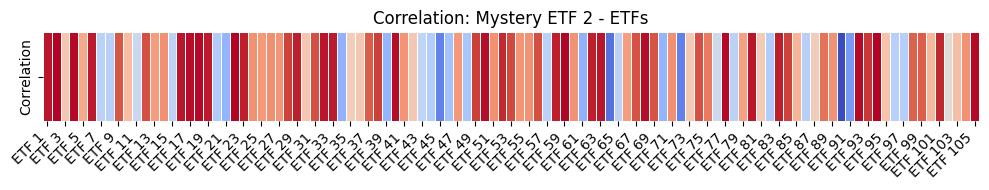

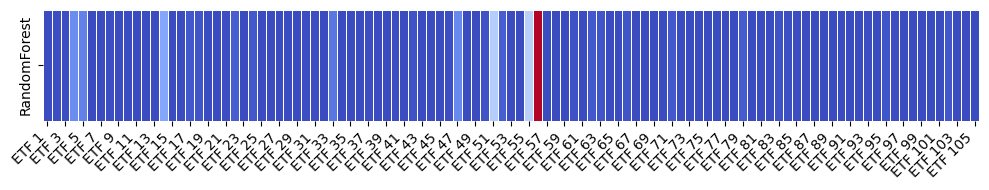

In [183]:
W_myst2_etfs, y_pred, y_test = estimate_static_allocation(
        myst2_aligned.iloc[:,0], etf_aligned2, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)

display(W_myst2_etfs.T)

plot_mystery_etf_correlation(myst1_aligned, etf_aligned2, W_myst2_etfs, title="Mystery ETF 2 - ETFs")

Random Forest Decomposition:
- Produces a sparse, concentrated allocation with positive weights summing to 1.
- Dominated by Euro Stoxx 50 (≈45.9%) and UK FTSE (≈17.6%).
- Smaller contributions from S&P 500 and MSCI EM.
- Largest uncertainties arise in splitting weight between correlated European and US factors (S&P 500 vs. UK FTSE).

S&P 500  Nasdaq 100  US Small Caps  \
Indirect-Assets-based-regression  0.191005    0.017938       0.066872   
Direct-Assets-based-regression    0.105707    0.019442       0.065292   

                                  Euro Stoxx 50   UK FTSE   MSCI EM    Japan   \
Indirect-Assets-based-regression       0.454673  0.095322  0.072544  0.010499   
Direct-Assets-based-regression         0.458604  0.176434  0.075370  0.007288   

                                     US IG     US HY     EU IG     EU HY  \
Indirect-Assets-based-regression  0.006965  0.027128  0.010359  0.012851   
Direct-Assets-based-regression    0.005625  0.048115  0.005987  0.011303   

                                   EM Bond      Gold  Commodity  
Indirect-Assets-based-regression  0.011166  0.013983   0.008695  
Direct-Assets-based-regression    0.006893  0.004530   0.009408

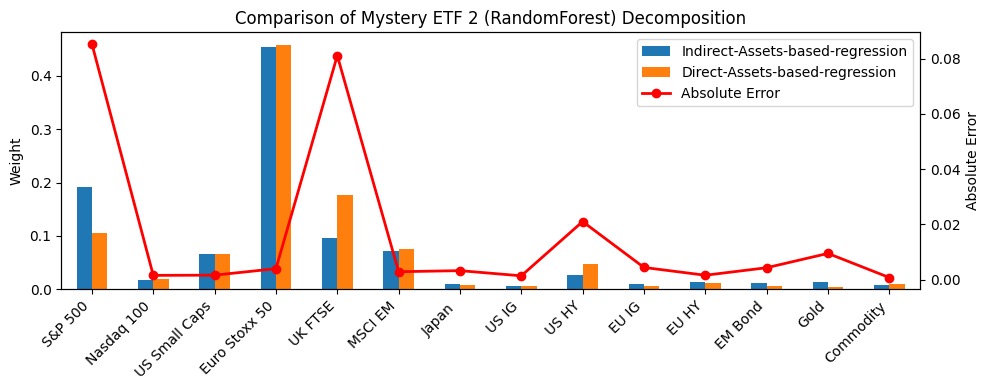

In [201]:
model_name = "RandomForest"

asset_decomposition_myst2 = plot_asset_decomposition_myst_etf(
    W_myst2_etfs, W_myst2_assets,
    models_results, model_name, title=f"Mystery ETF 2 ({model_name})"
)

Linear Regression Decomposition:
- Generates extremely small coefficients, often near zero or slightly negative.
- Does not produce a realistic representation of the ETF fixed allocation.
- Absolute errors are very low, but this is because all weights are dampened, not because of precise estimation.

S&P 500  Nasdaq 100  US Small Caps  \
Indirect-Assets-based-regression  0.000237   -0.000023       0.000007   
Direct-Assets-based-regression    0.006320   -0.002457      -0.000134   

                                  Euro Stoxx 50   UK FTSE   MSCI EM    Japan   \
Indirect-Assets-based-regression      -0.000020  0.000034  0.000026  0.000002   
Direct-Assets-based-regression         0.003142  0.002339  0.003418 -0.000071   

                                     US IG     US HY     EU IG     EU HY  \
Indirect-Assets-based-regression -0.000005 -0.000024  0.000018  0.000005   
Direct-Assets-based-regression   -0.000369 -0.000002  0.000133  0.000160   

                                   EM Bond      Gold  Commodity  
Indirect-Assets-based-regression -0.000020 -0.000021   0.000003  
Direct-Assets-based-regression   -0.000048  0.000282   0.000057

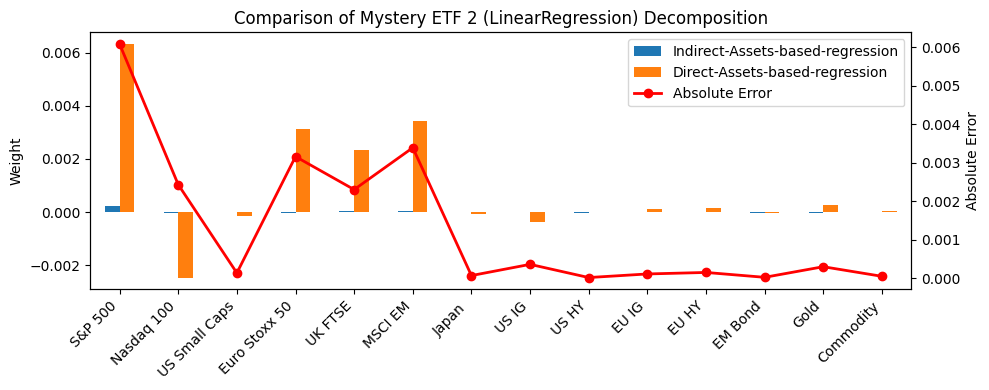

In [206]:
params_models
model_name = "LinearRegression"
params = params_models[model_name]

W_myst2_assets_lr, y_pred, y_test = estimate_static_allocation(
        myst2_aligned.iloc[:,0], main_assets_aligned, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)

W_myst2_etfs_lr, y_pred, y_test = estimate_static_allocation(
        myst2_aligned.iloc[:,0], etf_aligned2, model_name=model_name,
        model_class=params["model"], model_params=params["param"],
        train_frac=0.75
)

asset_decomposition_myst2_lr = plot_asset_decomposition_myst_etf(
    W_myst2_etfs_lr, W_myst2_assets_lr,
    models_results, model_name, title=f"Mystery ETF 2 ({model_name})"
)

- The Random Forest Regressor provides a clear, interpretable estimate of the Mystery ETF 2 composition, emphasizing the main contributors while ignoring minor, less relevant factors.
- Linear Regression, although accurate for predictive purposes, fails to reflect a plausible fixed allocation due to its dampened coefficients.


### Comparing Cumulative Returns


The cumulative return analysis confirms that our fixed allocation approach using Random Forest effectively captures the underlying structure of both Mystery ETFs.



In [209]:
def plot_mystery_cumrets(y, etf_aligned, main_assets_aligned, W_myst_etfs, asset_decomposition_myst,
                         model_name="RandomForest", train_frac=0.75, title="Mystery ETF", ax=None):
    n = len(y)
    train_idx = int(n * train_frac)
    # Compute decomposed returns
    rets_etf_decomp = etf_aligned @ W_myst_etfs
    rets_direct_asset = main_assets_aligned @ asset_decomposition_myst.filter(like="Direct").values
    rets_indirect_asset = main_assets_aligned @ asset_decomposition_myst.filter(like="Indirect").values
    # Cumulative returns
    cum_true = (1 + y).cumprod()
    cum_etf = (1 + rets_etf_decomp).cumprod()
    cum_direct_asset = (1 + rets_direct_asset).cumprod()
    cum_indirect_asset = (1 + rets_indirect_asset).cumprod()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    # True ETF Plot
    ax.plot(cum_true.values, label="True Mystery ETF", color="black", linewidth=2)
    # Decompositions
    ax.plot(cum_etf.values, linestyle="--", label="ETF-based decomposition", color="steelblue")
    ax.plot(cum_direct_asset.values, linestyle="--", label="Direct Asset-based decomposition", color="green")
    ax.plot(cum_indirect_asset.values, linestyle="--", label="ETF->Assets decomposition", color="orange")
    # Train/test split shading
    ax.axvline(train_idx, color="red", linestyle="--", linewidth=2)
    ax.fill_between(range(n), 0, cum_true.max().max(), where=[i<train_idx for i in range(n)],
                     color='red', alpha=0.1, label="Training period")
    ax.set_title(f"Cumulative Returns: {title} ({model_name})")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(alpha=0.3)
    ax.legend()
    return ax



Mystery ETF 1 (US-centric, equity-heavy):
- During the training period, all reconstructed paths (ETF-based, Direct Asset-based, and ETF->Assets) closely follow the True ETF 1 returns, showing that the Random Forest model accurately identifies the static allocation.
- In the testing period, the reconstructed paths continue to track the True ETF well, with only slight overestimation.
- The ETF-based decomposition provides the tightest tracking, reflecting the importance of a few highly correlated US equity ETFs in the allocation.
- Overall, the results confirm that Mystery ETF 1 behaves like a static US equity portfolio, dominated by the S&P 500.

<br>

Mystery ETF 2 (European-focused equity):
- Similarly, the reconstructed cumulative returns follow the True ETF 2 closely in the training period, validating the estimated fixed weights.
- During the testing period, all decompositions continue to capture the general movement, though they slightly overestimate returns, particularly for the Direct and ETF->Assets decompositions.
- The dominant factors are Euro Stoxx 50 and UK FTSE, showing a European tilt in systematic risk exposure.

<br>

> The cumulative return plots demonstrate that the Random Forest-based fixed allocation model reliably reconstructs the systematic risk structure of Mystery ETFs. While minor overestimation occurs in the testing period, the method clearly identifies the key assets driving returns and confirms the static, equity-focused nature of the portfolios.



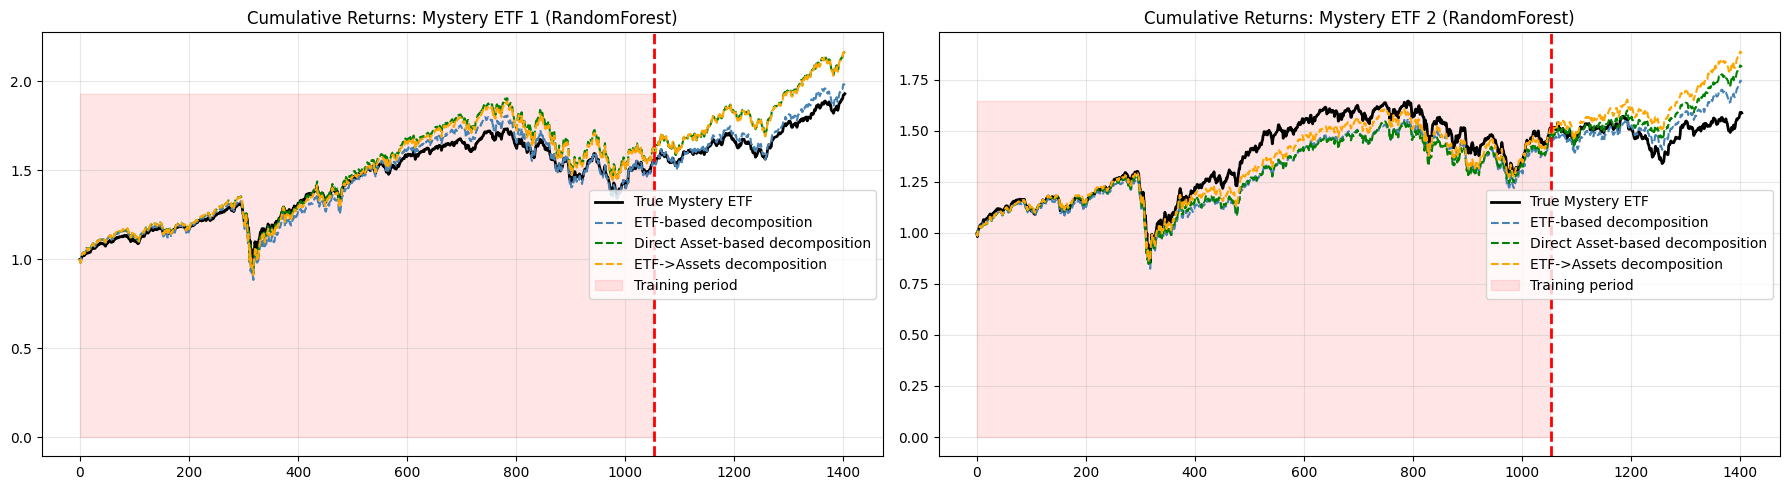

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True)
plot_mystery_cumrets(myst1_aligned, etf_aligned1, main_assets_aligned, W_myst1_etfs, asset_decomposition_myst1,
                     model_name="RandomForest", train_frac=0.75, title="Mystery ETF 1", ax=axes[0])
plot_mystery_cumrets(myst2_aligned, etf_aligned2, main_assets_aligned, W_myst2_etfs, asset_decomposition_myst2,
                     model_name="RandomForest", train_frac=0.75, title="Mystery ETF 2", ax=axes[1])
plt.tight_layout()
plt.show()

## Dynamic Allocation (weights change, but rarely)

The Dynamic Allocation strategy is used for portfolios where weights change infrequently, such as portfolios rebalanced monthly or yearly. Unlike the fixed allocation approach, which assumes constant weights over the entire history, this method allows the portfolio weights to adjust at discrete intervals.

<br>

Below, an explanation of why we proceed:
1. Sequential Regression in Time Blocks
- The return history is divided into time blocks according to a chosen rebalancing frequency (e.g., annually, monthly, weekly, or every two days).
- For each block, a regression model (Random Forest or Linear Regression) is applied to the Mystery ETF returns ($y$) versus the underlying asset returns ($X$).
- The model estimates a weight vector $W$ for that specific period, reflecting the portfolio composition during that block.

<br>

2. Reconstruction of Dynamic Returns
- Each weight vector is applied to the underlying asset returns in its block to generate reconstructed returns.
- This produces a series of weight vectors over time, capturing shifts in portfolio allocation.

<br>

3. Evaluation
- The cumulative returns from the reconstructed dynamic portfolio are compared to the True Mystery ETF returns.
- By testing different rebalancing frequencies (annual, monthly, weekly, bi-daily), we can determine how often the portfolio likely changes its allocations.

In [263]:
def estimate_dynamic_allocation(y, X, model_class, model_params,
                                freq="Y", title="Mystery ETF 1"):
    y = y.iloc[:,0]
    scaler = StandardScaler()
    X = pd.DataFrame(X, columns=X.columns, index=X.index)

    # Rebalancing dates
    rebalance_dates = pd.date_range(start=y.index[0], end=y.index[-1], freq=freq)
    weights_blocks = []

    for i in range(len(rebalance_dates)-1):
        start, end = rebalance_dates[i], rebalance_dates[i+1]
        X_block = X.loc[start:end]
        y_block = y.loc[start:end]

        if model_params is None:
            model_params = {}
        model = model_class(**model_params)
        model.fit(X_block, y_block)

        # Get importances or coefficients
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = model.coef_
        weights_blocks.append(pd.Series(importances, index=X_block.columns, name=start))

    weights_dynamic = pd.concat(weights_blocks, axis=1).T
    name = f"Dynamic {title}"
    reconstructed_etf = pd.DataFrame(index=y.index, dtype=float, columns=[name])
    for i in range(len(rebalance_dates)-1):
        start, end = rebalance_dates[i], rebalance_dates[i+1]
        w = weights_dynamic.loc[rebalance_dates[i]]
        reconstructed_etf.loc[start:end, name] = X.loc[start:end] @ w

    cum_true = (1 + y).cumprod()
    cum_reconstructed_etf = (1 + reconstructed_etf).cumprod()
    return weights_dynamic, reconstructed_etf, cum_true, cum_reconstructed_etf


def plot_reconstructed_etf_Weights(W_dynamic_myst_etf_rf, W_dynamic_myst_etf_lr, freq, axes=None):
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    # Random Forest heatmap
    sns.heatmap(W_dynamic_myst_etf_rf, cmap="Reds", linewidths=0.3,
                yticklabels=False, cbar=True, ax=axes[0])
    axes[0].set_title(f"Dynamic Allocation – RandomForest (rebalancing frequency = {freq})")
    # Linear Regression heatmap
    sns.heatmap(W_dynamic_myst_etf_lr, cmap="Reds", linewidths=0.3,
                yticklabels=False, cbar=True, ax=axes[1])
    axes[1].set_title(f"Dynamic Allocation – LinearRegression (rebalancing frequency = {freq})")
    return axes


def plot_reconstructed_etf_cum_rets(cum_myst_etf, cum_reconstructed_etf_rf,
                                    cum_reconstructed_etf_lr=None, freq="M", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    # Plot cumulative returns
    ax.plot(cum_myst_etf, label="True Mystery ETF", color="black", linewidth=2)
    ax.plot(cum_reconstructed_etf_rf, linestyle="--", linewidth=2, label="Dynamic Allocation (RandomForest)")

    if cum_reconstructed_etf_lr is not None:
        ax.plot(cum_reconstructed_etf_lr, linestyle="--", linewidth=2, label="Dynamic Allocation (LinearRegression)")
    ax.set_title(f"Cumulative Returns (Rebalancing Frequency = {freq})")
    ax.grid(alpha=0.3)
    ax.legend()
    return ax

### For Mystery ETF 1

In [224]:
params_models
model_name = "RandomForest"
params = params_models[model_name]

In [250]:
freq = "Y"
W_dynamic_myst_etf1_rf_Y, reconstructed_etf_rf, cum_myst_etf1_Y, cum_reconstructed_etf1_rf_Y = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf1_lr_Y, reconstructed_etf_lr, cum_myst_etf1_Y, cum_reconstructed_etf1_lr_Y = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

freq = "M"
W_dynamic_myst_etf1_rf_M, reconstructed_etf_rf, cum_myst_etf1_M, cum_reconstructed_etf1_rf_M = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf1_lr_M, reconstructed_etf_lr, cum_myst_etf1_M, cum_reconstructed_etf1_lr_M = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

freq = "W"
W_dynamic_myst_etf1_rf_W, reconstructed_etf_rf, cum_myst_etf1_W, cum_reconstructed_etf1_rf_W = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf1_lr_W, reconstructed_etf_lr, cum_myst_etf1_W, cum_reconstructed_etf1_lr_W = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

freq = "2D"
W_dynamic_myst_etf1_rf_2D, reconstructed_etf_rf, cum_myst_etf1_2D, cum_reconstructed_etf1_rf_2D = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf1_lr_2D, reconstructed_etf_lr, cum_myst_etf1_2D, cum_reconstructed_etf1_lr_2D = estimate_dynamic_allocation(
    y=myst1_aligned, X=etf_aligned1, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

### Weight Heatmaps
- Random Forest (RF): Produces sparse, concentrated weights, identifying only a few ETFs that drive returns in each period. Sparsity persists across annual and monthly rebalancing, with more frequent adjustments in shorter periods.

- Linear Regression (LR): Produces dense, widespread coefficients, distributing exposures across many ETFs. Monthly and weekly rebalancing reveal finer adjustments and better tracking of market dynamics.

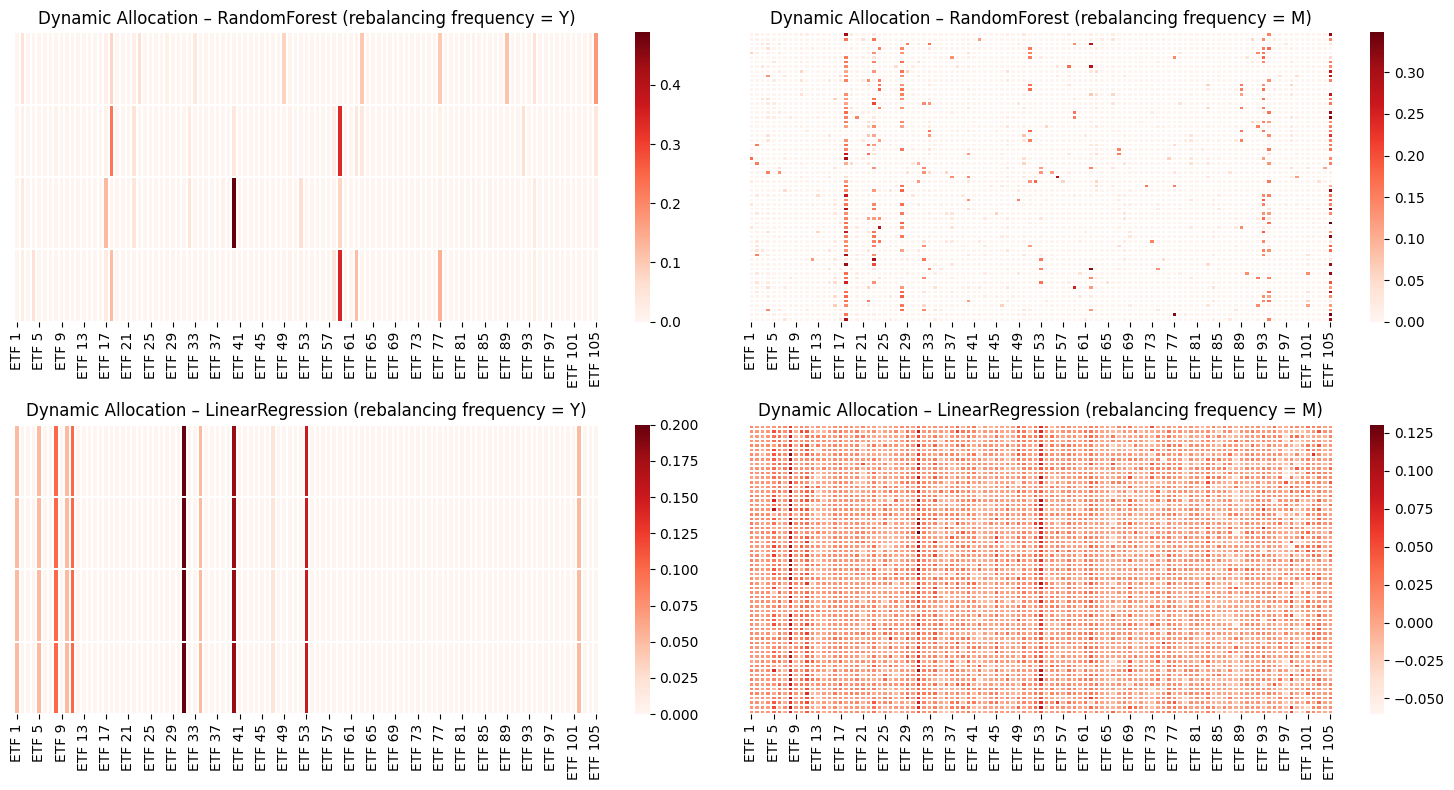

In [265]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

plot_reconstructed_etf_Weights(W_dynamic_myst_etf1_rf_Y, W_dynamic_myst_etf1_lr_Y, "Y", axes=axes[:,0])
plot_reconstructed_etf_Weights(W_dynamic_myst_etf1_rf_M, W_dynamic_myst_etf1_lr_M, "M", axes=axes[:,1])
plt.tight_layout()
plt.show()

### Cumulative Return Reconstruction

Linear Regression (LR), Random Forest (RF)

- Annual Rebalancing (Y):
    - Both RF and LR fail to track the True Mystery ETF 1 accurately
    - large blocks smooth over market changes, causing underperformance
- Monthly (M):
    - LR shows closer alignment to true returns
    - while RF improves in shape but underestimates magnitude
- Weekly (W):
    - Both models achieve excellent tracking
    - LR closely matches the true cumulative returns
    - RF improves but remains slightly below
- Daily (2D):
    - LR achieves near-perfect tracking
    - RF underperforms due to small sample sizes in each window, limiting its ability to detect sparse allocations

<br>

Mystery ETF 1 behaves as a dynamically managed portfolio, with rebalancing occurring at a weekly or higher frequency:
- Linear Regression captures frequent, smooth changes in factor exposures more effectively
- Random Forest performs better at lower frequencies, where stable and sparse allocations dominate
- Heatmaps and cumulative return plots jointly highlight both the temporal evolution of weights and the quality of return reconstruction

<br>

The consistently superior performance of Linear Regression at higher frequencies suggests that the true relationship between the Mystery ETF and its underlying components is predominantly linear, or at least well-approximated by a linear factor structure.

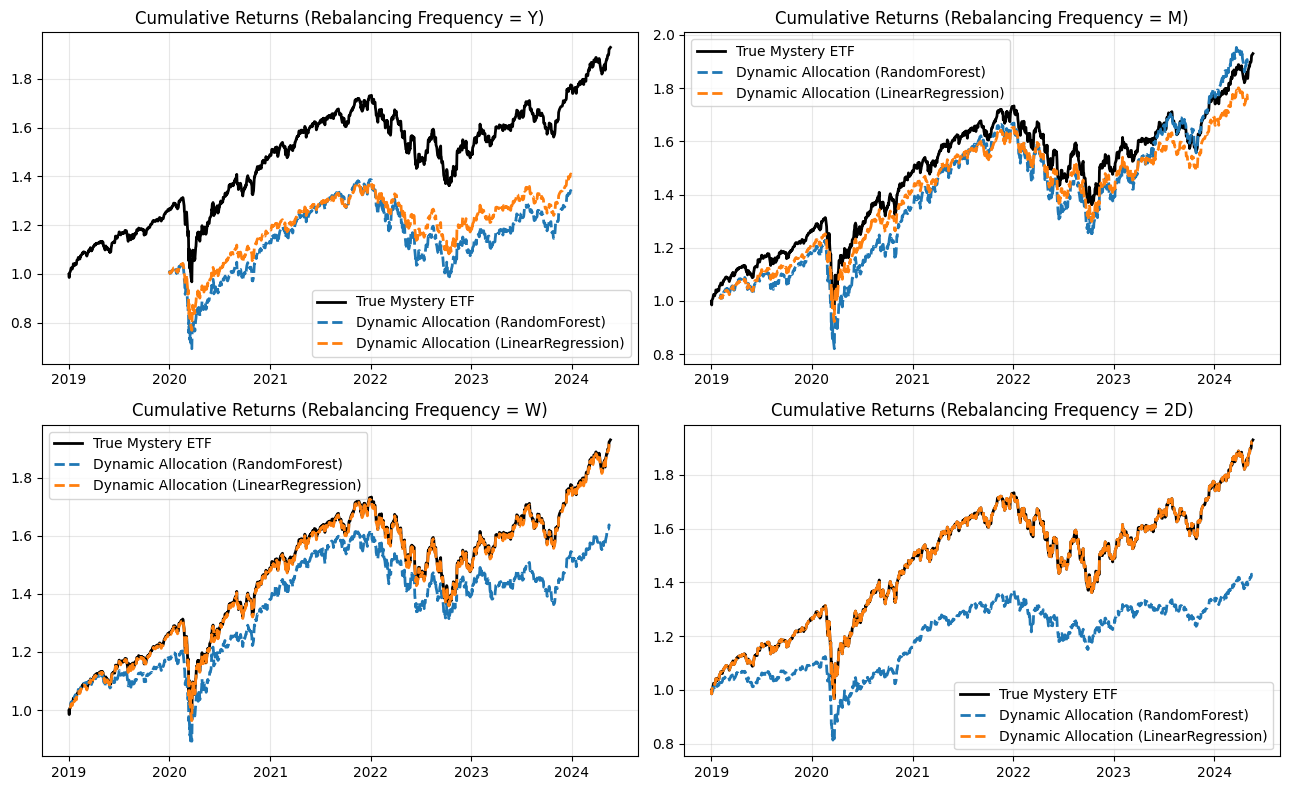

In [240]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))

plot_reconstructed_etf_cum_rets(cum_myst_etf1_Y, cum_reconstructed_etf1_rf_Y, cum_reconstructed_etf1_lr_Y, "Y", ax=axes[0,0])
plot_reconstructed_etf_cum_rets(cum_myst_etf1_M, cum_reconstructed_etf1_rf_M, cum_reconstructed_etf1_lr_M, "M", ax=axes[0,1])
plot_reconstructed_etf_cum_rets(cum_myst_etf1_W, cum_reconstructed_etf1_rf_W, cum_reconstructed_etf1_lr_W, "W", ax=axes[1,0])
plot_reconstructed_etf_cum_rets(cum_myst_etf1_2D, cum_reconstructed_etf1_rf_2D, cum_reconstructed_etf1_lr_2D, "2D", ax=axes[1,1])
plt.tight_layout()
plt.show()

### For Mystery ETF 2

In [253]:
freq = "Y"
W_dynamic_myst_etf2_rf_Y, reconstructed_etf_rf, cum_myst_etf2_Y, cum_reconstructed_etf2_rf_Y = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf2_lr_Y, reconstructed_etf_lr, cum_myst_etf2_Y, cum_reconstructed_etf2_lr_Y = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

freq = "M"
W_dynamic_myst_etf2_rf_M, reconstructed_etf_rf, cum_myst_etf2_M, cum_reconstructed_etf2_rf_M = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf2_lr_M, reconstructed_etf_lr, cum_myst_etf2_M, cum_reconstructed_etf2_lr_M = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

freq = "W"
W_dynamic_myst_etf2_rf_W, reconstructed_etf_rf, cum_myst_etf2_W, cum_reconstructed_etf2_rf_W = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf2_lr_W, reconstructed_etf_lr, cum_myst_etf2_W, cum_reconstructed_etf2_lr_W = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

freq = "2D"
W_dynamic_myst_etf2_rf_2D, reconstructed_etf_rf, cum_myst_etf2_2D, cum_reconstructed_etf2_rf_2D = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=params["model"], model_params=params["param"]
)
W_dynamic_myst_etf2_lr_2D, reconstructed_etf_lr, cum_myst_etf2_2D, cum_reconstructed_etf2_lr_2D = estimate_dynamic_allocation(
    y=myst2_aligned, X=etf_aligned2, freq=freq,
    model_class=LinearRegression, model_params={"fit_intercept": False}
)

- Annual Rebalancing (Y):
    - Both models significantly underperform the True Mystery ETF 2
    - Large time blocks fail to adapt to changing market conditions
    - Annual rebalancing is clearly too infrequent
- Monthly Rebalancing (M):
    - Overall tracking improves compared to annual frequency
	- Linear Regression aligns more closely with the true cumulative returns
	- Random Forest continues to underestimate performance
- Weekly Rebalancing (W):
	- Linear Regression achieves an excellent fit, closely matching both trends and volatility
	- Random Forest also improves substantially, capturing most major movements
	- This frequency appears consistent with active portfolio management
- Daily Rebalancing (2D):
	- Linear Regression produces an almost perfect reconstruction
	- Random Forest becomes noisier and tends to overestimate returns, reflecting instability due to very small estimation windows

<br>

Mystery ETF 2 behaves as a highly dynamic, actively managed European equity portfolio, with frequent adjustments to its underlying ETF exposures.
- Linear Regression consistently outperforms Random Forest at higher frequencies, suggesting that the true relationship between the Mystery ETF and its underlying ETFs is largely linear
- Random Forest remains informative for identifying dominant ETFs over longer windows, but its sparsity assumption becomes a limitation when rebalancing is frequent

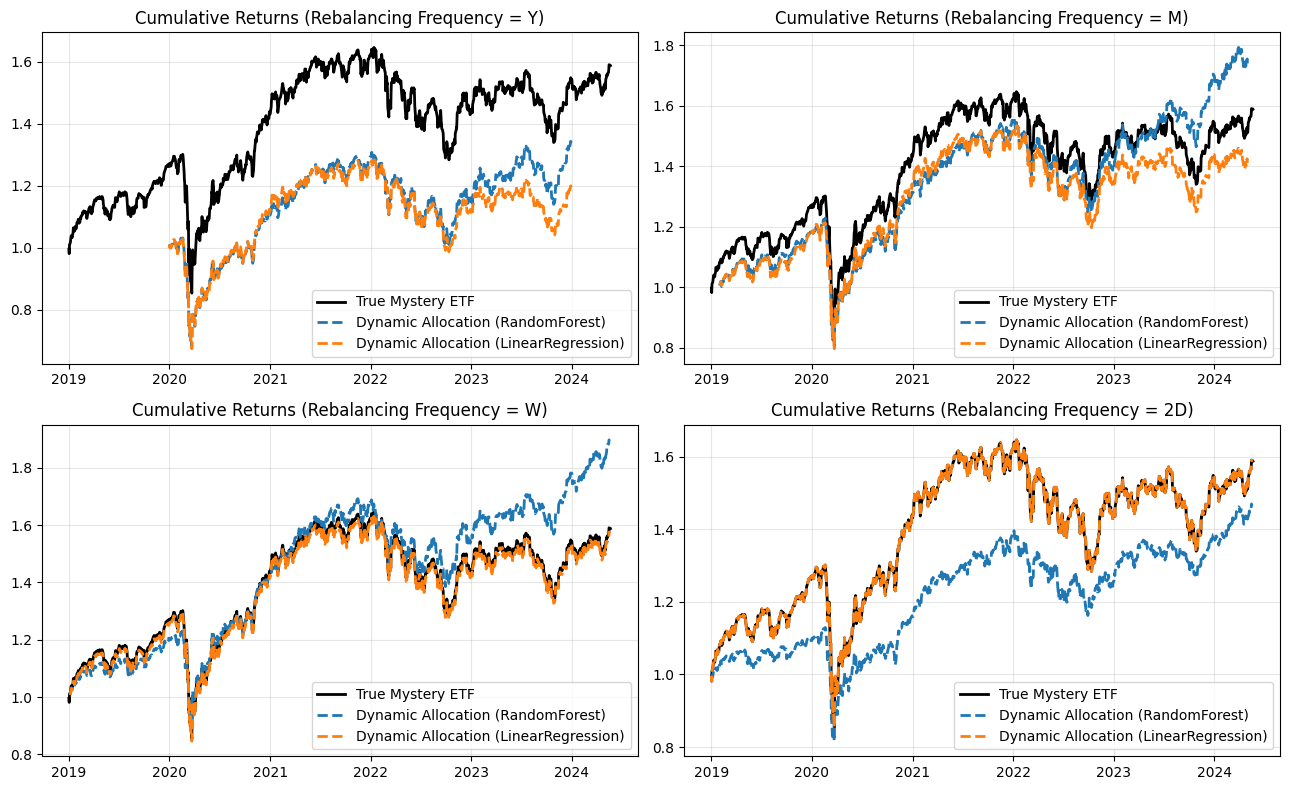

In [254]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))

plot_reconstructed_etf_cum_rets(cum_myst_etf2_Y, cum_reconstructed_etf2_rf_Y, cum_reconstructed_etf2_lr_Y, "Y", ax=axes[0,0])
plot_reconstructed_etf_cum_rets(cum_myst_etf2_M, cum_reconstructed_etf2_rf_M, cum_reconstructed_etf2_lr_M, "M", ax=axes[0,1])
plot_reconstructed_etf_cum_rets(cum_myst_etf2_W, cum_reconstructed_etf2_rf_W, cum_reconstructed_etf2_lr_W, "W", ax=axes[1,0])
plot_reconstructed_etf_cum_rets(cum_myst_etf2_2D, cum_reconstructed_etf2_rf_2D, cum_reconstructed_etf2_lr_2D, "2D", ax=axes[1,1])
plt.tight_layout()
plt.show()

# Conclusion — Identification of the Mystery Allocation


By our analysis, we managed to identify the composition of the Mystery Allocations by decomposing their returns into exposures to both main asset classes and base ETFs, using complementary fixed and dynamic regression-based approaches.

For both Mystery ETFs, the results reveal clear and economically meaningful compositions:
- Mystery ETF 1 is predominantly a US equity–driven portfolio, with the S&P 500 as the dominant risk factor, complemented by secondary exposures to other developed equity markets.
- Mystery ETF 2 is an European-focused equity allocation, mainly driven by Euro Stoxx 50 and UK equities, with limited exposure to defensive assets.

<br>

## Uncertainty Assessment

- The main source of uncertainty arises from high correlations between major equity factors (e.g. S&P 500 vs Euro Stoxx 50), which makes precise weight attribution between closely related assets inherently ambiguous.
- This uncertainty is quantified by comparing direct asset-based and indirect ETF-mapped decompositions. The relatively small absolute differences confirm that the identified compositions are robust.
- Random Forest regressions produce sparse, stable allocations, enhancing interpretability, while Linear Regression confirms the linear and systematic nature of the underlying relationships.

<br>


## Main Biases Identified


The decomposition is conditional on the available ETF set. While it captures the dominant systematic risks well, some alternative, niche, or poorly represented asset classes may be partially or fully missed, introducing structural bias into the inferred Mystery ETF composition.

| Main Bias | Description |
|---------|-------------|
| **Equity Overrepresentation** | The ETF set is dominated by developed equity markets (US and Europe), <br>making equity factors easier to detect and potentially overstating equity <br>exposure in the Mystery ETFs. |
| **Limited Alternatives Exposure** | Asset classes such as REITs, infrastructure, private equity, hedge-fund-like strategies, <br>or volatility strategies are weakly represented or absent, so their exposure may be absorbed <br>by correlated equity factors. |
| **Shallow Commodity Coverage** | Commodities are represented by only a few ETFs (e.g. Gold or broad indices), <br>limiting the ability to capture energy, industrial metals, or agricultural exposures. |
| **Interest Rate Structure Bias** | Fixed income ETFs mainly capture duration and credit risk, while more complex rate risks <br>(yield curve shape, inflation-linked bonds, non-linear exposures) are underrepresented. |
| **Geographical Bias** | Strong coverage of US and European markets, with limited granularity for emerging markets, <br>frontier markets, or region-specific exposures. |

_____

# Extra: Markowitz Efficient Frontiers

In [286]:
def portfolio_return(w, mu):
    return np.dot(w, mu)

def portfolio_vol(w, cov):
    return np.sqrt(w @ cov @ w)

def min_vol_target_return(target_return, mu, cov):
    cons = (
        {"type": "eq", "fun": lambda w: portfolio_return(w, mu) - target_return},
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    )
    bounds = [(0, 1)] * len(mu)
    w0 = np.ones(len(mu)) / len(mu)

    res = minimize(portfolio_vol, w0, args=(cov,),
                   constraints=cons, bounds=bounds)
    return res.x

def markowitz_opt(returns):
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    n_assets = len(mu)

    target_returns = np.linspace(mu.min(), mu.max(), 50)

    frontier_vol = []
    frontier_ret = []
    for r in target_returns:
        w = min_vol_target_return(r, mu, cov)
        frontier_vol.append(portfolio_vol(w, cov))
        frontier_ret.append(portfolio_return(w, mu))
    return frontier_vol, frontier_ret

In [298]:
frontier_vol_assets, frontier_ret_assets = markowitz_opt(main_asset_rets)
frontier_vol_etfs, frontier_ret_etfs = markowitz_opt(etf_aligned1)

In [306]:
# Annualized returns and volatilities
mu_assets = main_asset_rets.mean() * 252
cov_assets = main_asset_rets.cov() * 252
vol_assets = np.sqrt(np.diag(cov_assets))

mu_etfs = etf_aligned1.mean() * 252
cov_etfs = etf_aligned1.cov() * 252
vol_etfs = np.sqrt(np.diag(cov_etfs))

# Mystery ETFs
myst1_mu, myst1_std = myst1_aligned.mean() * 252, myst1_aligned.std() * np.sqrt(252)
myst2_mu, myst2_std = myst2_aligned.mean() * 252, myst2_aligned.std() * np.sqrt(252)

- The 14 main assets frontier (orange line) lies above the 105 ETFs frontier (blue line), demonstrating better risk-adjusted return potential due to broader diversification.


<br>



Mystery ETFs
- Mystery ETF 1 (red star): Lies below the 105 ETF frontier (moderate volatility, high US equity exposure). It is sub-optimal, meaning the same risk could have achieved higher returns via optimal allocation across the 105 ETFs.
- Mystery ETF 2 (green star): Also lies below the 105 ETF frontier (slightly higher volatility, European focus). Similarly sub-optimal, confirming that fixed allocations to a few indices do not exploit the full diversification potential.

<br>

> Both Mystery ETFs are inefficient relative to the broader ETF universe, likely due to concentrated equity allocations.

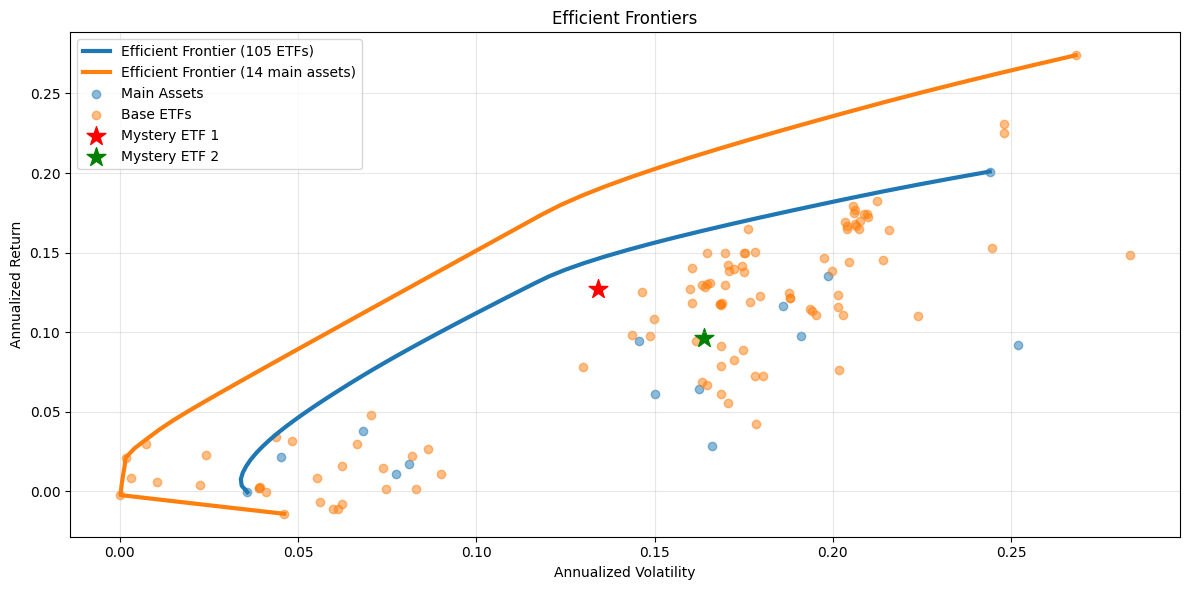

In [315]:
# Efficient frontier
plt.figure(figsize=(12, 6))
plt.plot(frontier_vol_assets, frontier_ret_assets, linewidth=3, label="Efficient Frontier (105 ETFs)")
plt.plot(frontier_vol_etfs, frontier_ret_etfs, linewidth=3, label="Efficient Frontier (14 main assets)")

# Scatter individual main assets
plt.scatter(vol_assets, mu_assets, alpha=0.5, label="Main Assets")
# Scatter individual ETFs
plt.scatter(vol_etfs, mu_etfs, alpha=0.5, label="Base ETFs")

# Mystery ETFs
plt.scatter(myst1_std, myst1_mu, marker='*', s=200, color='red', label="Mystery ETF 1")
plt.scatter(myst2_std, myst2_mu, marker='*', s=200, color='green', label="Mystery ETF 2")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontiers")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()